# Clock-building notebook for beluga methylation array data: n = 67


This notebook aims to build clocks from methylation data generated through the Horvath Custom Methylation Array run at UCLA. 


## Import packages 

In [1]:
#import matplotlib for plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl 

#Make fonts 'TrueType' for figures in pdf and ps (avoids font that won't work in many journals)
#This also seemed to be important to get things to show up correctly in Illustrator
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

#import pandas for working with dataframes 
import pandas as pd 
from pandas import DataFrame, read_csv 

#import numpy 
import numpy as np 


#csv reader 
import csv

#import scipy packages
from scipy import stats 
import pylab 

#Enable in-line plotting 
%matplotlib inline


## Import data files & make dataframes

*IMPORTANT:*

As of 10 December 2019, the file that has (1) just probes that start with 'cg' and (2) only individuals with a z-code from SWFSC will be included in the datafile. ALSO, the file has been updated to include data that replaces 'dleu_35281' with 'dleu_35281_KBO'. This is because of results from the HIERARCHICAL CLUSTERING ANALYSIS.

NOTE: As of July 2020, with new information on errors in the NOAA dataset, we have re-run analyses with 67 whales, as shown in the analysis below. The info on the input file above is correct, but the filtering below has evolved. 



In [2]:
# This is a filepath to the 'simple' beluga sesame normalized data in which I've removed the row with ages.
# The file has data for 70 individuals (but including reps!) and only has data for probes starting with 'cg'
sesame_data_path = '/Users/elliebors/Desktop/Beluga/methylation_array/data/normalized_data_July2019/simple_beluga_sesame_normalized_betas_cg_only_n70_hierarchFixed.csv'

beluga_sesame_df = pd.read_csv(sesame_data_path, sep=',', index_col=0)

## Uncomment line below to view your dataframe 
#beluga_sesame_df


### Metadata (age, sex, etc.) 

In [3]:
#File path to a data file that has the following metadata for every sample, including the averaged replicates: 
# (1) age (note: Tooth age. Updated to reflect the one age error we found (sample ####))
# (2) sex (note: updated with molecular sex data from PCR)
# (3) binary_sex: a column where 1=female and 0=male
# (3) whale_length 

metadata_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/beluga_metadata.csv'

beluga_metadata_df = pd.read_csv(metadata_filepath, sep = ',', index_col=0)

## Uncomment line below to view your dataframe
beluga_metadata_df


age  binary_sex sex  ConfidenceInAgeEstimate  \
sampleID                                                            
dleu_1335           18.0           0   m                  0.75000   
dleu_4195           23.0           1   f                  0.66666   
dleu_4360           18.0           0   m                  0.75000   
dleu_4361           17.0           0   m                  0.75000   
dleu_5316           23.0           1   f                  0.66666   
dleu_5381           22.0           1   f                  0.66666   
dleu_9798           26.0           1   f                  0.66666   
dleu_9799           25.0           0   m                  0.66666   
dleu_9800           20.0           0   m                  0.75000   
dleu_10918          17.0           1   f                  1.00000   
dleu_35279          22.0           0   m                  0.66666   
dleu_70583          49.0           0   m                  0.40000   
dleu_144309_KP      39.0           1   m                  0.40000   
dleu_692_BLKA_074    0.5           1   f                  1.00000   
dleu_1336           35.0           0   m                  0.40000   
dleu_4107           23.0           0   m                  0.66666   
dleu_4108            2.0           1   f                  1.00000   
dleu_4109           19.0           1   f                  0.75000   
dleu_5428           29.0           1   f                  0.40000   
dleu_13507          17.0           1   f                  0.75000   
dleu_25494_08       21.0           1   f                  1.00000   
dleu_25495_08        0.1           1   f                  1.00000   
dleu_41732           9.0           0   m                  1.00000   
dleu_41745_06       21.0           0   m                  0.66666   
dleu_70581          30.0           1   f                  0.40000   
dleu_77292          10.0           1   f                  1.00000   
dleu_79633_06       37.0           1   f                  0.40000   
dleu_113072         15.0           0   m                  0.75000   
dleu_144309_13      39.0           0   m                  0.40000   
dleu_156874         20.0           0   m                  0.75000   
...                  ...         ...  ..                      ...   
dleu_35280          20.0           0   m                  0.75000   
dleu_35281_KBO      26.0           0   m                  0.66666   
dleu_35281          26.0           0   m                  0.66666   
dleu_35344          22.0           1   f                  0.66666   
dleu_35345           1.0           0   m                  0.75000   
dleu_35853          28.0           0   m                  0.66666   
dleu_39050          23.0           1   f                  0.66666   
dleu_41745_07       21.0           0   m                  0.66666   
dleu_47973          30.0           0   m                  0.66666   
dleu_74693          32.0           1   f                  0.66666   
dleu_88661          16.0           1   f                  0.75000   
dleu_91065          14.0           1   f                  0.75000   
dleu_91066          27.0           1   f                  0.66666   
dleu_91067           6.0           0   m                  1.00000   
dleu_143907         41.0           0   m                  0.40000   
dleu_156870         40.0           0   m                  0.40000   
dleu_156873         40.0           0   m                  0.40000   
dleu_16605          10.0           0   m                  1.00000   
dleu_25494_16       21.0           1   f                  0.75000   
dleu_25495_16        0.1           1   f                  1.00000   
dleu_79633_13       37.0           1   f                  0.40000   
dleu_28926_B        22.0           0   m                  0.66666   
dleu_32512_B        -1.0           1   f                  1.00000   
dleu_41745_avg      21.0           0   m                  0.66666   
dleu_25494_avg      21.0           1   f                  0.75000   
dleu_25495_avg     

### Import genome mapping data 

Coordinates from UCLA team.

In [4]:

# A file that has the beluga genome coordinates for probes mapped exactly + uniquely (analysis by M Thompson)
unique_mapping_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/site_information/Dleu_unique_probe_locations_cgonly.csv'

# A file that has the beluga genome coordiantes for probes mapped exactly + multiple times (analysis by M Thompson)
# This file has multiple columns with coordinates 1, 2, 3.... 
ambiguous_mapping_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/site_information/Dleu_ambiguous_probe_locations.csv'

# Make a unique mapped dataframe 
unique_mapping_df = pd.read_csv(unique_mapping_filepath, sep = ',', index_col=0)
# Ensure that the scaffold coordinate (scaff_coord) column has values that are strings 
unique_mapping_df['scaff_coord'] = unique_mapping_df['scaff_coord'].astype('str')

# Make an 'ambigous' mapped dataframe 
ambiguous_mapping_df = pd.read_csv(ambiguous_mapping_filepath, sep = ',', index_col=0)

#unique_mapping_df
#ambiguous_mapping_df

## Subsetting data for replicate info and p-value filtering 

In some of our original data, we ran samples multiple times. Here, I generated numerous versions of the data to trial running the data with different replicates. I also trialed averaging replicate data, which is shown in the next cell. 

In [5]:
## Make new columns in the beluga_sesame_df that are averages of replicate samples
# Note that the sequential replicates are already removed from this spreadsheet. 

beluga_sesame_df['dleu_32512_avg'] = (beluga_sesame_df['dleu_32512_A'] + beluga_sesame_df['dleu_32512_B'])/2
beluga_sesame_df['dleu_79633_avg'] = (beluga_sesame_df['dleu_79633_13'] + beluga_sesame_df['dleu_79633_06'])/2
beluga_sesame_df['dleu_28926_avg'] = (beluga_sesame_df['dleu_28926_A'] + beluga_sesame_df['dleu_28926_B'])/2
beluga_sesame_df['dleu_25495_avg'] = (beluga_sesame_df['dleu_25495_08'] + beluga_sesame_df['dleu_25495_16'])/2
beluga_sesame_df['dleu_25494_avg'] = (beluga_sesame_df['dleu_25494_08'] + beluga_sesame_df['dleu_25494_16'])/2
beluga_sesame_df['dleu_144309_avg'] = (beluga_sesame_df['dleu_144309_13'] + beluga_sesame_df['dleu_144309_KP'])/2
beluga_sesame_df['dleu_41745_avg'] = (beluga_sesame_df['dleu_41745_06'] + beluga_sesame_df['dleu_41745_07'])/2

#beluga_sesame_df

In [6]:
## Making unique lists that enable me to remove outliers from different parts of the analysis. 


samples = []
for i in beluga_sesame_df.columns: 
    samples.append(i)
# print(len(samples))

# Define lists of sample replicates that will be removed from the whole list of samples available in the data file

sesame_KBO_samp_69_exclusion = ['dleu_32512_A','dleu_79633_06', 'dleu_28926_A', 'dleu_25495_08', 'dleu_25494_08', 
                              'dleu_144309_KP', 'dleu_41745_06', 'dleu_32512_avg', 'dleu_79633_avg', 'dleu_28926_avg',
                              'dleu_25495_avg', 'dleu_25494_avg', 'dleu_144309_avg', 'dleu_41745_avg',  
                              'dleu_35281', 'dleu_34578']

sesame_KBO_samp_67_exclusion = ['dleu_32512_A','dleu_79633_06', 'dleu_28926_A', 'dleu_25495_08', 'dleu_25494_08', 
                              'dleu_144309_KP', 'dleu_41745_06', 'dleu_32512_avg', 'dleu_79633_avg', 'dleu_28926_avg',
                              'dleu_25495_avg', 'dleu_25494_avg', 'dleu_144309_avg', 'dleu_41745_avg',  
                              'dleu_35281', 'dleu_34578', 'dleu_144309_13', 'dleu_143907']

# The following lines of code to 3 things: 
# ... (1) define new lists of sample names to acheive the three different ways of dealing with replicates 
# ... (2) define a dataframe of beta values for the subset of samples in your lists 
# ... (3) export a csv file of the beta values for the samples you want


sesame_KBO_samp_67_sample_names = [samp for samp in samples if samp not in sesame_KBO_samp_67_exclusion]
sesame_KBO_samp_67 = beluga_sesame_df[sesame_KBO_samp_67_sample_names]
sesame_KBO_samp_67.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/sesame_KBO_samp_67.csv')
print(len(sesame_KBO_samp_67.columns))

sesame_KBO_samp_67_sample_names

67


['dleu_1335',
 'dleu_4195',
 'dleu_4360',
 'dleu_4361',
 'dleu_5316',
 'dleu_5381',
 'dleu_9798',
 'dleu_9799',
 'dleu_9800',
 'dleu_10918',
 'dleu_35279',
 'dleu_70583',
 'dleu_1336',
 'dleu_4107',
 'dleu_4108',
 'dleu_4109',
 'dleu_5428',
 'dleu_13507',
 'dleu_41732',
 'dleu_70581',
 'dleu_77292',
 'dleu_113072',
 'dleu_156874',
 'dleu_157255',
 'dleu_1572',
 'dleu_4196',
 'dleu_4359',
 'dleu_6001',
 'dleu_6002',
 'dleu_7401',
 'dleu_8419',
 'dleu_10044',
 'dleu_10920',
 'dleu_12733',
 'dleu_13504',
 'dleu_13505',
 'dleu_13506',
 'dleu_17860',
 'dleu_17861',
 'dleu_24819',
 'dleu_25493',
 'dleu_27937',
 'dleu_28944',
 'dleu_34577',
 'dleu_34579',
 'dleu_35278',
 'dleu_35280',
 'dleu_35344',
 'dleu_35345',
 'dleu_35853',
 'dleu_39050',
 'dleu_41745_07',
 'dleu_47973',
 'dleu_74693',
 'dleu_88661',
 'dleu_91065',
 'dleu_91066',
 'dleu_91067',
 'dleu_156870',
 'dleu_156873',
 'dleu_16605',
 'dleu_25494_16',
 'dleu_25495_16',
 'dleu_79633_13',
 'dleu_28926_B',
 'dleu_32512_B',
 'dleu_352

### p-value filtering 

Find CpGs that had good detection pValues on the array and filter for those

Updated 09July2020: We have excluded 2 individuals from the previous run, leaving us with just 67 whales. 


The following code uses a file that has been MANUALLY altered to contain only detection pValues for the 67 samples that are going to be included. 

NOTE: Because the final dataset we are using has 67 samples, we are only going to run the p-value filtering on those individuals. 

In [7]:
# Load in a file that has the pVlaues for JUST the 67 beluga [09 July 2020 update] 
#(or: for all beluga -- the top file path; for 69 beluga -- second filepath)

## NOTE: Also in this updated code, I have properly set the elif statement so it returns "10 or more" andnot "over 10"

#sesame_detection_pValue_filepath = "/Users/elliebors/Desktop/Beluga/methylation_array/data/sesame_pValues_22Dec2019/beluga_detection_p_values_sesame_EKB_IDs.csv"
#sesame_detection_pValue_filepath = "/Users/elliebors/Desktop/Beluga/methylation_array/data/sesame_pValues_22Dec2019/calibration_beluga_detection_p_values_sesame_EKB_IDs.csv"
sesame_detection_pValue_filepath = "/Users/elliebors/Desktop/Beluga/methylation_array/data/sesame_pValues_22Dec2019/calibration_beluga_detection_p_values_sesame_EKB_IDs_n67.csv"

# Make a dataframe of all the pValues JUST FOR THE n = 67 Dataset! [UPDATE: on 09July]
sesame_detection_pValue_df = pd.read_csv(sesame_detection_pValue_filepath, index_col=0)

# Un-comment and move down if you'd like to see all the pValues in the df.
#sesame_detection_pValue_df

#Makes a dataframe that consists of boolean expressions: True if the pValue is <= 0.05; False if the pValue >0.05. 
significant_pValues = (sesame_detection_pValue_df.iloc[0:] <=0.05)

#This row reminds you how many samples are in the database you're using. Should match #samples in your spreadsheet. 
print("We are testing pValues for",len(significant_pValues.iloc[1]),"samples.")


## To be 'good,' there must be one or more samples that have a pValue <0.05. 

#Make an exmpty list that you'll fill with the names of bad probes
bad_probes = []

for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes.append(i)

print("There are", len(bad_probes), "for which all samples have a p-value > 0.05.")
      
## Get a list of the "Good Probes" 
## which are the ones that had at least one samples with a pValue equal to or below 0.05 (i.e. significant). 

# First have to make a list of all the probes (so it can be compared to bad_probes)
all_probes = []
for i in sesame_detection_pValue_df.index: 
    all_probes.append(i)

# Now, define good probes as the items in all_probes that are not in bad_probes 
# (reminder: bad_probes has a list of the probes that have p=values > 0.05 for ALL 69 samples)

good_probes = [probe for probe in all_probes if probe not in bad_probes]
print("There are",len(good_probes),"probes that have significant detection p- values for at least one sample.")
#good_probes


## Now, to be good, there must be 10 or more samples for which the pValue is < 0.05. 

bad_probes_max10good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max10good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-10):
        bad_probes_max10good.append(i) 
print("There are", len(bad_probes_max10good), "probes for which 10 or more samples had a pValue >0.05.")

good_probes_max10good = [probe for probe in all_probes if probe not in bad_probes_max10good]
print("There are",len(good_probes_max10good),"probes that passed for 'good_probes_max10good'.")


## To be good, there must be 20 or more samples for which the pValue is <0.05. 

bad_probes_max20good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max20good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-20):
        bad_probes_max20good.append(i) 
print("There are", len(bad_probes_max20good), "probes for which at least 20 samples had a pValue >0.05.")

good_probes_max20good = [probe for probe in all_probes if probe not in bad_probes_max20good]
print("There are",len(good_probes_max20good),"probes that passed for 'good_probes_max20good'.")

## To be good, there must be 30 or more samples for which the pValue is <0.05. 

bad_probes_max30good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max30good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-30):
        bad_probes_max30good.append(i) 
print("There are", len(bad_probes_max30good), "probes for which at least 30 samples had a pValue >0.05.")

good_probes_max30good = [probe for probe in all_probes if probe not in bad_probes_max30good]
print("There are",len(good_probes_max30good),"probes that passed for 'good_probes_max30good'.")

## To be good, there must be 40 or more samples for which the pValue is <0.05. 

bad_probes_max40good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max40good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-40):
        bad_probes_max40good.append(i) 
print("There are", len(bad_probes_max40good), "probes for which atleast 40 samples had a pValue >0.05.")

good_probes_max40good = [probe for probe in all_probes if probe not in bad_probes_max40good]
print("There are",len(good_probes_max40good),"probes that passed for 'good_probes_max40good'.")

## To be good, there must be 50 or more samples for which the pValue is <0.05. 

bad_probes_max50good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max50good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-50):
        bad_probes_max50good.append(i) 
print("There are", len(bad_probes_max50good), "probes for which at least 50 samples had a pValue >0.05.")

good_probes_max50good = [probe for probe in all_probes if probe not in bad_probes_max50good]
print("There are",len(good_probes_max50good),"probes that passed for 'good_probes_max50good'.")

## To be good, there must be 60 or more samples for which the pValue is <0.05. 

bad_probes_max60good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(j)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max60good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list) > (len(significant_pValues.loc[i])-60):
        bad_probes_max60good.append(i) 
print("There are", len(bad_probes_max60good), "probes for which at least 60 samples had a pValue > 0.05.")

good_probes_max60good = [probe for probe in all_probes if probe not in bad_probes_max60good]
print("There are",len(good_probes_max60good),"probes that passed for 'good_probes_max60good'.")



We are testing pValues for 67 samples.
There are 6056 for which all samples have a p-value > 0.05.
There are 31432 probes that have significant detection p- values for at least one sample.
There are 8613 probes for which 10 or more samples had a pValue >0.05.
There are 28875 probes that passed for 'good_probes_max10good'.
There are 9440 probes for which at least 20 samples had a pValue >0.05.
There are 28048 probes that passed for 'good_probes_max20good'.
There are 10157 probes for which at least 30 samples had a pValue >0.05.
There are 27331 probes that passed for 'good_probes_max30good'.
There are 11005 probes for which atleast 40 samples had a pValue >0.05.
There are 26483 probes that passed for 'good_probes_max40good'.
There are 11962 probes for which at least 50 samples had a pValue >0.05.
There are 25526 probes that passed for 'good_probes_max50good'.
There are 13838 probes for which at least 60 samples had a pValue > 0.05.
There are 23650 probes that passed for 'good_probes_max6

In [8]:
## Testing the code above to check cutoffs at 10, 20, etc.  

significant_pValues
good_probes_max10good

#"cg01142419" in good_probes_max10good # (probe for which there are 11 good and 56 bad pValues)
"cg00049667" in good_probes_max10good #(probe for which there are 10 good and 57 bad pValues)

True

The next cell (and those after it) takes a long time to run. It makes a dataframe that contains the probes that had at least one calibration individual with a good pValue, e.g., all probes for which all samples had a pValue>0.05 were removed. 

In [15]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which all samples had to have a pValue > 0.05 to exclude the probe: 

pValue_bad_removed_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes:
    pValue_bad_removed_KBO_samp_67_df = pValue_bad_removed_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_bad_removed_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_bad_removed_KBO_samp_67.csv')


In [16]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 10 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_10good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max10good:
    pValue_10good_KBO_samp_67_df = pValue_10good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_10good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_10good_KBO_samp_67.csv')


In [17]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 20 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_20good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max20good:
    pValue_20good_KBO_samp_67_df = pValue_20good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_20good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_20good_KBO_samp_67.csv')


In [18]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 30 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_30good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max30good:
    pValue_30good_KBO_samp_67_df = pValue_30good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_30good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_30good_KBO_samp_67.csv')


In [19]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 40 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_40good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max40good:
    pValue_40good_KBO_samp_67_df = pValue_40good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_40good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_40good_KBO_samp_67.csv')


In [20]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 50 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_50good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max50good:
    pValue_50good_KBO_samp_67_df = pValue_50good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_50good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_50good_KBO_samp_67.csv')


In [21]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 60 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_60good_KBO_samp_67_df = pd.DataFrame(columns=sesame_KBO_samp_67.columns)
for i in good_probes_max60good:
    pValue_60good_KBO_samp_67_df = pValue_60good_KBO_samp_67_df.append(sesame_KBO_samp_67.loc[i])

pValue_60good_KBO_samp_67_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_60good_KBO_samp_67.csv')


## Mapping data into dataframes

The next cells deal with mapping information from UCLA for the different probes. Note that I already removed array probes that are for calibration/SNPs and are not the CpG probes. So this should represent just the CpG probes that start with "cg".

_This was not used in the paper. However, it is here if you are interested in using coordinates or filetering based on mapping. Instead of doing this, we used p Values (above)._

In [18]:
# Filter the data files for CpGs that mapped exactly & uniquely

cpg_list_from_mapped_datafile = unique_mapping_df.index[0:]

ambiguously_mapped_cpgs = ambiguous_mapping_df.index[0:]

unique_mapped_cpgs = []
any_mapped_cpgs = []
for i in cpg_list_from_mapped_datafile: 
    if unique_mapping_df.loc[i]['scaff_coord']!=':':
        unique_mapped_cpgs.append(i)
        any_mapped_cpgs.append(i)

for i in ambiguously_mapped_cpgs:
    any_mapped_cpgs.append(i)

print('The total number of CpGs on the arrray is', len(cpg_list_from_mapped_datafile))
print('The number of CpGs mapped uniquely is', len(unique_mapped_cpgs))
print('The number of CpGs mapped in any way (ambigously or uniquely) is', len(any_mapped_cpgs))

#unique_mapped_cpgs
#any_mapped_cpgs

The total number of CpGs on the arrray is 37488
The number of CpGs mapped uniquely is 25482
The number of CpGs mapped in any way (ambigously or uniquely) is 25834


In [19]:
# Compare CpG lists from the mapping data and the sesame normalized data 
print (len(beluga_sesame_df.index))
print(len(unique_mapping_df.index))

# Initially there was some discrepancy int he length of the files because of some control probes etc. 
# If there is some discrepancy in the length of the sesame data and the mapping data, see what the probes are with: 
list(set(sesame_data_reps_avg.index) - set(unique_mapping_df.index))

37488
37488


[]

## Make age vectors and sex vectors

In [9]:
### FUNCTION ###
### make_age_vector ###

# This function takes the following arguments: 
# (1) sample_name_list = a list of the sample names you want to include in your age vector
# (2) metadata_dataframe_name = a metadata dataframe with a column 'age' containing an age value for every sample indexed by sample name 
# (3) the name of the output file you want to create... this could be an entire path to another directory. 
# This creates an 'age vector' that matches the order of the data in the beta file - to be used in glmnet() in R. 

def make_age_vector(sample_name_list, metadata_dataframe_name, output_file_name):
    #Make empty vector to fill 
    age_vector = []
    
    #Populate the vector with values corresponding to the sample names you are targeting 
    for samp in sample_name_list:
        age_vector.append(float(metadata_dataframe_name.loc[samp]['age']))
        
    #A check that your age vector matches your # of samples
    print ('There are', len(age_vector), 'items in', output_file_name)
    
    #The next part saves the list as a csv file where the values are separated by a comma in one line 
    with open(output_file_name, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(age_vector)
    
    #The function will, in addition to making a csv, return a list in python that you can use later
    #This list can be defined when you run the function (e.g. list_name = make_age_vector())
    return age_vector

###


There are 67 items in sesame_KBO_samp_67_age_vector.csv
21.0


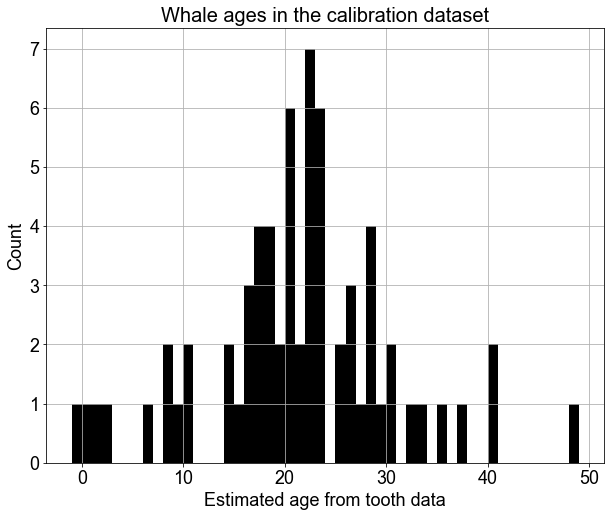

In [10]:
# Make age vector csv files for R inputs 

sesame_KBO_samp_67_age_vector = make_age_vector(sesame_KBO_samp_67_sample_names, beluga_metadata_df, 'sesame_KBO_samp_67_age_vector.csv')

ages_df = pd.DataFrame(columns=['age'])
ages_df['age']= sesame_KBO_samp_67_age_vector
ages_df.hist(column='age', figsize=(10,8), color = 'Black', bins= 50, xlabelsize=18, 
                                 ylabelsize = 18)

plt.title('Whale ages in the calibration dataset', fontsize = 20)
plt.xlabel('Estimated age from tooth data', fontsize = 18)
plt.ylabel('Count', fontsize = 18)

#plt.savefig('/Users/elliebors/Desktop/Beluga/manuscripts/beluga_array_ms/calibration_sample_ages_20Jan2020.pdf')

print(np.median(ages_df['age']))

In [11]:
### FUNCTION ###
### make_sex_vector ###

def make_sex_vector(sample_name_list, metadata_dataframe_name, output_file_name):
    #Make empty sex vector to fill 
    sex_vector = []
    
    #Populate the vector with values corresponding to the sample names you are targeting 
    for samp in sample_name_list:
        sex_vector.append(float(metadata_dataframe_name.loc[samp]['binary_sex']))
        
    #A check that your age vector matches your # of samples
    print ('There are', len(sex_vector), 'items in', output_file_name)
    
    #The next part saves the list as a csv file where the values are separated by a comma in one line 
    with open(output_file_name, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(sex_vector)
    
    #The function will, in addition to making a csv, return a list in python that you can use later
    #This list can be defined when you run the function (e.g. list_name = make_age_vector())
    return sex_vector
###


In [12]:
# Make a sex vector for input into a sex-preditor model in glmnet()

sesame_KBO_samp_67_sample_sex_vector = make_sex_vector(sesame_KBO_samp_67_sample_names, beluga_metadata_df, 'KBO_samp_67_sex_vector.csv')


There are 67 items in KBO_samp_67_sex_vector.csv


# Analysis in R

Following the above steps, glmnet() was used in R to actually generate the various clock models. That code is available in the same GitHub in which you'll find this notebook. 

# Plotting/Analyzing the Clock Output from R

Note that I have it set so R will output two csv files from cv.glmnet() work: 

(1) clock_cpgs.csv


(2) model_coefficients.csv 

These two files are output into a temporary folder:
"Desktop/Beluga/methylation_array/analysis/clock_building/temp/"



### Define Functions

Note that there are more functions here than you need to actually run the analysis. The main ones that are used are "make_epigenetic_clcok", "calculate_whale_ages", "sex_specific_clock_plots_and_stats", and "make_LOOCV_age_df". The other functions are precursors or additions to those three, which may or may not be useful if you're interested in the building blocks. 

In [13]:
### FUNCTION ### 
### make_epigenetic_clock ###

# Makes a dataframe with the information of the epigeentic clock built from any given model 

# This function takes the following arguments: 
# (1) the path to a csv that has a list of the clock's cpgs 
# (2) the path to a csv that has a list of the clock's coefficients 

# Note that these two files are outputs from the R cv.glmnet() analysis 
# Note that there is definitely a faster way to do this (like in R)! :) 
# The function returns a dataframe with two columns: cpgs and coefficients. 

def make_epigenetic_clock (clock_cpgs_csv_path, clock_coefficients_csv_path):
    # Make dataframes from the R output files 
    clock_cpgs_df = pd.read_csv(clock_cpgs_csv_path)
    clock_coefficients_df = pd.read_csv(clock_coefficients_csv_path)
    
    #Make a list of the CpGs in the clock 
    cpgs = clock_cpgs_df['x']
    
    #Make a list of the coefficients in the clock 
    coefficients = clock_coefficients_df['x']
    
    # The y-intercept will always be in the glmnet R output as the first value in the coefficient list
    yIntercept = coefficients[0]
    print ('The y intercept for this clock model equation is', yIntercept,'.')
    
    current_clock_df = pd.DataFrame(columns=['cpgs', 'coefficients'])
    current_clock_df['cpgs'] = cpgs
    current_clock_df['coefficients'] = coefficients

    return current_clock_df

###


In [14]:
### FUNCTION ### 
### calcualte_whale_ages ###

# Uses the output from glmnet() in the form of a df, calculates the predicted ages, and makes a dataframe for that model. 

# This function takes the following arguments: 
# (1) a list of whale sample names (whale_id_list) that correpond with the columns in a beta data file. 
# (2) the dataframe containing raw data you'd like to use 
# (3) the dataframe containing the current clock values - must have the columns 'cpgs' and 'coefficients'
# (4) a metadata dataframe with chronological age and sex. *Must have an index that is the sample names (sampleID)!

# NOTE that 'cpgs' and 'coefficients' from R glmnet() output have to have been defined outside of this function. 
# One way of defining cpgs and coefficients is to use the function above: make_epigenetic_clock
# This returns a dataframe that has two columns: sampleID and model_ages_df

def calculate_whale_ages(whale_id_list, normalized_beta_dataframe, current_clock_df, beluga_metadata_df): 
    # Calculate how many CpG terms there are in the clock/model 
    cpgs = current_clock_df['cpgs']
    coefficients = current_clock_df['coefficients']
    print ("There are", len(cpgs)-1, "cpgs in the current model")
    # This loops through the *index* of the cpgs to capture each term in the equation. 
    # NOTE: It starts at 1 because the 0 index item is the y-intercept!
    numbers = [i for i in range(1,len(cpgs)-1)]
    model_ages = []
    yIntercept = coefficients[0]
    # The following loop takes each whale and takes the column of beta values for that whale out of your dataframe
    for whale_id in whale_id_list:     
        beta_values_dleu_whale = normalized_beta_dataframe[whale_id]
        # Note that 'calculated_age' is a number that evolves throughout this code as each term of the equation is filled.
        # It starts here as the yIntercept and with the loop below, each term of the equation is added to the value. 
        # This process goes until the final output is the actual calculated age. 
        calculated_age = yIntercept
        
        for i in numbers: 
            #print (beta_values_dleu_whale[cpgs[i]] * coefficients[i])
            calculated_age = calculated_age + (beta_values_dleu_whale[current_clock_df.cpgs[i]] * current_clock_df.coefficients[i])
        
        # You can un-comment the following line to see the numbers as they are calcuated. 
        # print(whale_id, calculated_age)
        model_ages.append(calculated_age)
    model_ages_df = pd.DataFrame(columns=['sampleID', 'sex', 'model_age', 'known_age', 'age_error'])
    model_ages_df['sampleID'] = whale_id_list
    model_ages_df['model_age'] = model_ages
    known_ages = []
    for i in model_ages_df['sampleID']:
        known_ages.append((beluga_metadata_df.loc[i]['age']))
    model_ages_df['known_age'] = known_ages
    sample_sexes =[]
    for i in model_ages_df['sampleID']:
        sample_sexes.append((beluga_metadata_df.loc[i]['sex']))
    model_ages_df['sex']=sample_sexes
    model_ages_df['age_error']= model_ages_df['model_age']-model_ages_df['known_age']
    #Output of this function is a dataframe with whale sampleID and calculated model age
    return model_ages_df

###

In [15]:
### FUNCTION ### 
### make_LOOCV_age_df ###

# This function takes the following arguments: 
# (1) a path to the csv output from my LOOCV R code that contains a column of ages predicted by cv.glmnet in LOOCV
# (2) whale ID list that matches the order of the LOOCV output (must match order!)
# (3) a metadata dataframe with chronological age and sex. *Must have an index that is the sample names (sampleID)!

# This function will return a dataframe that had sampleID, sex, model_age, and known_age. 
# The output df can be used in plotting and analysis functions. 
                         
def make_LOOCV_age_df(LOOCV_ages_path, whale_id_list, beluga_metadata_df):
    
    LOOCV_df = pd.read_csv(LOOCV_ages_path, index_col=0, header = 0)
    LOOCV_ages = []
    for i in LOOCV_df['x']:
        LOOCV_ages.append(i)
    LOOCV_ages_df = pd.DataFrame(columns = ['sampleID', 'sex', 'model_age', 'known_age','age_error'])
    LOOCV_ages_df['sampleID'] = whale_id_list
    LOOCV_ages_df['model_age'] = LOOCV_ages[0:]
    
    known_ages = []
    for i in LOOCV_ages_df['sampleID']:
        known_ages.append((beluga_metadata_df.loc[i]['age']))
    LOOCV_ages_df['known_age'] = known_ages
    
    sample_sexes =[]
    for i in LOOCV_ages_df['sampleID']:
        sample_sexes.append((beluga_metadata_df.loc[i]['sex']))
    LOOCV_ages_df['sex']=sample_sexes
    
    LOOCV_ages_df['age_error']= LOOCV_ages_df['model_age']-LOOCV_ages_df['known_age']
    
    return LOOCV_ages_df

### 

In [16]:
### FUNCTION ###
### plot_model_vs_known_ages ### 

# This function takes the following arguments: 
# (1) the model age data 
# (2) the known age data 
# (3) a path to output the figure 
# (4) optional: clock title. default is 'Model Age vs. Known Age'
# (5) optional: x axis title. defaulat is 'Known age estimate'
# (6) optional: y axis title. default is 'Calculated model age'

## Note - this is a predecessor function to the next two: sex_specific_plot_model_vs_known_ages and sex_specific_clock_plots_and_stats

def plot_model_vs_known_ages(model_age_data, known_age_data, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Known age estimate', y_title = 'Calculated model age'):
    
    # Make the figures space in which to plot
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = fig.add_subplot(1,1,1)
    
    # Define x and y values to plot (model_age is 'y' and known age is 'x')
    known_ages = known_age_data
    model_ages = model_age_data

    ax.scatter(known_ages, model_ages, color = 'black', s=75)

    ax.set_title(plot_title, fontsize =30, loc='left' )
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize = 20)
    ax.tick_params(size=10, labelsize=18)
    plt.xlim(-2,50)
    plt.ylim(-2,50)

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')

    plt.savefig(output_path)
    
###

In [17]:
### FUNCTION ###
### sex_specific_plot_model_vs_known_ages ### 

# This function takes the following arguments: 
# (1) a dataframe that has model-predicted ages, known ages, and sex with index of sampleID 
#     NOTE: this dataframe could be generated by either make_LOOCV_age_df or calculate_whale_ages (other functions)
# (2) an output path for the resulting figure 
# (3) optional: clock title. default is 'Model Age vs. Known Age'
# (4) optional: x axis title. defaulat is 'Known age estimate'
# (5) optional: y axis title. default is 'Calculated model age'

def sex_specific_plot_model_vs_known_ages(model_age_df, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Known age estimate', y_title = 'Calculated model age'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)

    # Plot
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='model_age', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 150, edgecolors='black', fontsize = 14, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =36, loc='left' )
    ax.set_xlabel(x_title, fontsize=30)
    ax.set_ylabel(y_title, fontsize = 30)
    ax.tick_params(size=10, labelsize=26)
    plt.legend(fontsize=20)
    plt.xlim(-2,50)
    plt.ylim(-2,50)
    
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    model_ages = model_age_df['model_age']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        print("p-value for", key, ":", p_value)
        print("slope for", key, ":", slope)
        print("y-intercept for regression for", key, ":", intercept)
        reg_x = np.linspace(-2, 50) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])


    plt.savefig(output_path)
###

In [18]:
### FUNCTION ###
### sex_specific_clock_plots_and_stats ### 

# This function takes the following arguments: 
# (1) the clock name = a string that specifies which clock run it is
# (2) the alpha value
# (3) clock size - could be a number you put in or a value from another source
# (4) a dataframe that has model-predicted ages, known ages, and sex with index of sampleID 
#    NOTE: this dataframe could be generated by either make_LOOCV_age_df or calculate_whale_ages (other functions)
# (5) an output path for the resulting figure 
# (6) optional: clock title. default is 'Model Age vs. Known Age'
# (7) optional: x axis title. defaulat is 'Known age estimate'
# (8) optional: y axis title. default is 'Calculated model age'

## This function returns a dataframe (clock_stats_df) that contains age error stats and regression stats 

def sex_specific_clock_plots_and_stats(clock_name, alpha, clock_size, model_age_df, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Chronological age estimate', y_title = 'Calculated model age'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)

    
    # The following part of the function calculates the mae and medae
    
    age_error = model_age_df['model_age'] - model_age_df['known_age']
    
    clock_stats_df = pd.DataFrame(columns=['clock_info','alpha','clock_size','sex', 'mae', 'medae', 'r-squared','p-value', 'regression_slope','y-intercept'])
    
    clock_stats_df['clock_info']= [clock_name, clock_name, clock_name]
    
    clock_stats_df['clock_size']=[clock_size, clock_size, clock_size]
    
    alpha_list = []
    sex_list = []
    mae_list = []
    medae_list =[]
    rSquared_list=[]
    pValue_list=[]
    regression_slope_list=[]
    yIntercept_list=[]
    
    
    mae = np.mean(abs(age_error))
    print('The mean absolute error is', mae)
    
    medae = np.median(abs(age_error))
    print('The median absolute error is', medae)
    alpha_list.append(alpha)
    sex_list.append('all')
    mae_list.append(mae)
    medae_list.append(medae)

    
    groups = model_age_df.groupby('sex', sort=False)
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        age_error = model_ages - known_ages
        mae = np.mean(abs(age_error))
        print('The mean absolute error for', key,'is', mae)
        
        medae = np.median(abs(age_error))
        print('The median absolute error for', key,'is', medae)
        
        alpha_list.append(alpha)
        sex_list.append(key)
        mae_list.append(mae)
        medae_list.append(medae)
        
    clock_stats_df['alpha']=alpha_list
    clock_stats_df['sex']=sex_list
    clock_stats_df['mae']=mae_list
    clock_stats_df['medae']=medae_list
    
    
    # Plot
    
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='model_age', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 150, edgecolors='black', fontsize = 30, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =36, loc='left' )
    ax.set_xlabel(x_title, fontsize=30)
    ax.set_ylabel(y_title, fontsize = 30)
    ax.tick_params(size=10, labelsize=26)
    plt.legend(fontsize=20)
    plt.xlim(-2,52)
    plt.ylim(-2,52)
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    model_ages = model_age_df['model_age']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    rSquared_list.append(r_value**2)
    print("p-value:", p_value)
    pValue_list.append(p_value)
    print('slope:', slope)
    regression_slope_list.append(slope)
    print('y-intercept for regression:', intercept)
    yIntercept_list.append(intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 52) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        rSquared_list.append(r_value**2)
        print("p-value for", key, ":", p_value)
        pValue_list.append(p_value)
        print("slope for", key, ":", slope)
        regression_slope_list.append(slope)
        print("y-intercept for regression for", key, ":", intercept)
        yIntercept_list.append(intercept)
        reg_x = np.linspace(-2, 52) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])


    plt.savefig(output_path)
    
    clock_stats_df['r-squared']=rSquared_list
    clock_stats_df['p-value']=pValue_list
    clock_stats_df['regression_slope']=regression_slope_list
    clock_stats_df['y-intercept']=yIntercept_list
    
    return clock_stats_df

###

In [19]:
### FUNCTION ### 
### plot_sex_specific_age_error ###

# This function takes the following arguments: 
# (1) model_age_df is a dataframe with known ages and model ages for each individual 
# (2) output file path 
# (3) optional: plot title. default is "Age error with age"
# (4) optional: X axis title. Default is "Chronological age estimate"
# (5) optional: Y axis title. Default is "Model age error"


def plot_sex_specific_age_error(model_age_df, output_path, plot_title ='Age error with age',
                            x_title = 'Chronological age', y_title = 'Model age error'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    ax.axhline(y=0, color='black', lw = 1)

    # Plot
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='age_error', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 100, edgecolors='black', fontsize = 14, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =30, loc='left' )
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize = 20)
    ax.tick_params(size=10, labelsize=18)
    plt.xlim(-2,52)
    plt.ylim(-20,20)
    
    ax.axhline(y=0, color='black', lw = 1)
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        age_error = single_sex_df['age_error']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, age_error)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        print("p-value for", key, ":", p_value)
        print("slope for", key, ":", slope)
        print("y-intercept for regression for", key, ":", intercept)
        reg_x = np.linspace(-2, 52) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    age_error = model_age_df['age_error']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, age_error)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 52) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    sign_change_x_value = -intercept/slope 
    print(sign_change_x_value)

    plt.savefig(output_path)
    

###


In [20]:
### FUNCTION ###
### calculate_mae_medae ### 

# This function takes the following arguments: 
# (1) The model age data 
# (2) The known age data 

# Note that this function isn't necessary if you run the plot and stats function above. But may be useful if you'd like to use it in isolation. 

def calculate_mae_medae (model_age_df, alpha): 
    age_error = model_age_df['model_age'] - model_age_df['known_age']
    
    age_error_df = pd.DataFrame(columns=['alpha','sex', 'mae', 'medae'])

    alpha_list = []
    sex_list = []
    mae_list = []
    medae_list =[]
    
    
    mae = np.mean(abs(age_error))
    print('The mean absolute error is', mae)
    
    medae = np.median(abs(age_error))
    print('The median absolute error is', medae)
    alpha_list.append(alpha)
    sex_list.append('all')
    mae_list.append(mae)
    medae_list.append(medae)

    
    groups = model_age_df.groupby('sex', sort=False)
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        age_error = model_ages - known_ages
        mae = np.mean(abs(age_error))
        print('The mean absolute error for', key,'is', mae)
        
        medae = np.median(abs(age_error))
        print('The median absolute error for', key,'is', medae)
        
        alpha_list.append(alpha)
        sex_list.append(key)
        mae_list.append(mae)
        medae_list.append(medae)
        
    age_error_df['alpha']=alpha_list
    age_error_df['sex']=sex_list
    age_error_df['mae']=mae_list
    age_error_df['medae']=medae_list
    
    return age_error_df

    
###
 

# For 67 samples using KBO update for 35281

The y intercept for this clock model equation is 220.530227807395 .
There are 37488 cpgs in the current model
The mean absolute error is 0.20076301382268472
The median absolute error is 0.1213051912034473
The mean absolute error for m is 0.22669690083761018
The median absolute error for m is 0.13775836488844373
The mean absolute error for f is 0.17064624180535193
The median absolute error for f is 0.11566070010287177
r-squared: 0.9995163753939559
p-value: 1.739552873422013e-109
slope: 0.9771516634232186
y-intercept for regression: 0.4735682299948003
r-squared for m : 0.9995092145633496
p-value for m : 7.555561390825673e-58
slope for m : 0.9737450515296857
y-intercept for regression for m : 0.5587136549707132
r-squared for f : 0.9995738063824781
p-value for f : 1.9787235953714267e-50
slope for f : 0.9822530251921384
y-intercept for regression for f : 0.35594534392475197


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a00_clock    0.0       37488  all  0.200763  0.121305   
1  all_KBO_samp_67_a00_clock    0.0       37488    m  0.226697  0.137758   
2  all_KBO_samp_67_a00_clock    0.0       37488    f  0.170646  0.115661   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999516  1.739553e-109          0.977152     0.473568  
1   0.999509   7.555561e-58          0.973745     0.558714  
2   0.999574   1.978724e-50          0.982253     0.355945

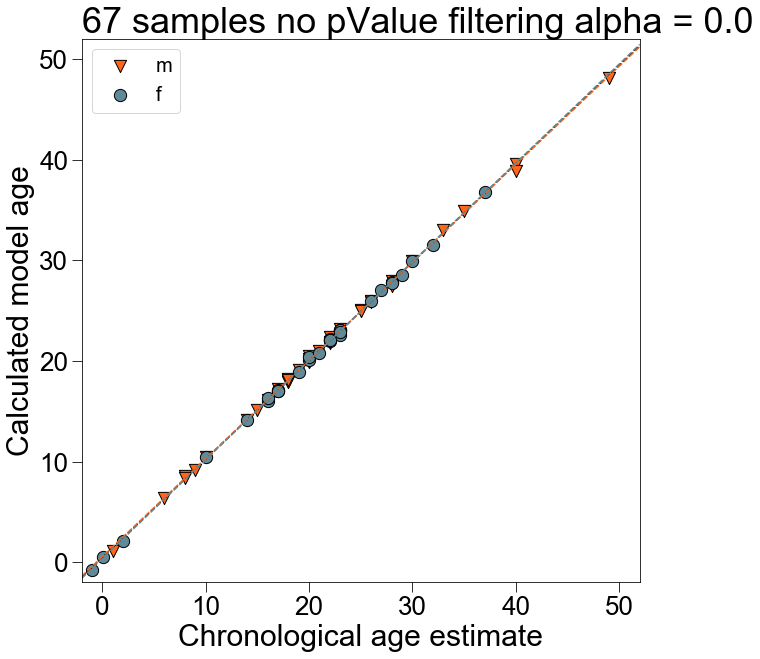

In [21]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a00_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a00_model_cpgs.csv'
all_KBO_samp_67_a00_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a00_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a00_clock = make_epigenetic_clock(all_KBO_samp_67_a00_clock_cpgs_path, all_KBO_samp_67_a00_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a00_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a00_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a00_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a00_clock", 0.0, len(all_KBO_samp_67_a00_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a00_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a00_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.0')
all_KBO_samp_67_a00_clock_stats

The y intercept for this clock model equation is 167.808494208466 .
There are 208 cpgs in the current model
The mean absolute error is 0.4285570532996965
The median absolute error is 0.41307550289470285
The mean absolute error for m is 0.4544557543636599
The median absolute error for m is 0.4314464296019729
The mean absolute error for f is 0.39848114238670673
The median absolute error for f is 0.36810703873659634
r-squared: 0.9991861345232916
p-value: 3.863180232576809e-102
slope: 0.9732888359908608
y-intercept for regression: 0.9032749982868857
r-squared for m : 0.9990962896176607
p-value for m : 2.4304727496289825e-53
slope for m : 0.9716399089513292
y-intercept for regression for m : 0.9442282990287474
r-squared for f : 0.9993296348571801
p-value for f : 1.4081527054515168e-47
slope for f : 0.9757627933046987
y-intercept for regression for f : 0.8465479790904595


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a01_clock    0.1         208  all  0.428557  0.413076   
1  all_KBO_samp_67_a01_clock    0.1         208    m  0.454456  0.431446   
2  all_KBO_samp_67_a01_clock    0.1         208    f  0.398481  0.368107   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999186  3.863180e-102          0.973289     0.903275  
1   0.999096   2.430473e-53          0.971640     0.944228  
2   0.999330   1.408153e-47          0.975763     0.846548

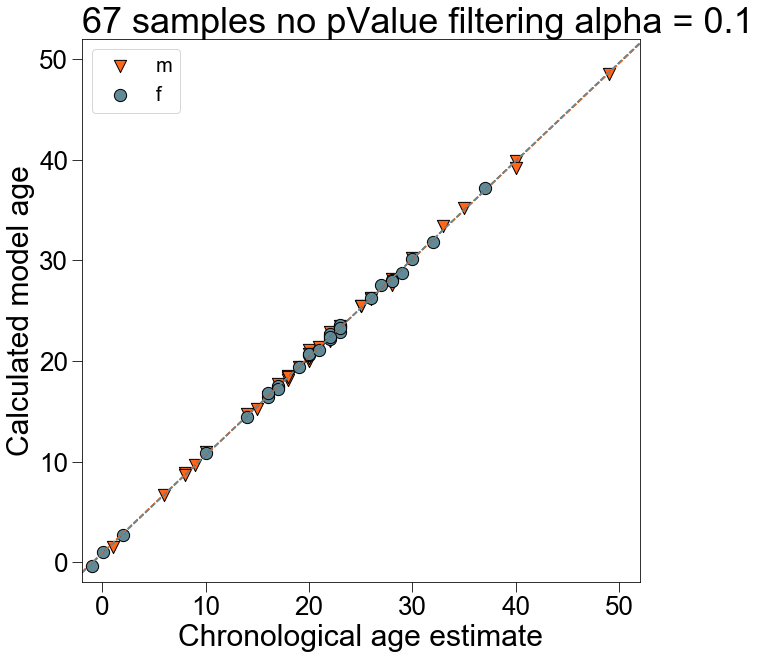

In [22]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a01_model_cpgs.csv'
all_KBO_samp_67_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a01_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a01_clock = make_epigenetic_clock(all_KBO_samp_67_a01_clock_cpgs_path, all_KBO_samp_67_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a01_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a01_clock", 0.1, len(all_KBO_samp_67_a01_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a01_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a01_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.1')

all_KBO_samp_67_a01_clock_stats

The y intercept for this clock model equation is 139.469749898317 .
There are 125 cpgs in the current model
The mean absolute error is 3.4285036359528074
The median absolute error is 3.527407167759062
The mean absolute error for m is 3.4403606354395304
The median absolute error for m is 3.626589006334985
The mean absolute error for f is 3.4147342171940296
The median absolute error for f is 3.3955263279621164
r-squared: 0.9899738533806349
p-value: 1.078430761658798e-66
slope: 0.8924372301971382
y-intercept for regression: 5.645835601278986
r-squared for m : 0.9881647875995563
p-value for m : 2.395750669901432e-34
slope for m : 0.8882180434174317
y-intercept for regression for m : 5.780633962774257
r-squared for f : 0.9928000355858628
p-value for f : 1.2582169258764367e-32
slope for f : 0.8982245732481895
y-intercept for regression for f : 5.476835686317006


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a02_clock    0.2         125  all  3.428504  3.527407   
1  all_KBO_samp_67_a02_clock    0.2         125    m  3.440361  3.626589   
2  all_KBO_samp_67_a02_clock    0.2         125    f  3.414734  3.395526   

   r-squared       p-value  regression_slope  y-intercept  
0   0.989974  1.078431e-66          0.892437     5.645836  
1   0.988165  2.395751e-34          0.888218     5.780634  
2   0.992800  1.258217e-32          0.898225     5.476836

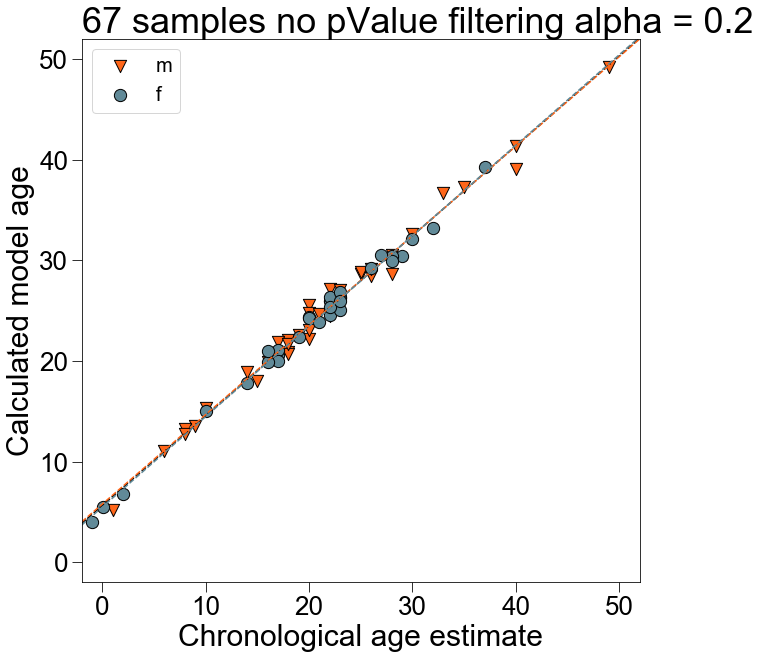

In [32]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a02_model_cpgs.csv'
all_KBO_samp_67_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a02_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a02_clock = make_epigenetic_clock(all_KBO_samp_67_a02_clock_cpgs_path, all_KBO_samp_67_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a02_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a02_clock", 0.2, len(all_KBO_samp_67_a02_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a02_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a02_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.2')

all_KBO_samp_67_a02_clock_stats

The y intercept for this clock model equation is 133.32630901675802 .
There are 96 cpgs in the current model
The mean absolute error is 3.386861459268634
The median absolute error is 3.458698762132453
The mean absolute error for m is 3.3965091087915646
The median absolute error for m is 3.5547725673656476
The mean absolute error for f is 3.375657737242004
The median absolute error for f is 3.3877101486640164
r-squared: 0.9926573087938242
p-value: 4.321769254115414e-71
slope: 0.9060156893429477
y-intercept for regression: 5.334637219925465
r-squared for m : 0.9912286930458724
p-value for m : 1.46861297476051e-36
slope for m : 0.9020964874079553
y-intercept for regression for m : 5.4655984401876125
r-squared for f : 0.9949250936582258
p-value for f : 7.883838519570813e-35
slope for f : 0.9112875834964548
y-intercept for regression for f : 5.173085763238028


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a03_clock    0.3          96  all  3.386861  3.458699   
1  all_KBO_samp_67_a03_clock    0.3          96    m  3.396509  3.554773   
2  all_KBO_samp_67_a03_clock    0.3          96    f  3.375658  3.387710   

   r-squared       p-value  regression_slope  y-intercept  
0   0.992657  4.321769e-71          0.906016     5.334637  
1   0.991229  1.468613e-36          0.902096     5.465598  
2   0.994925  7.883839e-35          0.911288     5.173086

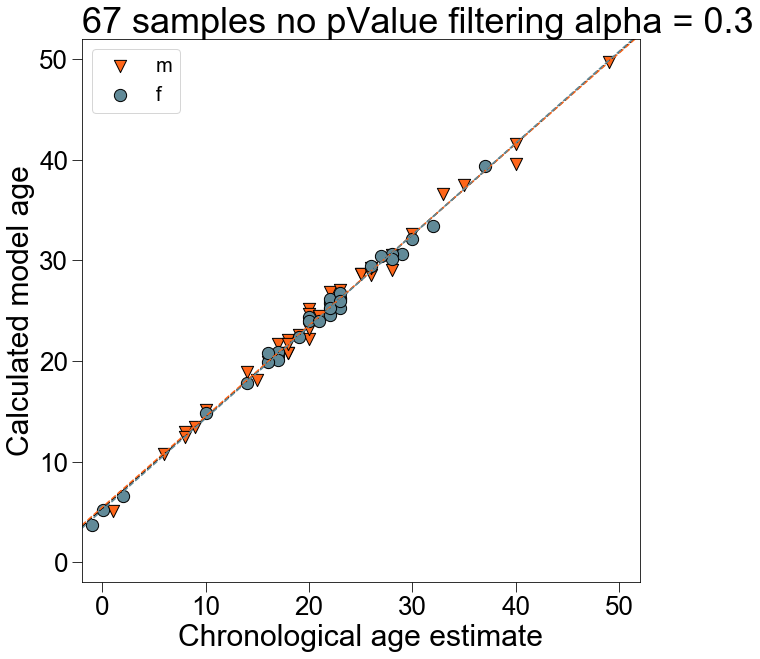

In [23]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a03_model_cpgs.csv'
all_KBO_samp_67_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a03_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a03_clock = make_epigenetic_clock(all_KBO_samp_67_a03_clock_cpgs_path, all_KBO_samp_67_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a03_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a03_clock", 0.3, len(all_KBO_samp_67_a03_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a03_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a03_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.3')

all_KBO_samp_67_a03_clock_stats

The y intercept for this clock model equation is 128.088653754912 .
There are 82 cpgs in the current model
The mean absolute error is 2.641061117521224
The median absolute error is 2.707128850399947
The mean absolute error for m is 2.6708453242336656
The median absolute error for m is 2.7789939863928765
The mean absolute error for f is 2.606473006500326
The median absolute error for f is 2.628996407212931
r-squared: 0.9932741935848862
p-value: 2.494172173682968e-72
slope: 0.9153894608393798
y-intercept for regression: 4.3781977831756365
r-squared for m : 0.9920686961365377
p-value for m : 2.6515417063134503e-37
slope for m : 0.9111119205728854
y-intercept for regression for m : 4.519122628602023
r-squared for f : 0.9952191993208891
p-value for f : 3.316885517507538e-35
slope for f : 0.9211797405219747
y-intercept for regression for f : 4.203473167085733


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a04_clock    0.4          82  all  2.641061  2.707129   
1  all_KBO_samp_67_a04_clock    0.4          82    m  2.670845  2.778994   
2  all_KBO_samp_67_a04_clock    0.4          82    f  2.606473  2.628996   

   r-squared       p-value  regression_slope  y-intercept  
0   0.993274  2.494172e-72          0.915389     4.378198  
1   0.992069  2.651542e-37          0.911112     4.519123  
2   0.995219  3.316886e-35          0.921180     4.203473

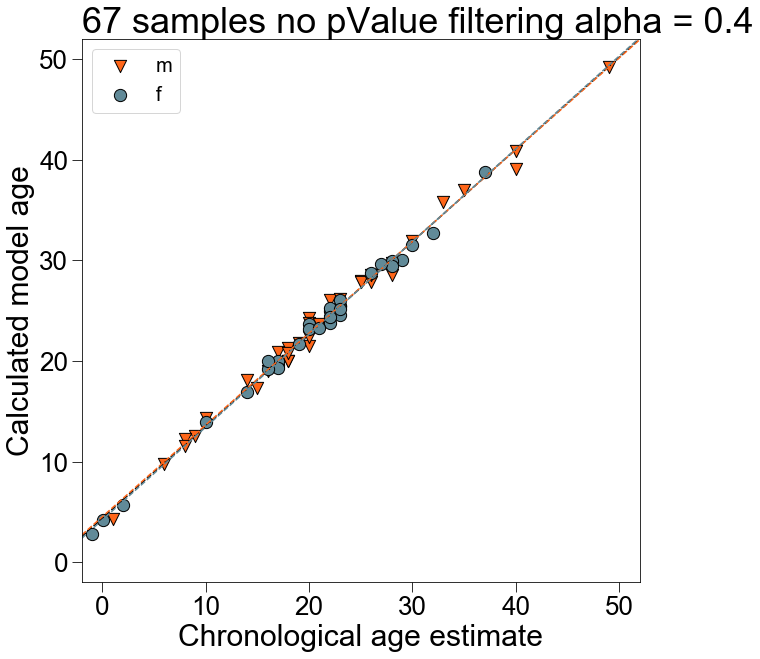

In [24]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a04_model_cpgs.csv'
all_KBO_samp_67_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a04_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a04_clock = make_epigenetic_clock(all_KBO_samp_67_a04_clock_cpgs_path, all_KBO_samp_67_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a04_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a04_clock", 0.4, len(all_KBO_samp_67_a04_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a04_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a04_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.4')

all_KBO_samp_67_a04_clock_stats

The y intercept for this clock model equation is 122.888434075405 .
There are 85 cpgs in the current model
The mean absolute error is 0.37253293418138667
The median absolute error is 0.3385351099687739
The mean absolute error for m is 0.4022167855770405
The median absolute error for m is 0.3727003793688741
The mean absolute error for f is 0.3380613648186917
The median absolute error for f is 0.3322528654666126
r-squared: 0.9994047410596428
p-value: 1.4855290431122398e-106
slope: 0.9786909618316914
y-intercept for regression: 0.7567757042810079
r-squared for m : 0.999318838715999
p-value for m : 1.9879099345860095e-55
slope for m : 0.9771981806993426
y-intercept for regression for m : 0.7995423216130568
r-squared for f : 0.9995447822729266
p-value for f : 5.143612986780988e-50
slope for f : 0.9808276851990139
y-intercept for regression for f : 0.7008972301177714


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a05_clock    0.5          85  all  0.372533  0.338535   
1  all_KBO_samp_67_a05_clock    0.5          85    m  0.402217  0.372700   
2  all_KBO_samp_67_a05_clock    0.5          85    f  0.338061  0.332253   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999405  1.485529e-106          0.978691     0.756776  
1   0.999319   1.987910e-55          0.977198     0.799542  
2   0.999545   5.143613e-50          0.980828     0.700897

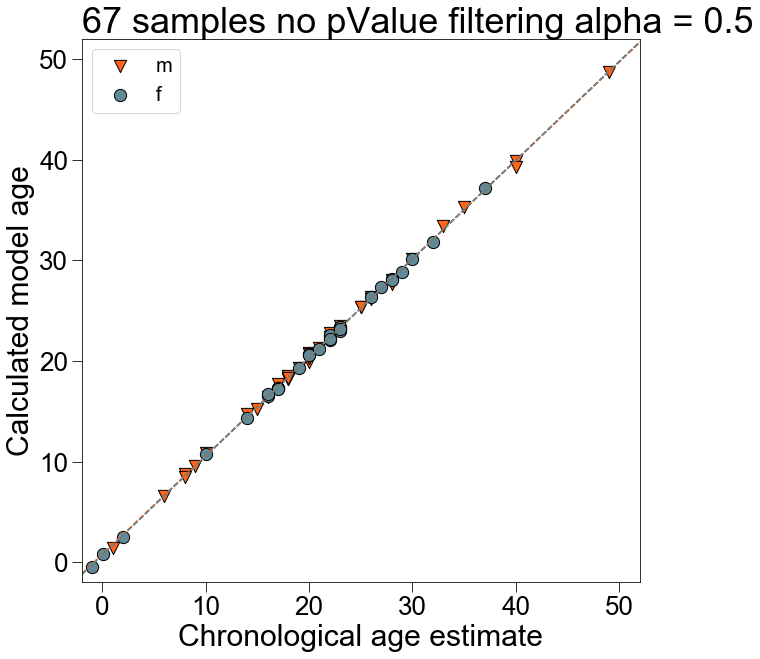

In [25]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a05_model_cpgs.csv'
all_KBO_samp_67_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a05_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a05_clock = make_epigenetic_clock(all_KBO_samp_67_a05_clock_cpgs_path, all_KBO_samp_67_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a05_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a05_clock", 0.5, len(all_KBO_samp_67_a05_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a05_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a05_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.5')

all_KBO_samp_67_a05_clock_stats

The y intercept for this clock model equation is 117.81707017903099 .
There are 82 cpgs in the current model
The mean absolute error is 0.216380799759807
The median absolute error is 0.15621372114177845
The mean absolute error for m is 0.24367440081407463
The median absolute error for m is 0.1602560688628012
The mean absolute error for f is 0.1846850049871091
The median absolute error for f is 0.15442817510838625
r-squared: 0.9993752071187528
p-value: 7.167490212829923e-106
slope: 0.9808438429387969
y-intercept for regression: 0.39687071533384355
r-squared for m : 0.9992898447378594
p-value for m : 4.037938238458725e-55
slope for m : 0.9791652000005151
y-intercept for regression for m : 0.4463171109391588
r-squared for f : 0.9995183306416433
p-value for f : 1.1666928414470523e-49
slope for f : 0.9832220900297135
y-intercept for regression for f : 0.3329580644590564


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a06_clock    0.6          82  all  0.216381  0.156214   
1  all_KBO_samp_67_a06_clock    0.6          82    m  0.243674  0.160256   
2  all_KBO_samp_67_a06_clock    0.6          82    f  0.184685  0.154428   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999375  7.167490e-106          0.980844     0.396871  
1   0.999290   4.037938e-55          0.979165     0.446317  
2   0.999518   1.166693e-49          0.983222     0.332958

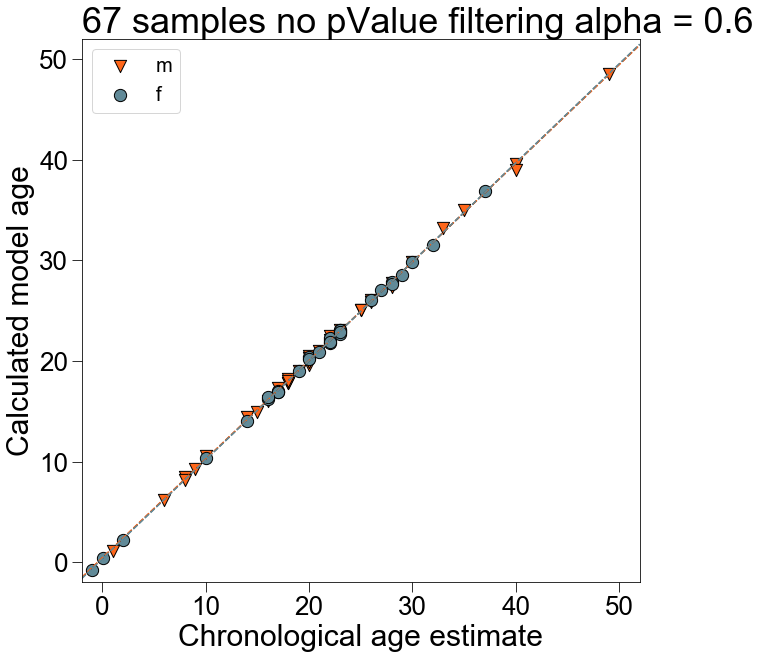

In [26]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a06_model_cpgs.csv'
all_KBO_samp_67_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a06_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a06_clock = make_epigenetic_clock(all_KBO_samp_67_a06_clock_cpgs_path, all_KBO_samp_67_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a06_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a06_clock", 0.6, len(all_KBO_samp_67_a06_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a06_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a06_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.6')

all_KBO_samp_67_a06_clock_stats

The y intercept for this clock model equation is 109.07933702737199 .
There are 69 cpgs in the current model
The mean absolute error is 0.5126180267597622
The median absolute error is 0.383037519973108
The mean absolute error for m is 0.5795462303640592
The median absolute error for m is 0.3875560551768995
The mean absolute error for f is 0.434894951606385
The median absolute error for f is 0.383037519973108
r-squared: 0.9967106295888419
p-value: 1.9983545784315192e-82
slope: 0.9548862673757141
y-intercept for regression: 1.0221777488726431
r-squared for m : 0.9963150924629833
p-value for m : 5.794512068975566e-43
slope for m : 0.9505608174743928
y-intercept for regression for m : 1.1535896219809345
r-squared for f : 0.9974084358604762
p-value for f : 4.615018214991891e-39
slope for f : 0.9609420501531709
y-intercept for regression for f : 0.8543110336983908


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_67_a07_clock    0.7          69  all  0.512618  0.383038   
1  all_KBO_samp_67_a07_clock    0.7          69    m  0.579546  0.387556   
2  all_KBO_samp_67_a07_clock    0.7          69    f  0.434895  0.383038   

   r-squared       p-value  regression_slope  y-intercept  
0   0.996711  1.998355e-82          0.954886     1.022178  
1   0.996315  5.794512e-43          0.950561     1.153590  
2   0.997408  4.615018e-39          0.960942     0.854311

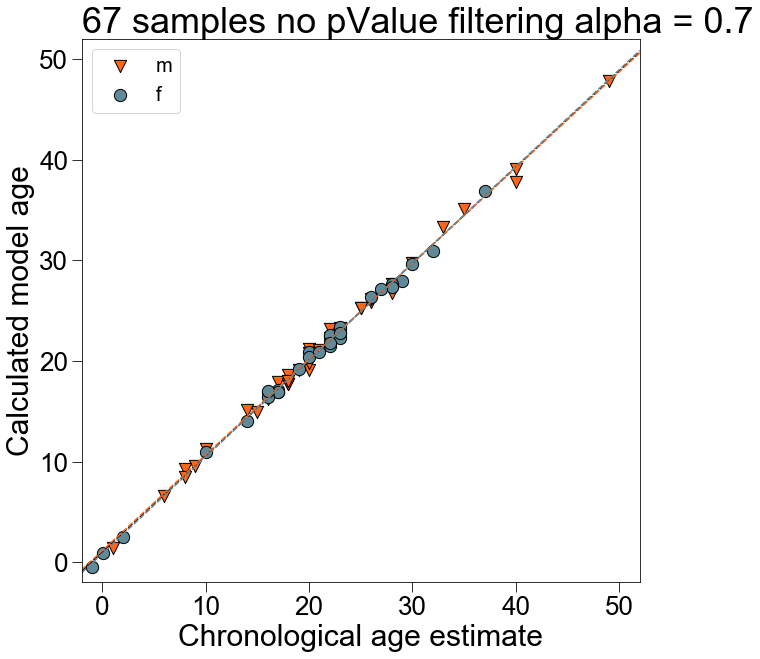

In [27]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a07_model_cpgs.csv'
all_KBO_samp_67_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a07_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a07_clock = make_epigenetic_clock(all_KBO_samp_67_a07_clock_cpgs_path, all_KBO_samp_67_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a07_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a07_clock", 0.7, len(all_KBO_samp_67_a07_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a07_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a07_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.7')

all_KBO_samp_67_a07_clock_stats

The y intercept for this clock model equation is 113.247692316902 .
There are 65 cpgs in the current model
The mean absolute error is 15.035480593101036
The median absolute error is 15.102921335283447
The mean absolute error for m is 15.030776448291894
The median absolute error for m is 15.091027027794812
The mean absolute error for f is 15.04094347094392
The median absolute error for f is 15.102921335283447
r-squared: 0.9943004277891401
p-value: 1.1478643939876929e-74
slope: 0.9464089338969568
y-intercept for regression: 16.153774168006485
r-squared for m : 0.9942582166395231
p-value for m : 1.0914004438710977e-39
slope for m : 0.9493225704889161
y-intercept for regression for m : 16.114710357278963
r-squared for f : 0.9943719182611817
p-value for f : 3.534841507885469e-34
slope for f : 0.9414350537959025
y-intercept for regression for f : 16.227544848711457


clock_info  alpha  clock_size  sex        mae      medae  \
0  all_KBO_samp_67_a08_clock    0.8          65  all  15.035481  15.102921   
1  all_KBO_samp_67_a08_clock    0.8          65    m  15.030776  15.091027   
2  all_KBO_samp_67_a08_clock    0.8          65    f  15.040943  15.102921   

   r-squared       p-value  regression_slope  y-intercept  
0   0.994300  1.147864e-74          0.946409    16.153774  
1   0.994258  1.091400e-39          0.949323    16.114710  
2   0.994372  3.534842e-34          0.941435    16.227545

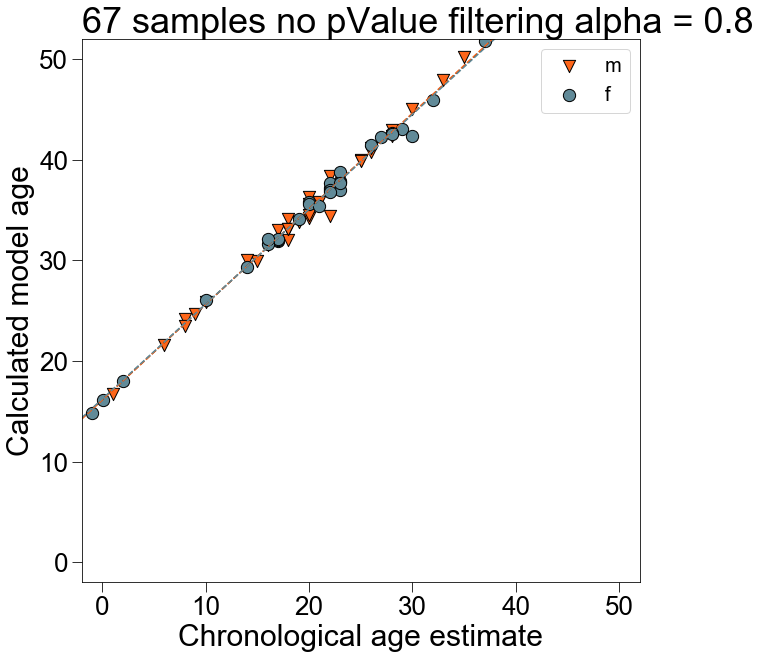

In [28]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a08_model_cpgs.csv'
all_KBO_samp_67_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a08_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a08_clock = make_epigenetic_clock(all_KBO_samp_67_a08_clock_cpgs_path, all_KBO_samp_67_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a08_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a08_clock", 0.8, len(all_KBO_samp_67_a08_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a08_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a08_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.8')

all_KBO_samp_67_a08_clock_stats

The y intercept for this clock model equation is 110.29957990845101 .
There are 59 cpgs in the current model
The mean absolute error is 16.336061968729265
The median absolute error is 16.3824943541361
The mean absolute error for m is 16.334710676555343
The median absolute error for m is 16.381427391189018
The mean absolute error for f is 16.337631211253818
The median absolute error for f is 16.432784376753638
r-squared: 0.9934870398189667
p-value: 8.769770858546858e-73
slope: 0.9434594336761474
y-intercept for regression: 17.51590324898864
r-squared for m : 0.993403307497737
p-value for m : 1.155875163715795e-38
slope for m : 0.946763126519366
y-intercept for regression for m : 17.473388248224452
r-squared for f : 0.9936380007633003
p-value for f : 2.0912286338407306e-33
slope for f : 0.9377875148664915
y-intercept for regression for f : 17.598136434233066


clock_info  alpha  clock_size  sex        mae      medae  \
0  all_KBO_samp_67_a09_clock    0.9          59  all  16.336062  16.382494   
1  all_KBO_samp_67_a09_clock    0.9          59    m  16.334711  16.381427   
2  all_KBO_samp_67_a09_clock    0.9          59    f  16.337631  16.432784   

   r-squared       p-value  regression_slope  y-intercept  
0   0.993487  8.769771e-73          0.943459    17.515903  
1   0.993403  1.155875e-38          0.946763    17.473388  
2   0.993638  2.091229e-33          0.937788    17.598136

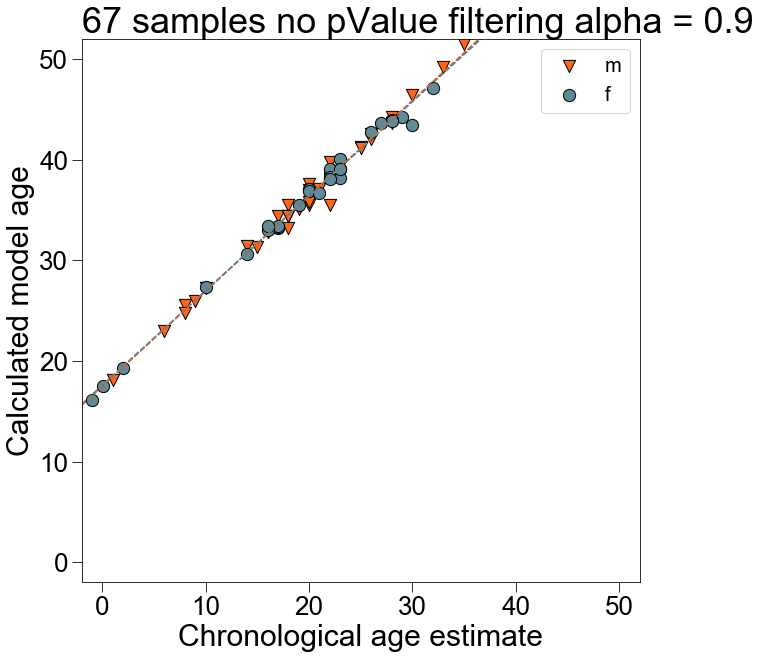

In [29]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a09_model_cpgs.csv'
all_KBO_samp_67_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a09_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a09_clock = make_epigenetic_clock(all_KBO_samp_67_a09_clock_cpgs_path, all_KBO_samp_67_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a09_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a09_clock", 0.9, len(all_KBO_samp_67_a09_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a09_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a09_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 0.9')

all_KBO_samp_67_a09_clock_stats

The y intercept for this clock model equation is 107.42964460426501 .
There are 58 cpgs in the current model
The mean absolute error is 18.047035846281194
The median absolute error is 18.136435087535077
The mean absolute error for m is 18.037292257656542
The median absolute error for m is 18.106098365222582
The mean absolute error for f is 18.058350981458215
The median absolute error for f is 18.146282315620148
r-squared: 0.9944342906747236
p-value: 5.301584708888135e-75
slope: 0.9531605466793818
y-intercept for regression: 19.02444240878204
r-squared for m : 0.9946790244295848
p-value for m : 2.9919424423454915e-40
slope for m : 0.9578926282351845
y-intercept for regression for m : 18.937922153737304
r-squared for f : 0.9940982240980335
p-value for f : 7.0380032911017955e-34
slope for f : 0.9454998549444201
y-intercept for regression for f : 19.162594243052084


clock_info  alpha  clock_size  sex        mae      medae  \
0  all_KBO_samp_67_a1_clock    1.0          58  all  18.047036  18.136435   
1  all_KBO_samp_67_a1_clock    1.0          58    m  18.037292  18.106098   
2  all_KBO_samp_67_a1_clock    1.0          58    f  18.058351  18.146282   

   r-squared       p-value  regression_slope  y-intercept  
0   0.994434  5.301585e-75          0.953161    19.024442  
1   0.994679  2.991942e-40          0.957893    18.937922  
2   0.994098  7.038003e-34          0.945500    19.162594

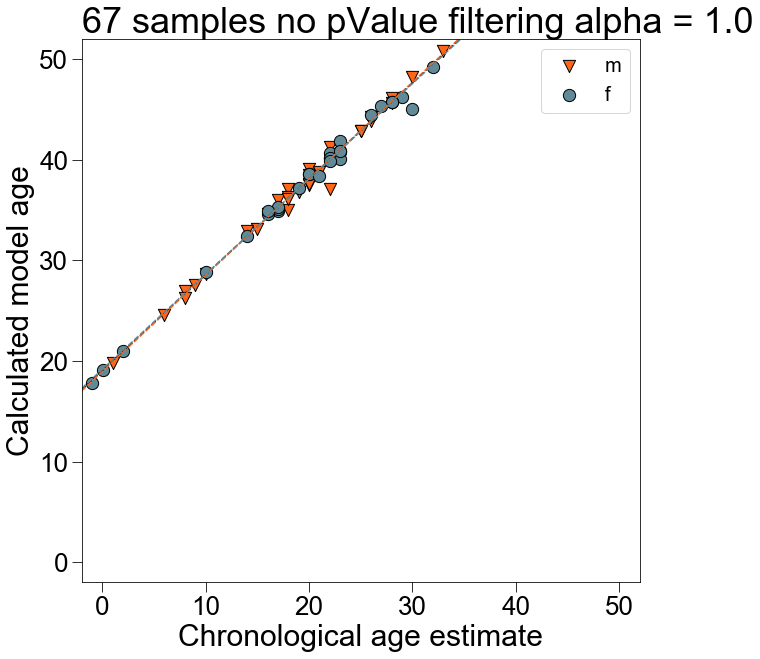

In [30]:
### Using all sites; no filtering
### Using sesame_KBO_samp_67
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_67_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a1_model_cpgs.csv'
all_KBO_samp_67_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_67_a1_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_67_a1_clock = make_epigenetic_clock(all_KBO_samp_67_a1_clock_cpgs_path, all_KBO_samp_67_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_67_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               all_KBO_samp_67_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_67_a1_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_67_a1_clock", 1.0, len(all_KBO_samp_67_a1_clock['cpgs'])-1,
                                                                     all_KBO_samp_67_a1_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_67_fig_a1_sex_specific.eps', 
                                                                     '67 samples no pValue filtering alpha = 1.0')

all_KBO_samp_67_a1_clock_stats

In [33]:

dfs_for_samp_67_no_pvalue_filtering = [all_KBO_samp_67_a01_clock_stats, all_KBO_samp_67_a02_clock_stats,
                                       all_KBO_samp_67_a03_clock_stats, all_KBO_samp_67_a04_clock_stats,
                                       all_KBO_samp_67_a05_clock_stats, all_KBO_samp_67_a06_clock_stats,
                                       all_KBO_samp_67_a07_clock_stats, all_KBO_samp_67_a08_clock_stats,
                                       all_KBO_samp_67_a09_clock_stats, all_KBO_samp_67_a1_clock_stats]
                                       
stats_samp_67_no_pvalue_filtering_clocks = pd.concat(dfs_for_samp_67_no_pvalue_filtering)

stats_samp_67_no_pvalue_filtering_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_67_no_pvalue_filtering_clocks.csv')

stats_samp_67_no_pvalue_filtering_clocks

clock_info  alpha  clock_size  sex        mae      medae  \
0  all_KBO_samp_67_a01_clock    0.1         208  all   0.428557   0.413076   
1  all_KBO_samp_67_a01_clock    0.1         208    m   0.454456   0.431446   
2  all_KBO_samp_67_a01_clock    0.1         208    f   0.398481   0.368107   
0  all_KBO_samp_67_a02_clock    0.2         125  all   3.428504   3.527407   
1  all_KBO_samp_67_a02_clock    0.2         125    m   3.440361   3.626589   
2  all_KBO_samp_67_a02_clock    0.2         125    f   3.414734   3.395526   
0  all_KBO_samp_67_a03_clock    0.3          96  all   3.386861   3.458699   
1  all_KBO_samp_67_a03_clock    0.3          96    m   3.396509   3.554773   
2  all_KBO_samp_67_a03_clock    0.3          96    f   3.375658   3.387710   
0  all_KBO_samp_67_a04_clock    0.4          82  all   2.641061   2.707129   
1  all_KBO_samp_67_a04_clock    0.4          82    m   2.670845   2.778994   
2  all_KBO_samp_67_a04_clock    0.4          82    f   2.606473   2.628996   
0  all_KBO_samp_67_a05_clock    0.5          85  all   0.372533   0.338535   
1  all_KBO_samp_67_a05_clock    0.5          85    m   0.402217   0.372700   
2  all_KBO_samp_67_a05_clock    0.5          85    f   0.338061   0.332253   
0  all_KBO_samp_67_a06_clock    0.6          82  all   0.216381   0.156214   
1  all_KBO_samp_67_a06_clock    0.6          82    m   0.243674   0.160256   
2  all_KBO_samp_67_a06_clock    0.6          82    f   0.184685   0.154428   
0  all_KBO_samp_67_a07_clock    0.7          69  all   0.512618   0.383038   
1  all_KBO_samp_67_a07_clock    0.7          69    m   0.579546   0.387556   
2  all_KBO_samp_67_a07_clock    0.7          69    f   0.434895   0.383038   
0  all_KBO_samp_67_a08_clock    0.8          65  all  15.035481  15.102921   
1  all_KBO_samp_67_a08_clock    0.8          65    m  15.030776  15.091027   
2  all_KBO_samp_67_a08_clock    0.8          65    f  15.040943  15.102921   
0  all_KBO_samp_67_a09_clock    0.9          59  all  16.336062  16.382494   
1  all_KBO_samp_67_a09_clock    0.9          59    m  16.334711  16.381427   
2  all_KBO_samp_67_a09_clock    0.9          59    f  16.337631  16.432784   
0   all_KBO_samp_67_a1_clock    1.0          58  all  18.047036  18.136435   
1   all_KBO_samp_67_a1_clock    1.0          58    m  18.037292  18.106098   
2   all_KBO_samp_67_a1_clock    1.0          58    f  18.058351  18.146282   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999186  3.863180e-102          0.973289     0.903275  
1   0.999096   2.430473e-53          0.971640     0.944228  
2   0.999330   1.408153e-47          0.975763     0.846548  
0   0.989974   1.078431e-66          0.892437     5.645836  
1   0.988165   2.395751e-34          0.888218     5.780634  
2   0.992800   1.258217e-32          0.898225     5.476836  
0   0.992657   4.321769e-71          0.906016     5.334637  
1   0.991229   1.468613e-36          0.902096     5.465598  
2   0.994925   7.883839e-35          0.911288     5.173086  
0   0.993274   2.494172e-72          0.915389     4.378198  
1   0.992069   2.651542e-37          0.911112     4.519123  
2   0.995219   3.316886e-35          0.921180     4.203473  
0   0.999405  1.485529e-106          0.978691     0.756776  
1   0.999319   1.987910e-55          0.977198     0.799542  
2   0.999545   5.143613e-50          0.980828     0.700897  
0   0.999375  7.167490e-106          0.980844     0.396871  
1   0.999290   4.037938e-55          0.979165     0.446317  
2   0.999518   1.166693e-49          0.983222     0.332958  
0   0.996711   1.998355e-82          0.954886     1.022178  
1   0.996315   5.794512e-43          0.950561     1.153590  
2   0.997408   4.615018e-39          0.960942     0.854311  
0   0.994300   1.147864e-74          0.946409    16.153774  
1   0.994258   1.091400e-39          0.949323    16.114710  
2   0.994372   3.534842e-34          0.941435    16.227545  
0   0.993487   8.769771e-73          0.943459    17.515903  
1   0.993403 

In [34]:
all_KBO_samp_67_overall_stats = stats_samp_67_no_pvalue_filtering_clocks[stats_samp_67_no_pvalue_filtering_clocks['sex']=='all']
all_KBO_samp_67_overall_stats

clock_info  alpha  clock_size  sex        mae      medae  \
0  all_KBO_samp_67_a01_clock    0.1         208  all   0.428557   0.413076   
0  all_KBO_samp_67_a02_clock    0.2         125  all   3.428504   3.527407   
0  all_KBO_samp_67_a03_clock    0.3          96  all   3.386861   3.458699   
0  all_KBO_samp_67_a04_clock    0.4          82  all   2.641061   2.707129   
0  all_KBO_samp_67_a05_clock    0.5          85  all   0.372533   0.338535   
0  all_KBO_samp_67_a06_clock    0.6          82  all   0.216381   0.156214   
0  all_KBO_samp_67_a07_clock    0.7          69  all   0.512618   0.383038   
0  all_KBO_samp_67_a08_clock    0.8          65  all  15.035481  15.102921   
0  all_KBO_samp_67_a09_clock    0.9          59  all  16.336062  16.382494   
0   all_KBO_samp_67_a1_clock    1.0          58  all  18.047036  18.136435   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999186  3.863180e-102          0.973289     0.903275  
0   0.989974   1.078431e-66          0.892437     5.645836  
0   0.992657   4.321769e-71          0.906016     5.334637  
0   0.993274   2.494172e-72          0.915389     4.378198  
0   0.999405  1.485529e-106          0.978691     0.756776  
0   0.999375  7.167490e-106          0.980844     0.396871  
0   0.996711   1.998355e-82          0.954886     1.022178  
0   0.994300   1.147864e-74          0.946409    16.153774  
0   0.993487   8.769771e-73          0.943459    17.515903  
0   0.994434   5.301585e-75          0.953161    19.024442

In [1]:
#Make some summary figures to better understand the variability across all the clocks

fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(all_KBO_samp_67_overall_stats['alpha'], all_KBO_samp_67_overall_stats['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)


plt.subplot(222)
plt.scatter(all_KBO_samp_67_overall_stats['alpha'], all_KBO_samp_67_overall_stats['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)


plt.subplot(223)
plt.scatter(all_KBO_samp_67_overall_stats['alpha'], all_KBO_samp_67_overall_stats['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.xlabel('alpha')

plt.subplot(224)
plt.scatter(all_KBO_samp_67_overall_stats['alpha'], all_KBO_samp_67_overall_stats['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)
plt.ylim([0.6,1])
plt.xlabel('alpha')

fig.suptitle('No Filter - "full clock"for n = 67', fontsize = 26)

fig.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/compare_noFilter_clocks_overall_stats.pdf')

NameError: name 'plt' is not defined

# P Value Filtered Clocks 

## Remove probes with bad pValues for all 

The y intercept for this clock model equation is 127.03311057252701 .
There are 136 cpgs in the current model
The mean absolute error is 3.4360253457648464
The median absolute error is 3.160274434702643
The mean absolute error for m is 3.6912984260854844
The median absolute error for m is 3.495543462229012
The mean absolute error for f is 3.139579187973138
The median absolute error for f is 2.9156389676796124
r-squared: 0.941617483641355
p-value: 8.140782230882403e-42
slope: 0.7760649952731431
y-intercept for regression: 7.547675684628516
r-squared for m : 0.9365816068334808
p-value for m : 6.082478612769629e-22
slope for m : 0.7626777712556029
y-intercept for regression for m : 7.973034698308993
r-squared for f : 0.9500125155844392
p-value for f : 2.045914776672336e-20
slope for f : 0.7944703613953821
y-intercept for regression for f : 7.013315282681109


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a01_clock    0.1         136  all  3.436025   
1  samp_67_bad_pValue_removed_a01_clock    0.1         136    m  3.691298   
2  samp_67_bad_pValue_removed_a01_clock    0.1         136    f  3.139579   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.160274   0.941617  8.140782e-42          0.776065     7.547676  
1  3.495543   0.936582  6.082479e-22          0.762678     7.973035  
2  2.915639   0.950013  2.045915e-20          0.794470     7.013315

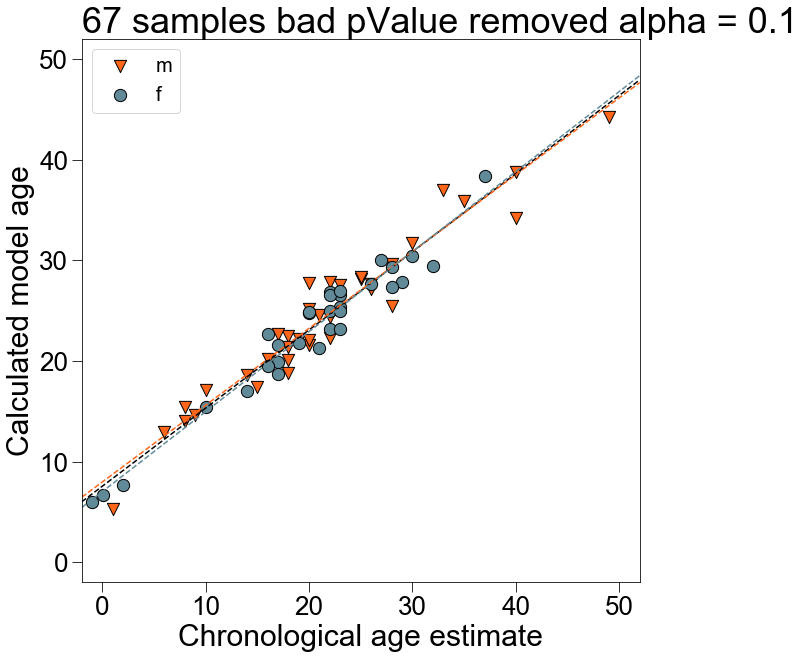

In [36]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a01_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a01_clock_cpgs_path, samp_67_bad_pValue_removed_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a01_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a01_clock", 0.1, len(samp_67_bad_pValue_removed_a01_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a01_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a01_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.1')
samp_67_bad_pValue_removed_a01_clock_stats

The y intercept for this clock model equation is 103.36567770036699 .
There are 74 cpgs in the current model
The mean absolute error is 4.211605262115128
The median absolute error is 3.9924926991495973
The mean absolute error for m is 4.494722833295713
The median absolute error for m is 4.391861043290081
The mean absolute error for f is 3.8828235665505786
The median absolute error for f is 3.600605107873392
r-squared: 0.9263688626749279
p-value: 1.5467011166032616e-38
slope: 0.7311362607798818
y-intercept for regression: 9.264052073522501
r-squared for m : 0.920427598910192
p-value for m : 2.9036057847497455e-20
slope for m : 0.7151754629859554
y-intercept for regression for m : 9.766523138536513
r-squared for f : 0.9365906157829231
p-value for f : 6.478963496094431e-19
slope for f : 0.7531641852803665
y-intercept for regression for f : 8.630668737460073


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a02_clock    0.2          74  all  4.211605   
1  samp_67_bad_pValue_removed_a02_clock    0.2          74    m  4.494723   
2  samp_67_bad_pValue_removed_a02_clock    0.2          74    f  3.882824   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.992493   0.926369  1.546701e-38          0.731136     9.264052  
1  4.391861   0.920428  2.903606e-20          0.715175     9.766523  
2  3.600605   0.936591  6.478963e-19          0.753164     8.630669

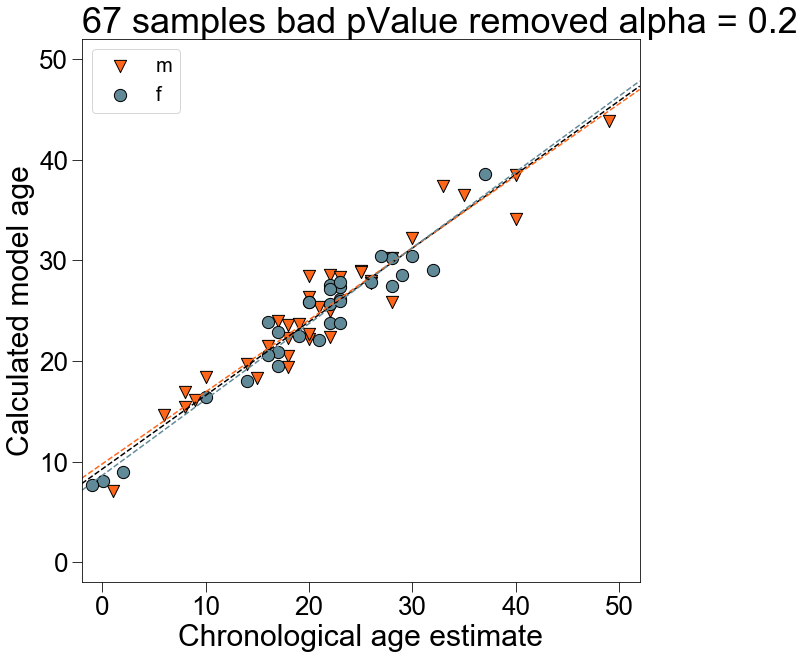

In [37]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a02_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a02_clock_cpgs_path, samp_67_bad_pValue_removed_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a02_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a02_clock", 0.2, len(samp_67_bad_pValue_removed_a02_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a02_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a02_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.2')
samp_67_bad_pValue_removed_a02_clock_stats

The y intercept for this clock model equation is 98.2829491908112 .
There are 56 cpgs in the current model
The mean absolute error is 4.574321501433737
The median absolute error is 4.514109627649752
The mean absolute error for m is 4.866602812752912
The median absolute error for m is 4.578472225753501
The mean absolute error for f is 4.234898043127597
The median absolute error for f is 4.071717068362297
r-squared: 0.928981339615407
p-value: 4.774422872876744e-39
slope: 0.7346053090393928
y-intercept for regression: 9.661128435481062
r-squared for m : 0.922727528844791
p-value for m : 1.7615208571240713e-20
slope for m : 0.7173776343274807
y-intercept for regression for m : 10.211023701369264
r-squared for f : 0.940148676505977
p-value for f : 2.799506339030166e-19
slope for f : 0.7582452639875326
y-intercept for regression for f : 8.971477604941402


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a03_clock    0.3          56  all  4.574322   
1  samp_67_bad_pValue_removed_a03_clock    0.3          56    m  4.866603   
2  samp_67_bad_pValue_removed_a03_clock    0.3          56    f  4.234898   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  4.514110   0.928981  4.774423e-39          0.734605     9.661128  
1  4.578472   0.922728  1.761521e-20          0.717378    10.211024  
2  4.071717   0.940149  2.799506e-19          0.758245     8.971478

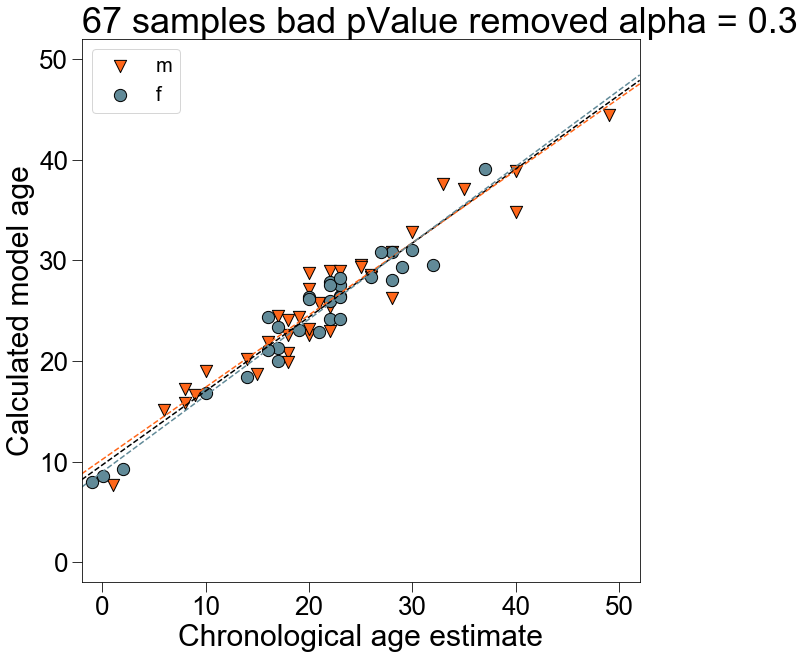

In [38]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a03_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a03_clock_cpgs_path, samp_67_bad_pValue_removed_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a03_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a03_clock", 0.3, len(samp_67_bad_pValue_removed_a03_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a03_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a03_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.3')
samp_67_bad_pValue_removed_a03_clock_stats

The y intercept for this clock model equation is 89.13634232536242 .
There are 42 cpgs in the current model
The mean absolute error is 4.601065905856681
The median absolute error is 4.359775543070143
The mean absolute error for m is 4.902395363831578
The median absolute error for m is 4.665123689483769
The mean absolute error for f is 4.251134922401959
The median absolute error for f is 4.125548477842095
r-squared: 0.9247730091585108
p-value: 3.107525374552163e-38
slope: 0.7210601460151376
y-intercept for regression: 9.92092279358647
r-squared for m : 0.9180348144923316
p-value for m : 4.810691295316125e-20
slope for m : 0.7024363584482746
y-intercept for regression for m : 10.50350725080859
r-squared for f : 0.936906669880583
p-value for f : 6.025193909923477e-19
slope for f : 0.7468306624858179
y-intercept for regression for f : 9.184820037820447


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a04_clock    0.4          42  all  4.601066   
1  samp_67_bad_pValue_removed_a04_clock    0.4          42    m  4.902395   
2  samp_67_bad_pValue_removed_a04_clock    0.4          42    f  4.251135   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  4.359776   0.924773  3.107525e-38          0.721060     9.920923  
1  4.665124   0.918035  4.810691e-20          0.702436    10.503507  
2  4.125548   0.936907  6.025194e-19          0.746831     9.184820

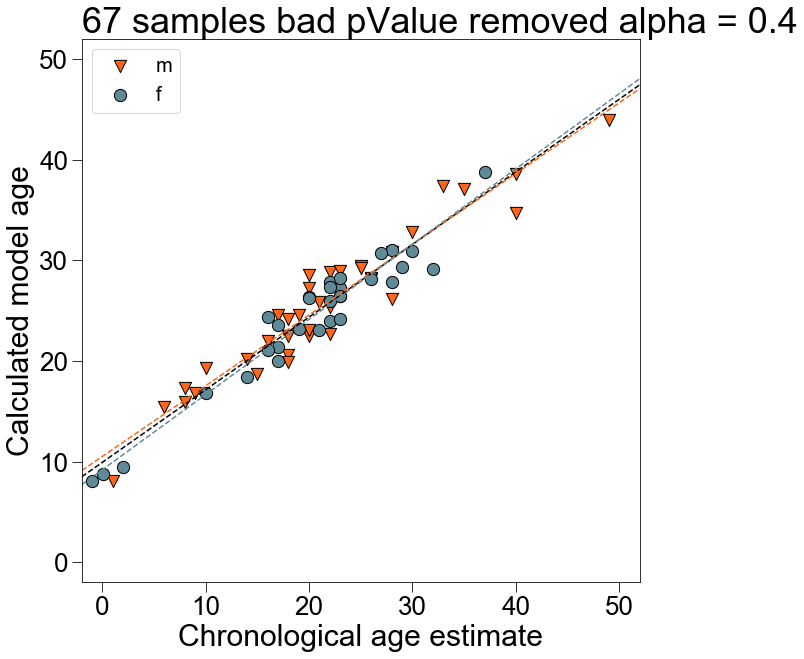

In [39]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a04_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a04_clock_cpgs_path, samp_67_bad_pValue_removed_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a04_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a04_clock", 0.4, len(samp_67_bad_pValue_removed_a04_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a04_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a04_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.4')
samp_67_bad_pValue_removed_a04_clock_stats

The y intercept for this clock model equation is 86.1690460144888 .
There are 35 cpgs in the current model
The mean absolute error is 4.4201641330725145
The median absolute error is 4.106380239828752
The mean absolute error for m is 4.73794369091518
The median absolute error for m is 4.476159097313163
The mean absolute error for f is 4.051129807835871
The median absolute error for f is 3.826938318215653
r-squared: 0.9252280163982965
p-value: 2.550825148761872e-38
slope: 0.7255401970771562
y-intercept for regression: 9.620302085722667
r-squared for m : 0.9186437685271976
p-value for m : 4.236584384340887e-20
slope for m : 0.7055970258856658
y-intercept for regression for m : 10.243792227977254
r-squared for f : 0.9375350126210211
p-value for f : 5.2096297302269165e-19
slope for f : 0.7531430380319702
y-intercept for regression for f : 8.832342482256983


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a05_clock    0.5          35  all  4.420164   
1  samp_67_bad_pValue_removed_a05_clock    0.5          35    m  4.737944   
2  samp_67_bad_pValue_removed_a05_clock    0.5          35    f  4.051130   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  4.106380   0.925228  2.550825e-38          0.725540     9.620302  
1  4.476159   0.918644  4.236584e-20          0.705597    10.243792  
2  3.826938   0.937535  5.209630e-19          0.753143     8.832342

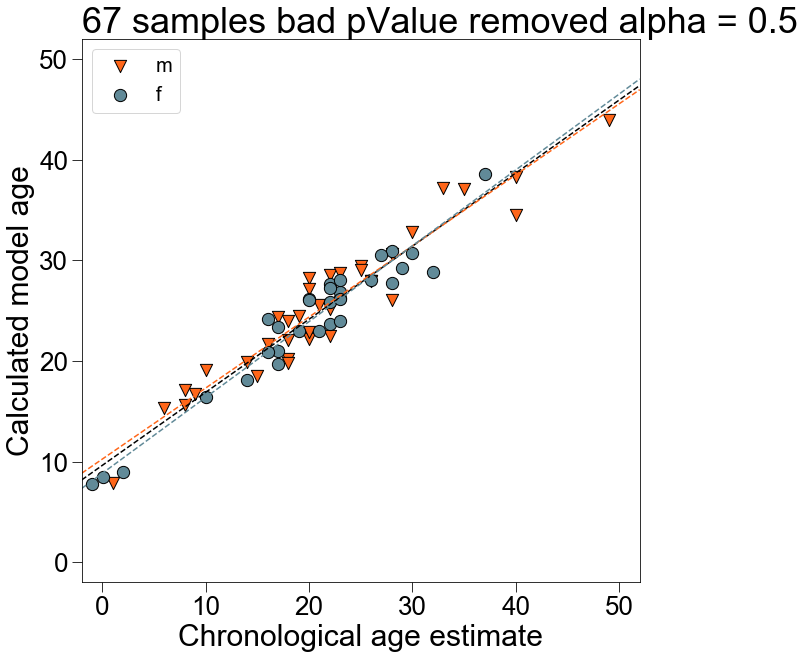

In [40]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a05_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a05_clock_cpgs_path, samp_67_bad_pValue_removed_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a05_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a05_clock", 0.5, len(samp_67_bad_pValue_removed_a05_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a05_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a05_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.5')
samp_67_bad_pValue_removed_a05_clock_stats

The y intercept for this clock model equation is 84.1960832332954 .
There are 30 cpgs in the current model
The mean absolute error is 3.8936646020672723
The median absolute error is 3.3883073542011743
The mean absolute error for m is 4.235771199308107
The median absolute error for m is 3.7896148906670675
The mean absolute error for f is 3.4963795214004953
The median absolute error for f is 3.284911262605643
r-squared: 0.9257189374250929
p-value: 2.0587014842713104e-38
slope: 0.7320905654971015
y-intercept for regression: 8.840266115142198
r-squared for m : 0.9192498882957246
p-value for m : 3.7296702830470436e-20
slope for m : 0.7110604403089194
y-intercept for regression for m : 9.494741766641448
r-squared for f : 0.9381321912891567
p-value for f : 4.530906796610031e-19
slope for f : 0.7612520372483836
y-intercept for regression for f : 8.011742003334023


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a06_clock    0.6          30  all  3.893665   
1  samp_67_bad_pValue_removed_a06_clock    0.6          30    m  4.235771   
2  samp_67_bad_pValue_removed_a06_clock    0.6          30    f  3.496380   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.388307   0.925719  2.058701e-38          0.732091     8.840266  
1  3.789615   0.919250  3.729670e-20          0.711060     9.494742  
2  3.284911   0.938132  4.530907e-19          0.761252     8.011742

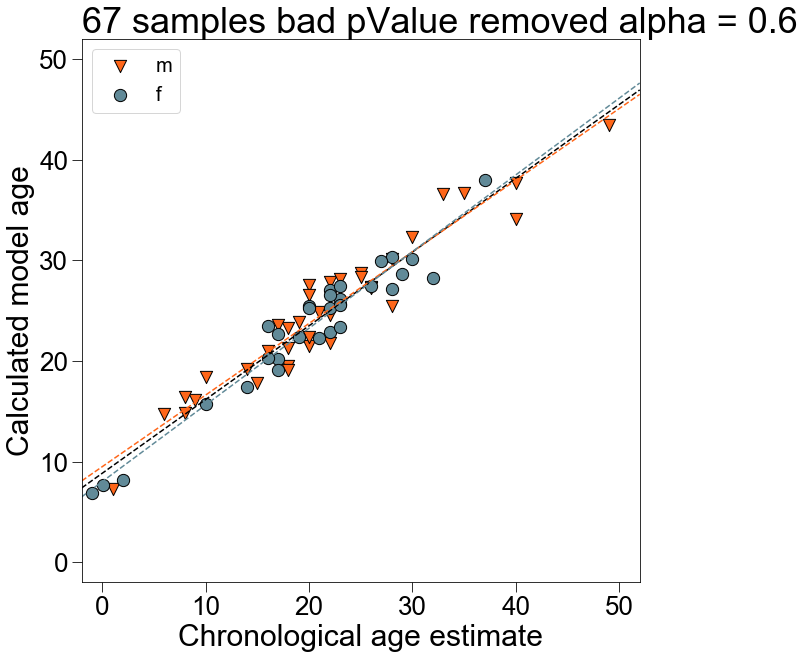

In [41]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a06_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a06_clock_cpgs_path, samp_67_bad_pValue_removed_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a06_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a06_clock", 0.6, len(samp_67_bad_pValue_removed_a06_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a06_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a06_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.6')
samp_67_bad_pValue_removed_a06_clock_stats

The y intercept for this clock model equation is 82.7205865829618 .
There are 27 cpgs in the current model
The mean absolute error is 3.3126894029986946
The median absolute error is 2.8868190942416874
The mean absolute error for m is 3.659245426602349
The median absolute error for m is 3.1118144605925337
The mean absolute error for f is 2.9102372465557402
The median absolute error for f is 2.4978436267805932
r-squared: 0.9257222850197114
p-value: 2.05568471913366e-38
slope: 0.7388658608428071
y-intercept for regression: 7.92348118430122
r-squared for m : 0.9193888523215336
p-value for m : 3.621788715170707e-20
slope for m : 0.7170470391335004
y-intercept for regression for m : 8.60053278343521
r-squared for f : 0.9381171810020855
p-value for f : 4.546906424598641e-19
slope for f : 0.7691566004277202
y-intercept for regression for f : 7.065449623464403


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a07_clock    0.7          27  all  3.312689   
1  samp_67_bad_pValue_removed_a07_clock    0.7          27    m  3.659245   
2  samp_67_bad_pValue_removed_a07_clock    0.7          27    f  2.910237   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.886819   0.925722  2.055685e-38          0.738866     7.923481  
1  3.111814   0.919389  3.621789e-20          0.717047     8.600533  
2  2.497844   0.938117  4.546906e-19          0.769157     7.065450

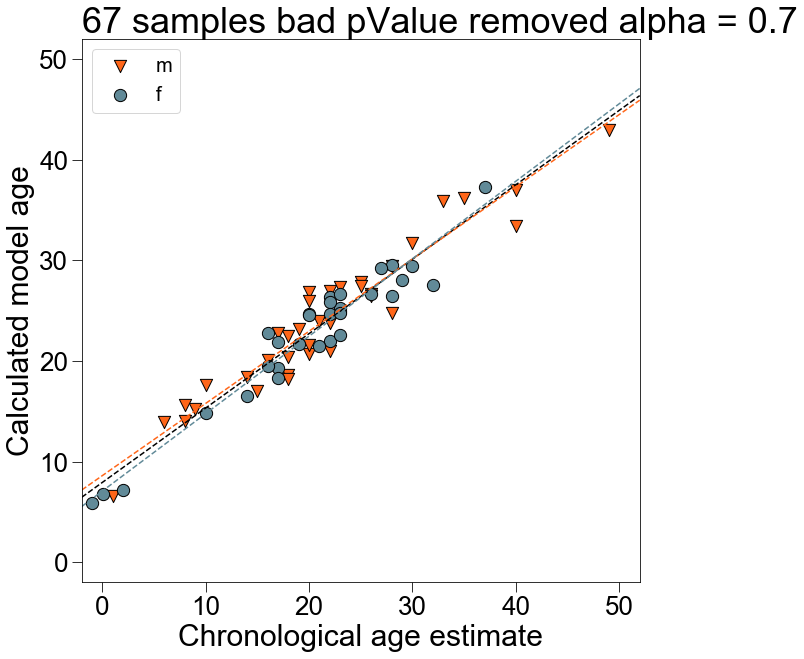

In [42]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a07_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a07_clock_cpgs_path, samp_67_bad_pValue_removed_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a07_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a07_clock", 0.7, len(samp_67_bad_pValue_removed_a07_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a07_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a07_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.7')
samp_67_bad_pValue_removed_a07_clock_stats

The y intercept for this clock model equation is 81.0198283353643 .
There are 26 cpgs in the current model
The mean absolute error is 2.6839106310731977
The median absolute error is 2.240672836300387
The mean absolute error for m is 3.000302918702145
The median absolute error for m is 2.998995142390468
The mean absolute error for f is 2.316487329310549
The median absolute error for f is 1.6959935560187596
r-squared: 0.9252988529965793
p-value: 2.473355630741331e-38
slope: 0.7475067759261786
y-intercept for regression: 6.607181899745152
r-squared for m : 0.919281587271444
p-value for m : 3.7047984323443745e-20
slope for m : 0.7248714023384739
y-intercept for regression for m : 7.310267079186966
r-squared for f : 0.9374492398372879
p-value for f : 5.314549219101401e-19
slope for f : 0.7789185406263809
y-intercept for regression for f : 5.71648647375903


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a08_clock    0.8          26  all  2.683911   
1  samp_67_bad_pValue_removed_a08_clock    0.8          26    m  3.000303   
2  samp_67_bad_pValue_removed_a08_clock    0.8          26    f  2.316487   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.240673   0.925299  2.473356e-38          0.747507     6.607182  
1  2.998995   0.919282  3.704798e-20          0.724871     7.310267  
2  1.695994   0.937449  5.314549e-19          0.778919     5.716486

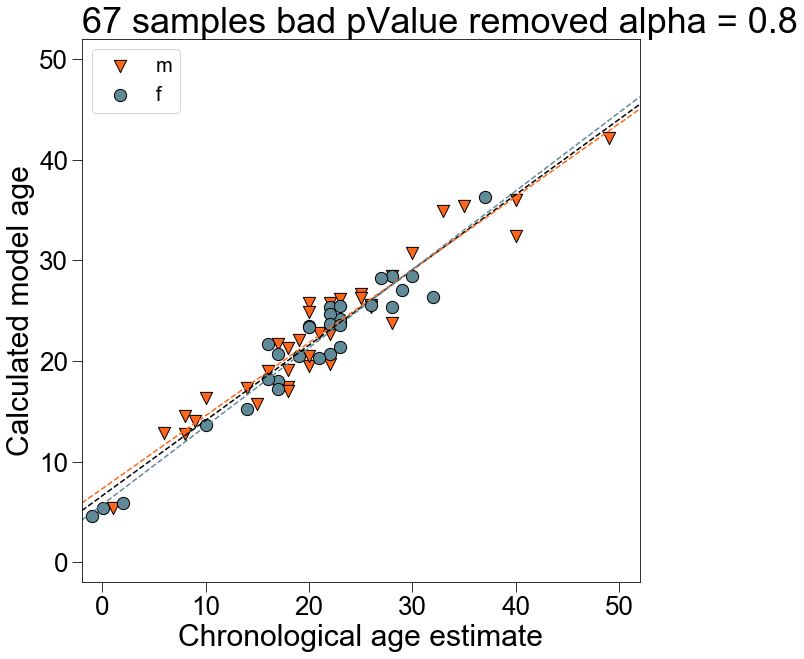

In [43]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a08_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a08_clock_cpgs_path, samp_67_bad_pValue_removed_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a08_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a08_clock", 0.8, len(samp_67_bad_pValue_removed_a08_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a08_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a08_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.8')
samp_67_bad_pValue_removed_a08_clock_stats

The y intercept for this clock model equation is 77.9708623015579 .
There are 23 cpgs in the current model
The mean absolute error is 2.339072681393898
The median absolute error is 1.9653049682994777
The mean absolute error for m is 2.6414267935737534
The median absolute error for m is 1.9594405631128682
The mean absolute error for f is 1.9879517769269694
The median absolute error for f is 2.0638959000065498
r-squared: 0.9244947856342317
p-value: 3.5041582651354496e-38
slope: 0.7564678015752714
y-intercept for regression: 5.169541067582797
r-squared for m : 0.9185655270442669
p-value for m : 4.306556844213503e-20
slope for m : 0.7334346215869231
y-intercept for regression for m : 5.893141435764358
r-squared for f : 0.9366930334402019
p-value for f : 6.328546154619511e-19
slope for f : 0.788284015810035
y-intercept for regression for f : 4.2567078797001106


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a09_clock    0.9          23  all  2.339073   
1  samp_67_bad_pValue_removed_a09_clock    0.9          23    m  2.641427   
2  samp_67_bad_pValue_removed_a09_clock    0.9          23    f  1.987952   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  1.965305   0.924495  3.504158e-38          0.756468     5.169541  
1  1.959441   0.918566  4.306557e-20          0.733435     5.893141  
2  2.063896   0.936693  6.328546e-19          0.788284     4.256708

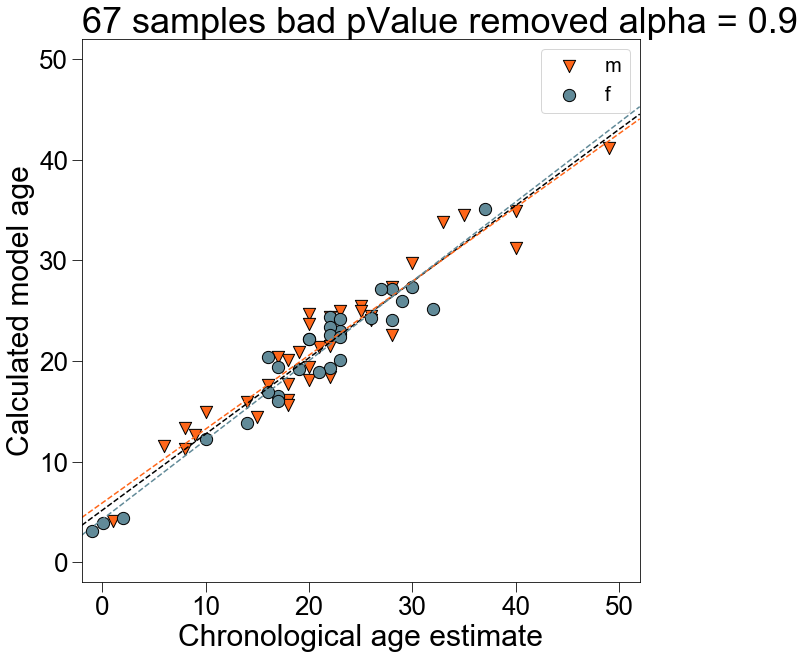

In [44]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a09_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a09_clock_cpgs_path, samp_67_bad_pValue_removed_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a09_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a09_clock", 0.9, len(samp_67_bad_pValue_removed_a09_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a09_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a09_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 0.9')
samp_67_bad_pValue_removed_a09_clock_stats

The y intercept for this clock model equation is 76.3952716542763 .
There are 20 cpgs in the current model
The mean absolute error is 2.333770357346814
The median absolute error is 2.0109303384386834
The mean absolute error for m is 2.6293818294899816
The median absolute error for m is 1.955913459811864
The mean absolute error for f is 1.990479615503135
The median absolute error for f is 2.0186312117961585
r-squared: 0.9240756006505425
p-value: 4.195876335863145e-38
slope: 0.7583392087008989
y-intercept for regression: 5.048735837782408
r-squared for m : 0.918099475505812
p-value for m : 4.7464234022691706e-20
slope for m : 0.7349930836158538
y-intercept for regression for m : 5.787977363333896
r-squared for f : 0.9365337500696481
p-value for f : 6.563911200216061e-19
slope for f : 0.7904825971681617
y-intercept for regression for f : 4.118882905503167


clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a1_clock    1.0          20  all  2.333770   
1  samp_67_bad_pValue_removed_a1_clock    1.0          20    m  2.629382   
2  samp_67_bad_pValue_removed_a1_clock    1.0          20    f  1.990480   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.010930   0.924076  4.195876e-38          0.758339     5.048736  
1  1.955913   0.918099  4.746423e-20          0.734993     5.787977  
2  2.018631   0.936534  6.563911e-19          0.790483     4.118883

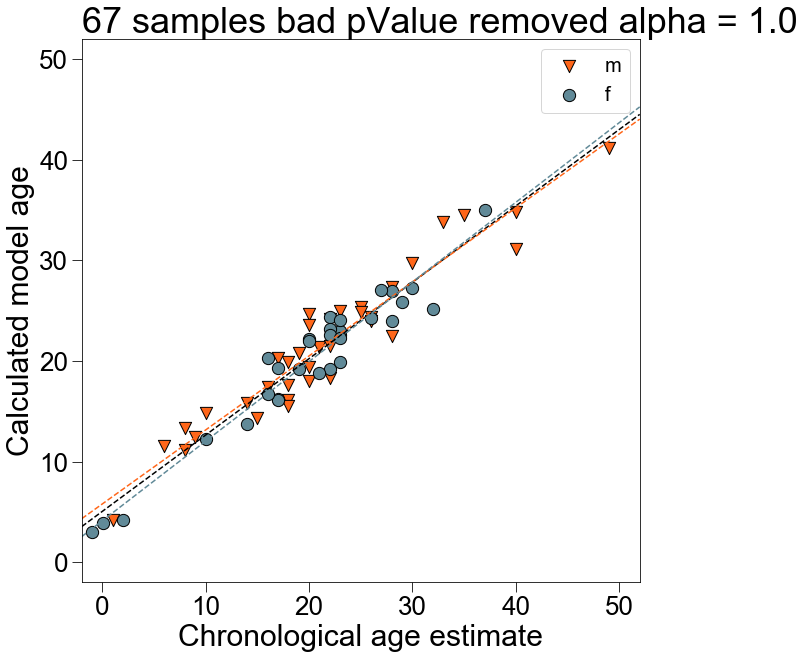

In [45]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_bad_pValue_removed_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_bad_pvalue_removed_model_cpgs.csv'
samp_67_bad_pValue_removed_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_bad_pValue_removed_a1_clock = make_epigenetic_clock(samp_67_bad_pValue_removed_a1_clock_cpgs_path, samp_67_bad_pValue_removed_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_bad_pValue_removed_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_bad_pValue_removed_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_bad_pValue_removed_a1_clock_stats = sex_specific_clock_plots_and_stats("samp_67_bad_pValue_removed_a1_clock", 1.0, len(samp_67_bad_pValue_removed_a1_clock['cpgs'])-1,
                                                                                samp_67_bad_pValue_removed_a1_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_bad_pValue_removed_a1_sex_specific.eps', 
                                                                                '67 samples bad pValue removed alpha = 1.0')
samp_67_bad_pValue_removed_a1_clock_stats

In [46]:

dfs_for_samp_67_bad_pValue_removed = [samp_67_bad_pValue_removed_a01_clock_stats, samp_67_bad_pValue_removed_a02_clock_stats,
                                      samp_67_bad_pValue_removed_a03_clock_stats, samp_67_bad_pValue_removed_a04_clock_stats,
                                      samp_67_bad_pValue_removed_a05_clock_stats, samp_67_bad_pValue_removed_a06_clock_stats,
                                      samp_67_bad_pValue_removed_a07_clock_stats, samp_67_bad_pValue_removed_a08_clock_stats,
                                      samp_67_bad_pValue_removed_a09_clock_stats, samp_67_bad_pValue_removed_a1_clock_stats]

stats_samp_67_bad_pValue_removed_clocks = pd.concat(dfs_for_samp_67_bad_pValue_removed)

stats_samp_67_bad_pValue_removed_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_67_bad_pValue_removed_clocks.csv')
stats_samp_67_bad_pValue_removed_clocks

clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a01_clock    0.1         136  all  3.436025   
1  samp_67_bad_pValue_removed_a01_clock    0.1         136    m  3.691298   
2  samp_67_bad_pValue_removed_a01_clock    0.1         136    f  3.139579   
0  samp_67_bad_pValue_removed_a02_clock    0.2          74  all  4.211605   
1  samp_67_bad_pValue_removed_a02_clock    0.2          74    m  4.494723   
2  samp_67_bad_pValue_removed_a02_clock    0.2          74    f  3.882824   
0  samp_67_bad_pValue_removed_a03_clock    0.3          56  all  4.574322   
1  samp_67_bad_pValue_removed_a03_clock    0.3          56    m  4.866603   
2  samp_67_bad_pValue_removed_a03_clock    0.3          56    f  4.234898   
0  samp_67_bad_pValue_removed_a04_clock    0.4          42  all  4.601066   
1  samp_67_bad_pValue_removed_a04_clock    0.4          42    m  4.902395   
2  samp_67_bad_pValue_removed_a04_clock    0.4          42    f  4.251135   
0  samp_67_bad_pValue_removed_a05_clock    0.5          35  all  4.420164   
1  samp_67_bad_pValue_removed_a05_clock    0.5          35    m  4.737944   
2  samp_67_bad_pValue_removed_a05_clock    0.5          35    f  4.051130   
0  samp_67_bad_pValue_removed_a06_clock    0.6          30  all  3.893665   
1  samp_67_bad_pValue_removed_a06_clock    0.6          30    m  4.235771   
2  samp_67_bad_pValue_removed_a06_clock    0.6          30    f  3.496380   
0  samp_67_bad_pValue_removed_a07_clock    0.7          27  all  3.312689   
1  samp_67_bad_pValue_removed_a07_clock    0.7          27    m  3.659245   
2  samp_67_bad_pValue_removed_a07_clock    0.7          27    f  2.910237   
0  samp_67_bad_pValue_removed_a08_clock    0.8          26  all  2.683911   
1  samp_67_bad_pValue_removed_a08_clock    0.8          26    m  3.000303   
2  samp_67_bad_pValue_removed_a08_clock    0.8          26    f  2.316487   
0  samp_67_bad_pValue_removed_a09_clock    0.9          23  all  2.339073   
1  samp_67_bad_pValue_removed_a09_clock    0.9          23    m  2.641427   
2  samp_67_bad_pValue_removed_a09_clock    0.9          23    f  1.987952   
0   samp_67_bad_pValue_removed_a1_clock    1.0          20  all  2.333770   
1   samp_67_bad_pValue_removed_a1_clock    1.0          20    m  2.629382   
2   samp_67_bad_pValue_removed_a1_clock    1.0          20    f  1.990480   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.160274   0.941617  8.140782e-42          0.776065     7.547676  
1  3.495543   0.936582  6.082479e-22          0.762678     7.973035  
2  2.915639   0.950013  2.045915e-20          0.794470     7.013315  
0  3.992493   0.926369  1.546701e-38          0.731136     9.264052  
1  4.391861   0.920428  2.903606e-20          0.715175     9.766523  
2  3.600605   0.936591  6.478963e-19          0.753164     8.630669  
0  4.514110   0.928981  4.774423e-39          0.734605     9.661128  
1  4.578472   0.922728  1.761521e-20          0.717378    10.211024  
2  4.071717   0.940149  2.799506e-19          0.758245     8.971478  
0  4.359776   0.924773  3.107525e-38          0.721060     9.920923  
1  4.665124   0.918035  4.810691e-20          0.702436    10.503507  
2  4.125548   0.936907  6.025194e-19          0.746831     9.184820  
0  4.106380   0.925228  2.550825e-38          0.725540     9.620302  
1  4.476159   0.918644  4.236584e-20          0.705597    10.243792  
2  3.826938   0.937535  5.209630e-19          0.753143     8.832342  
0  3.388307   0.925719  2.058701e-38          0.732091     8.840266  
1  3.789615   0.919250  3.729670e-20          0.711060     9.494742  
2  3.284911   0.938132  4.530907e-19          0.761252     8.011742  
0  2.886819   0.925722  2.055685e-38          0.738866     7.923481  
1  3.111814   0.919389  3.621789e-20          0.717047     8.600533  
2  2.497844   0.938117  4.546906e-19          0.769157     7.065450  
0  2.240673   0.925299  2.473356e-38          0.747507     6.607182  
1  2.998995   0.919282  3.70479

In [47]:
overall_stats_samp_67_bad_pValue_removed_clocks = stats_samp_67_bad_pValue_removed_clocks[stats_samp_67_bad_pValue_removed_clocks['sex']=='all']
overall_stats_samp_67_bad_pValue_removed_clocks

clock_info  alpha  clock_size  sex       mae  \
0  samp_67_bad_pValue_removed_a01_clock    0.1         136  all  3.436025   
0  samp_67_bad_pValue_removed_a02_clock    0.2          74  all  4.211605   
0  samp_67_bad_pValue_removed_a03_clock    0.3          56  all  4.574322   
0  samp_67_bad_pValue_removed_a04_clock    0.4          42  all  4.601066   
0  samp_67_bad_pValue_removed_a05_clock    0.5          35  all  4.420164   
0  samp_67_bad_pValue_removed_a06_clock    0.6          30  all  3.893665   
0  samp_67_bad_pValue_removed_a07_clock    0.7          27  all  3.312689   
0  samp_67_bad_pValue_removed_a08_clock    0.8          26  all  2.683911   
0  samp_67_bad_pValue_removed_a09_clock    0.9          23  all  2.339073   
0   samp_67_bad_pValue_removed_a1_clock    1.0          20  all  2.333770   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.160274   0.941617  8.140782e-42          0.776065     7.547676  
0  3.992493   0.926369  1.546701e-38          0.731136     9.264052  
0  4.514110   0.928981  4.774423e-39          0.734605     9.661128  
0  4.359776   0.924773  3.107525e-38          0.721060     9.920923  
0  4.106380   0.925228  2.550825e-38          0.725540     9.620302  
0  3.388307   0.925719  2.058701e-38          0.732091     8.840266  
0  2.886819   0.925722  2.055685e-38          0.738866     7.923481  
0  2.240673   0.925299  2.473356e-38          0.747507     6.607182  
0  1.965305   0.924495  3.504158e-38          0.756468     5.169541  
0  2.010930   0.924076  4.195876e-38          0.758339     5.048736

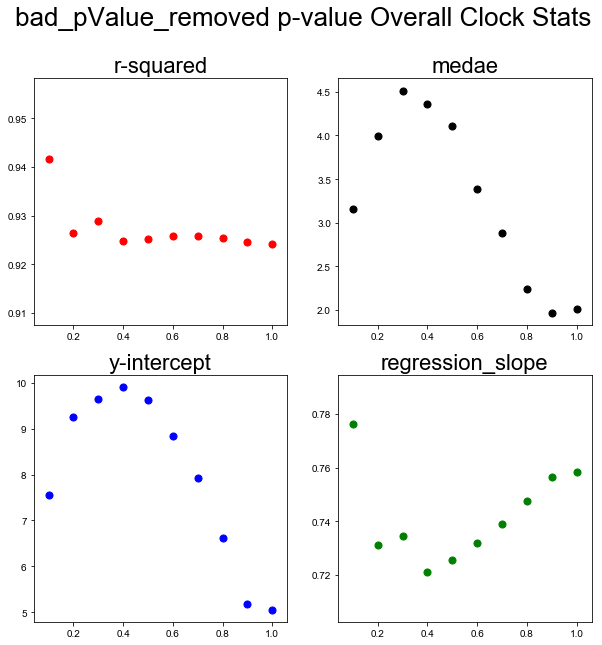

In [48]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(overall_stats_samp_67_bad_pValue_removed_clocks['alpha'], overall_stats_samp_67_bad_pValue_removed_clocks['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(overall_stats_samp_67_bad_pValue_removed_clocks['alpha'], overall_stats_samp_67_bad_pValue_removed_clocks['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(overall_stats_samp_67_bad_pValue_removed_clocks['alpha'], overall_stats_samp_67_bad_pValue_removed_clocks['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(overall_stats_samp_67_bad_pValue_removed_clocks['alpha'], overall_stats_samp_67_bad_pValue_removed_clocks['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('bad_pValue_removed p-value Overall Clock Stats', fontsize = 26)

fig.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/compare_badRemoved_clocks_overall_stats.pdf')

## Remove probes for which a maximum of 10 samples have good pValues (59+ have bad pValues)

The y intercept for this clock model equation is 127.293178514127 .
There are 134 cpgs in the current model
The mean absolute error is 3.5047382659599897
The median absolute error is 3.341097931540439
The mean absolute error for m is 3.753239874683077
The median absolute error for m is 3.6220537386388436
The mean absolute error for f is 3.2161557526041475
The median absolute error for f is 2.927976979727436
r-squared: 0.941535433247516
p-value: 8.521323614656995e-42
slope: 0.7752003289193027
y-intercept for regression: 7.64716304390539
r-squared for m : 0.9366179991265239
p-value for m : 6.023303350767219e-22
slope for m : 0.7624551802719686
y-intercept for regression for m : 8.053144456779162
r-squared for f : 0.9496361821267535
p-value for f : 2.2813900398650628e-20
slope for f : 0.7927044268430218
y-intercept for regression for f : 7.137618195166787


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a01_clock    0.1         134  all  3.504738  3.341098   
1  samp_67_10good_a01_clock    0.1         134    m  3.753240  3.622054   
2  samp_67_10good_a01_clock    0.1         134    f  3.216156  2.927977   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941535  8.521324e-42          0.775200     7.647163  
1   0.936618  6.023303e-22          0.762455     8.053144  
2   0.949636  2.281390e-20          0.792704     7.137618

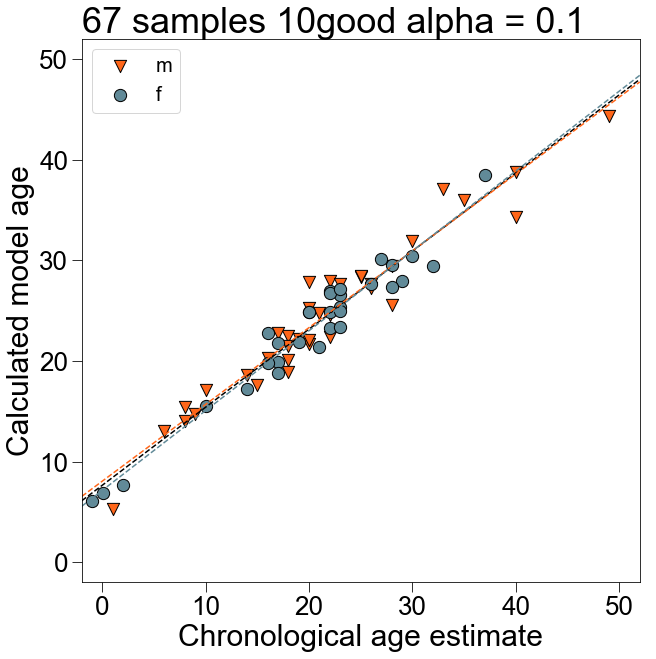

In [49]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_pValue_10good_model_cpgs.csv'
samp_67_10good_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a01_clock = make_epigenetic_clock(samp_67_10good_a01_clock_cpgs_path, samp_67_10good_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a01_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a01_clock", 0.1, len(samp_67_10good_a01_clock['cpgs'])-1,
                                                                    samp_67_10good_a01_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a01_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.1')
samp_67_10good_a01_clock_stats_df

The y intercept for this clock model equation is 101.14628038409799 .
There are 71 cpgs in the current model
The mean absolute error is 4.298422197419754
The median absolute error is 4.269592621290464
The mean absolute error for m is 4.57447489329064
The median absolute error for m is 4.509317923882195
The mean absolute error for f is 3.9778448731825953
The median absolute error for f is 3.549080463591693
r-squared: 0.9229344124831134
p-value: 6.81795414855725e-38
slope: 0.7211292447646308
y-intercept for regression: 9.535141685271226
r-squared for m : 0.9169604317924634
p-value for m : 6.006101966950039e-20
slope for m : 0.7058164939576497
y-intercept for regression for m : 10.012617490847237
r-squared for f : 0.9329710925913594
p-value for f : 1.451655868169665e-18
slope for f : 0.742345885740858
y-intercept for regression for f : 8.93112610215737


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a02_clock    0.2          71  all  4.298422  4.269593   
1  samp_67_10good_a02_clock    0.2          71    m  4.574475  4.509318   
2  samp_67_10good_a02_clock    0.2          71    f  3.977845  3.549080   

   r-squared       p-value  regression_slope  y-intercept  
0   0.922934  6.817954e-38          0.721129     9.535142  
1   0.916960  6.006102e-20          0.705816    10.012617  
2   0.932971  1.451656e-18          0.742346     8.931126

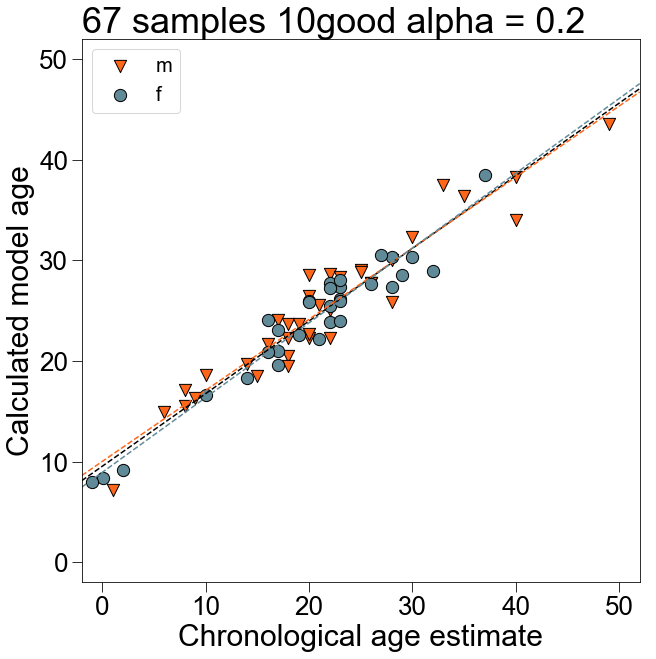

In [50]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_pValue_10good_model_cpgs.csv'
samp_67_10good_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a02_clock = make_epigenetic_clock(samp_67_10good_a02_clock_cpgs_path, samp_67_10good_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a02_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a02_clock", 0.2, len(samp_67_10good_a02_clock['cpgs'])-1,
                                                                    samp_67_10good_a02_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a02_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.2')
samp_67_10good_a02_clock_stats_df

The y intercept for this clock model equation is 96.0141321551821 .
There are 53 cpgs in the current model
The mean absolute error is 4.678478485572175
The median absolute error is 4.619912430491276
The mean absolute error for m is 4.964712712232709
The median absolute error for m is 4.728713940491538
The mean absolute error for f is 4.346077448159943
The median absolute error for f is 4.164141723968665
r-squared: 0.925915527536089
p-value: 1.888617514755946e-38
slope: 0.7247794659697205
y-intercept for regression: 9.952076475145699
r-squared for m : 0.9197003297992443
p-value for m : 3.3905575801552184e-20
slope for m : 0.7079740361735041
y-intercept for regression for m : 10.481750588820026
r-squared for f : 0.9368071510875001
p-value for f : 6.164779521806238e-19
slope for f : 0.7479620055198593
y-intercept for regression for f : 9.28468808028663


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a03_clock    0.3          53  all  4.678478  4.619912   
1  samp_67_10good_a03_clock    0.3          53    m  4.964713  4.728714   
2  samp_67_10good_a03_clock    0.3          53    f  4.346077  4.164142   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925916  1.888618e-38          0.724779     9.952076  
1   0.919700  3.390558e-20          0.707974    10.481751  
2   0.936807  6.164780e-19          0.747962     9.284688

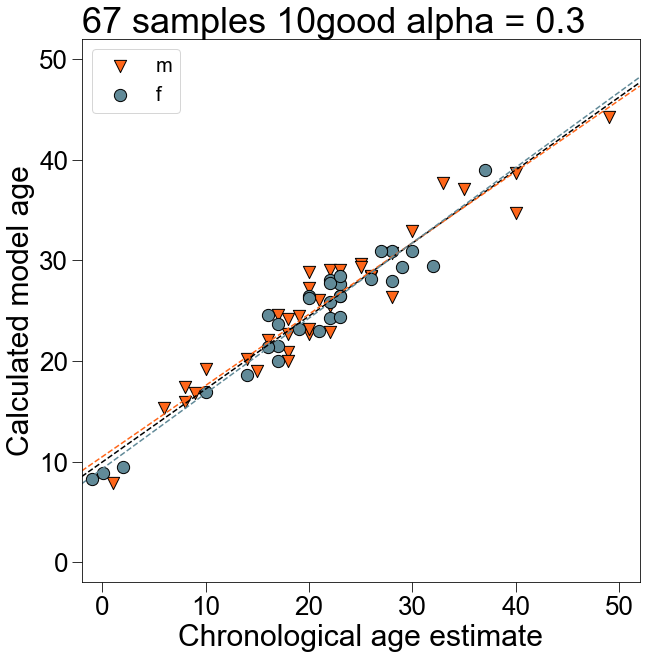

In [51]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_pValue_10good_model_cpgs.csv'
samp_67_10good_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a03_clock = make_epigenetic_clock(samp_67_10good_a03_clock_cpgs_path, samp_67_10good_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a03_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a03_clock", 0.3, len(samp_67_10good_a03_clock['cpgs'])-1,
                                                                    samp_67_10good_a03_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a03_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.3')
samp_67_10good_a03_clock_stats_df

The y intercept for this clock model equation is 89.5906263076832 .
There are 40 cpgs in the current model
The mean absolute error is 4.662804978577486
The median absolute error is 4.424394768015333
The mean absolute error for m is 4.9580717441527495
The median absolute error for m is 4.802250161217071
The mean absolute error for f is 4.319914541135248
The median absolute error for f is 4.2103226100597055
r-squared: 0.9247480077916981
p-value: 3.1413078772641333e-38
slope: 0.7204670743859231
y-intercept for regression: 10.004479217650495
r-squared for m : 0.9182123337618745
p-value for m : 4.6361837808753856e-20
slope for m : 0.7023127389350557
y-intercept for regression for m : 10.572595893231327
r-squared for f : 0.9364519456819869
p-value for f : 6.68793383682839e-19
slope for f : 0.7455840555974443
y-intercept for regression for f : 9.286758639498935


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a04_clock    0.4          40  all  4.662805  4.424395   
1  samp_67_10good_a04_clock    0.4          40    m  4.958072  4.802250   
2  samp_67_10good_a04_clock    0.4          40    f  4.319915  4.210323   

   r-squared       p-value  regression_slope  y-intercept  
0   0.924748  3.141308e-38          0.720467    10.004479  
1   0.918212  4.636184e-20          0.702313    10.572596  
2   0.936452  6.687934e-19          0.745584     9.286759

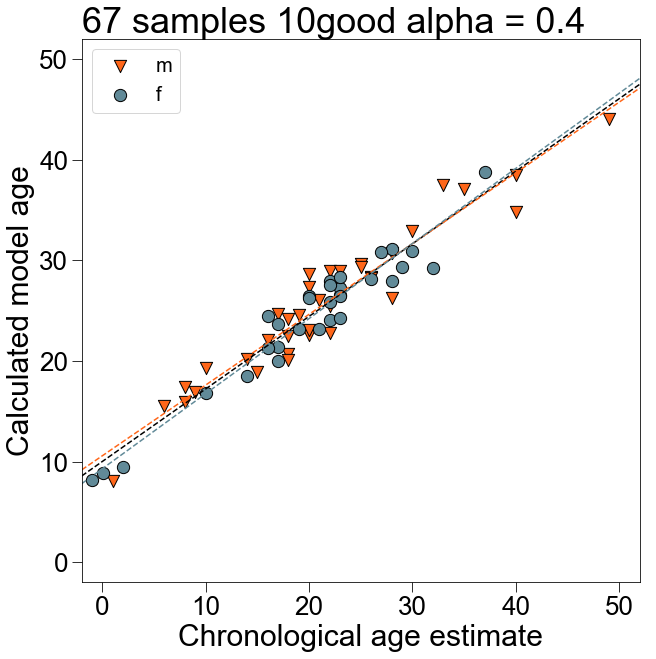

In [52]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_pValue_10good_model_cpgs.csv'
samp_67_10good_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a04_clock = make_epigenetic_clock(samp_67_10good_a04_clock_cpgs_path, samp_67_10good_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a04_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a04_clock", 0.4, len(samp_67_10good_a04_clock['cpgs'])-1,
                                                                    samp_67_10good_a04_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a04_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.4')
samp_67_10good_a04_clock_stats_df

The y intercept for this clock model equation is 86.05856868736731 .
There are 34 cpgs in the current model
The mean absolute error is 4.409459226758038
The median absolute error is 4.080555527989539
The mean absolute error for m is 4.724315273061774
The median absolute error for m is 4.488259453373551
The mean absolute error for f is 4.043819947179507
The median absolute error for f is 3.793892254810622
r-squared: 0.9252512134476256
p-value: 2.525200557519558e-38
slope: 0.7255686475864834
y-intercept for regression: 9.60584879061814
r-squared for m : 0.9187401807458753
p-value for m : 4.151833444225463e-20
slope for m : 0.7060284228056992
y-intercept for regression for m : 10.217574741489274
r-squared for f : 0.9373333550876252
p-value for f : 5.459429985780207e-19
slope for f : 0.7525987063404771
y-intercept for regression for f : 8.83314746631039


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a05_clock    0.5          34  all  4.409459  4.080556   
1  samp_67_10good_a05_clock    0.5          34    m  4.724315  4.488259   
2  samp_67_10good_a05_clock    0.5          34    f  4.043820  3.793892   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925251  2.525201e-38          0.725569     9.605849  
1   0.918740  4.151833e-20          0.706028    10.217575  
2   0.937333  5.459430e-19          0.752599     8.833147

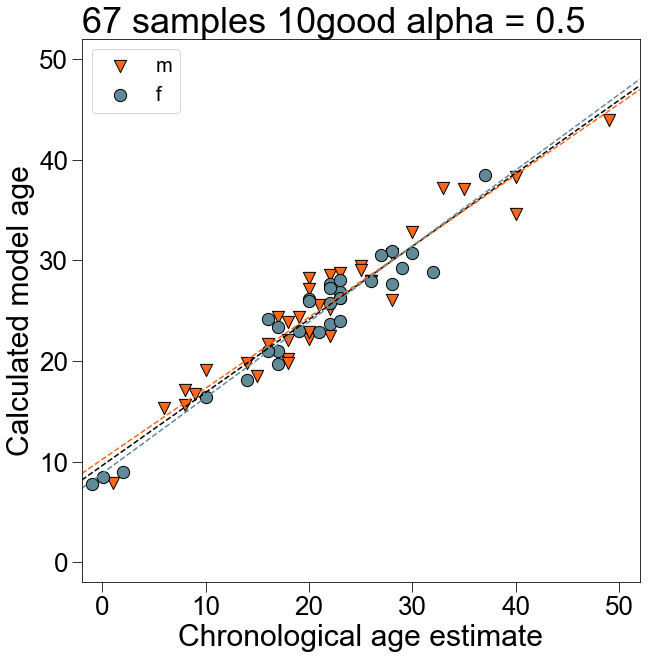

In [53]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_pValue_10good_model_cpgs.csv'
samp_67_10good_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a05_clock = make_epigenetic_clock(samp_67_10good_a05_clock_cpgs_path, samp_67_10good_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a05_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a05_clock", 0.5, len(samp_67_10good_a05_clock['cpgs'])-1,
                                                                    samp_67_10good_a05_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a05_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.5')
samp_67_10good_a05_clock_stats_df

The y intercept for this clock model equation is 84.16873619625301 .
There are 29 cpgs in the current model
The mean absolute error is 3.910047279862502
The median absolute error is 3.4127947417565316
The mean absolute error for m is 4.251692526031438
The median absolute error for m is 3.812428698189157
The mean absolute error for f is 3.513297961730834
The median absolute error for f is 3.300569954399837
r-squared: 0.9257238324266832
p-value: 2.0542916848166852e-38
slope: 0.7319121878537453
y-intercept for regression: 8.865209459491886
r-squared for m : 0.919232845891013
p-value for m : 3.743107095890115e-20
slope for m : 0.7108882597498327
y-intercept for regression for m : 9.51941183917025
r-squared for f : 0.9381665971331842
p-value for f : 4.49443085761493e-19
slope for f : 0.7610665211329849
y-intercept for regression for f : 8.036993402682256


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a06_clock    0.6          29  all  3.910047  3.412795   
1  samp_67_10good_a06_clock    0.6          29    m  4.251693  3.812429   
2  samp_67_10good_a06_clock    0.6          29    f  3.513298  3.300570   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925724  2.054292e-38          0.731912     8.865209  
1   0.919233  3.743107e-20          0.710888     9.519412  
2   0.938167  4.494431e-19          0.761067     8.036993

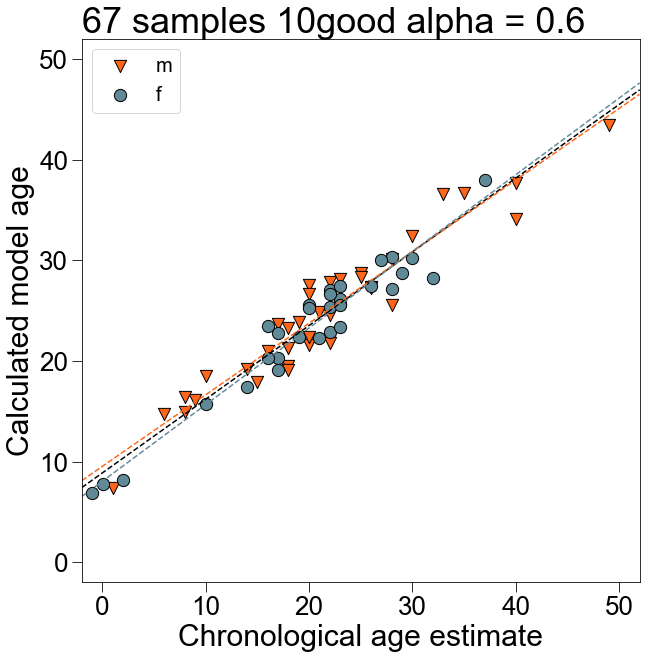

In [54]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_pValue_10good_model_cpgs.csv'
samp_67_10good_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a06_clock = make_epigenetic_clock(samp_67_10good_a06_clock_cpgs_path, samp_67_10good_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a06_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a06_clock", 0.6, len(samp_67_10good_a06_clock['cpgs'])-1,
                                                                    samp_67_10good_a06_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a06_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.6')
samp_67_10good_a06_clock_stats_df

### NOTE: The following cell is the analysis that is in the paper. 

The y intercept for this clock model equation is 82.7205865829618 .
There are 27 cpgs in the current model
The mean absolute error is 3.3126894029986946
The median absolute error is 2.8868190942416874
The mean absolute error for m is 3.659245426602349
The median absolute error for m is 3.1118144605925337
The mean absolute error for f is 2.9102372465557402
The median absolute error for f is 2.4978436267805932
r-squared: 0.9257222850197114
p-value: 2.05568471913366e-38
slope: 0.7388658608428071
y-intercept for regression: 7.92348118430122
r-squared for m : 0.9193888523215336
p-value for m : 3.621788715170707e-20
slope for m : 0.7170470391335004
y-intercept for regression for m : 8.60053278343521
r-squared for f : 0.9381171810020855
p-value for f : 4.546906424598641e-19
slope for f : 0.7691566004277202
y-intercept for regression for f : 7.065449623464403


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a07_clock    0.7          27  all  3.312689  2.886819   
1  samp_67_10good_a07_clock    0.7          27    m  3.659245  3.111814   
2  samp_67_10good_a07_clock    0.7          27    f  2.910237  2.497844   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925722  2.055685e-38          0.738866     7.923481  
1   0.919389  3.621789e-20          0.717047     8.600533  
2   0.938117  4.546906e-19          0.769157     7.065450

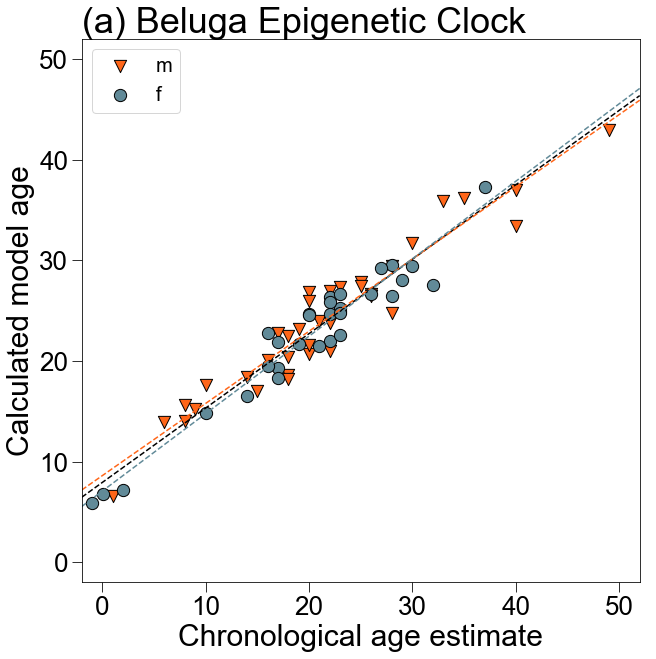

In [55]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_pValue_10good_model_cpgs.csv'
samp_67_10good_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a07_clock = make_epigenetic_clock(samp_67_10good_a07_clock_cpgs_path, samp_67_10good_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a07_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a07_clock", 0.7, len(samp_67_10good_a07_clock['cpgs'])-1,
                                                                    samp_67_10good_a07_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a07_sex_specific.eps', 
                                                                    '(a) Beluga Epigenetic Clock', 'Chronological age estimate', 'Calculated model age')
samp_67_10good_a07_clock_stats_df
#samp_67_10good_a07_model_age_df

The y intercept for this clock model equation is 81.0198283353643 .
There are 26 cpgs in the current model
The mean absolute error is 2.6839106310731977
The median absolute error is 2.240672836300387
The mean absolute error for m is 3.000302918702145
The median absolute error for m is 2.998995142390468
The mean absolute error for f is 2.316487329310549
The median absolute error for f is 1.6959935560187596
r-squared: 0.9252988529965793
p-value: 2.473355630741331e-38
slope: 0.7475067759261786
y-intercept for regression: 6.607181899745152
r-squared for m : 0.919281587271444
p-value for m : 3.7047984323443745e-20
slope for m : 0.7248714023384739
y-intercept for regression for m : 7.310267079186966
r-squared for f : 0.9374492398372879
p-value for f : 5.314549219101401e-19
slope for f : 0.7789185406263809
y-intercept for regression for f : 5.71648647375903


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a08_clock    0.8          26  all  2.683911  2.240673   
1  samp_67_10good_a08_clock    0.8          26    m  3.000303  2.998995   
2  samp_67_10good_a08_clock    0.8          26    f  2.316487  1.695994   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925299  2.473356e-38          0.747507     6.607182  
1   0.919282  3.704798e-20          0.724871     7.310267  
2   0.937449  5.314549e-19          0.778919     5.716486

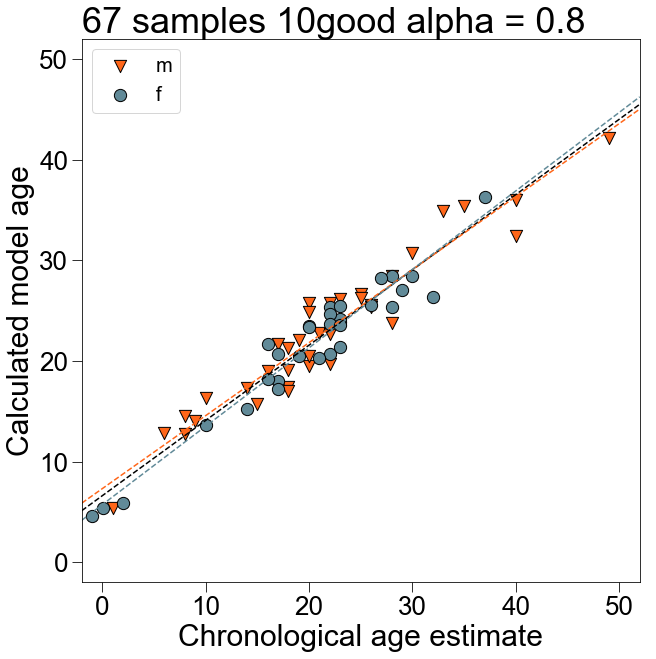

In [56]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_pValue_10good_model_cpgs.csv'
samp_67_10good_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a08_clock = make_epigenetic_clock(samp_67_10good_a08_clock_cpgs_path, samp_67_10good_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a08_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a08_clock", 0.8, len(samp_67_10good_a08_clock['cpgs'])-1,
                                                                    samp_67_10good_a08_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a08_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 0.8')
samp_67_10good_a08_clock_stats_df
#samp_67_10good_a08_model_age_df

The y intercept for this clock model equation is 77.9708623015579 .
There are 23 cpgs in the current model
The mean absolute error is 2.339072681393898
The median absolute error is 1.9653049682994777
The mean absolute error for m is 2.6414267935737534
The median absolute error for m is 1.9594405631128682
The mean absolute error for f is 1.9879517769269694
The median absolute error for f is 2.0638959000065498
r-squared: 0.9244947856342317
p-value: 3.5041582651354496e-38
slope: 0.7564678015752714
y-intercept for regression: 5.169541067582797
r-squared for m : 0.9185655270442669
p-value for m : 4.306556844213503e-20
slope for m : 0.7334346215869231
y-intercept for regression for m : 5.893141435764358
r-squared for f : 0.9366930334402019
p-value for f : 6.328546154619511e-19
slope for f : 0.788284015810035
y-intercept for regression for f : 4.2567078797001106


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a09_clock    0.9          23  all  2.339073  1.965305   
1  samp_67_10good_a09_clock    0.9          23    m  2.641427  1.959441   
2  samp_67_10good_a09_clock    0.9          23    f  1.987952  2.063896   

   r-squared       p-value  regression_slope  y-intercept  
0   0.924495  3.504158e-38          0.756468     5.169541  
1   0.918566  4.306557e-20          0.733435     5.893141  
2   0.936693  6.328546e-19          0.788284     4.256708

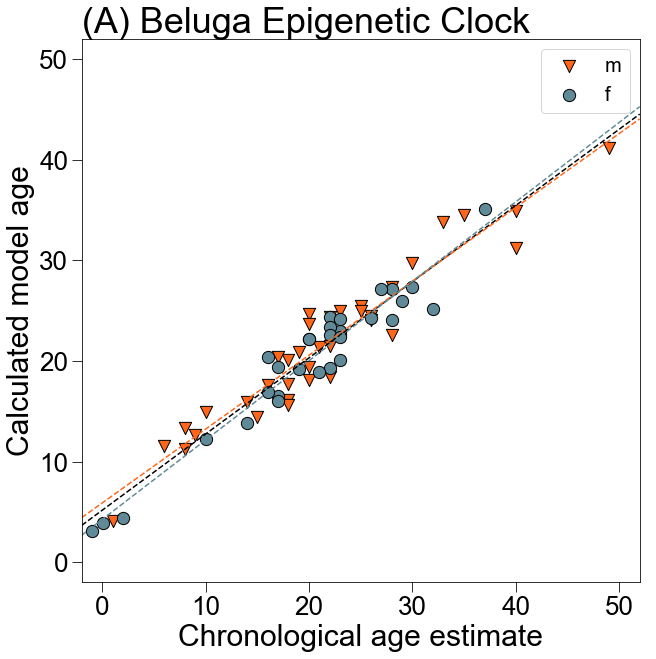

In [174]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_pValue_10good_model_cpgs.csv'
samp_67_10good_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a09_clock = make_epigenetic_clock(samp_67_10good_a09_clock_cpgs_path, samp_67_10good_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a09_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a09_clock", 0.9, len(samp_67_10good_a09_clock['cpgs'])-1,
                                                                    samp_67_10good_a09_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a09_sex_specific.eps', 
                                                                    '(A) Beluga Epigenetic Clock')
samp_67_10good_a09_clock_stats_df

The y intercept for this clock model equation is 76.3952716542763 .
There are 20 cpgs in the current model
The mean absolute error is 2.333770357346814
The median absolute error is 2.0109303384386834
The mean absolute error for m is 2.6293818294899816
The median absolute error for m is 1.955913459811864
The mean absolute error for f is 1.990479615503135
The median absolute error for f is 2.0186312117961585
r-squared: 0.9240756006505425
p-value: 4.195876335863145e-38
slope: 0.7583392087008989
y-intercept for regression: 5.048735837782408
r-squared for m : 0.918099475505812
p-value for m : 4.7464234022691706e-20
slope for m : 0.7349930836158538
y-intercept for regression for m : 5.787977363333896
r-squared for f : 0.9365337500696481
p-value for f : 6.563911200216061e-19
slope for f : 0.7904825971681617
y-intercept for regression for f : 4.118882905503167


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a1_clock    1.0          20  all  2.333770  2.010930   
1  samp_67_10good_a1_clock    1.0          20    m  2.629382  1.955913   
2  samp_67_10good_a1_clock    1.0          20    f  1.990480  2.018631   

   r-squared       p-value  regression_slope  y-intercept  
0   0.924076  4.195876e-38          0.758339     5.048736  
1   0.918099  4.746423e-20          0.734993     5.787977  
2   0.936534  6.563911e-19          0.790483     4.118883

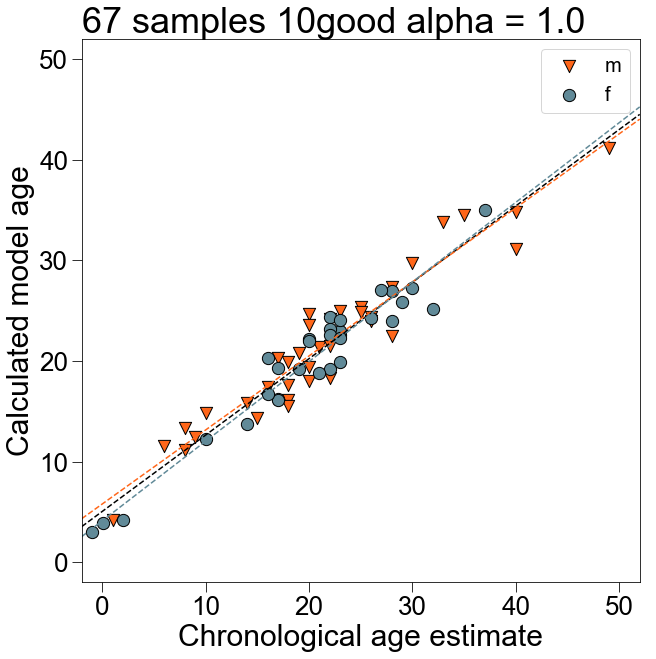

In [58]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_10good_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_pValue_10good_model_cpgs.csv'
samp_67_10good_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_10good_a1_clock = make_epigenetic_clock(samp_67_10good_a1_clock_cpgs_path, samp_67_10good_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_10good_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_10good_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_10good_a1_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_10good_a1_clock", 1.0, len(samp_67_10good_a1_clock['cpgs'])-1,
                                                                    samp_67_10good_a1_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_10good_a1_sex_specific.eps', 
                                                                    '67 samples 10good alpha = 1.0')
samp_67_10good_a1_clock_stats_df

In [59]:

dfs_for_samp_67_10good = [samp_67_10good_a01_clock_stats_df, samp_67_10good_a02_clock_stats_df,
                                      samp_67_10good_a03_clock_stats_df, samp_67_10good_a04_clock_stats_df,
                                      samp_67_10good_a05_clock_stats_df, samp_67_10good_a06_clock_stats_df,
                                      samp_67_10good_a07_clock_stats_df, samp_67_10good_a08_clock_stats_df,
                                      samp_67_10good_a09_clock_stats_df, samp_67_10good_a1_clock_stats_df]

stats_samp_67_10good_clocks = pd.concat(dfs_for_samp_67_10good)

stats_samp_67_10good_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_67_10good_clocks.csv')


stats_samp_67_10good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a01_clock    0.1         134  all  3.504738  3.341098   
1  samp_67_10good_a01_clock    0.1         134    m  3.753240  3.622054   
2  samp_67_10good_a01_clock    0.1         134    f  3.216156  2.927977   
0  samp_67_10good_a02_clock    0.2          71  all  4.298422  4.269593   
1  samp_67_10good_a02_clock    0.2          71    m  4.574475  4.509318   
2  samp_67_10good_a02_clock    0.2          71    f  3.977845  3.549080   
0  samp_67_10good_a03_clock    0.3          53  all  4.678478  4.619912   
1  samp_67_10good_a03_clock    0.3          53    m  4.964713  4.728714   
2  samp_67_10good_a03_clock    0.3          53    f  4.346077  4.164142   
0  samp_67_10good_a04_clock    0.4          40  all  4.662805  4.424395   
1  samp_67_10good_a04_clock    0.4          40    m  4.958072  4.802250   
2  samp_67_10good_a04_clock    0.4          40    f  4.319915  4.210323   
0  samp_67_10good_a05_clock    0.5          34  all  4.409459  4.080556   
1  samp_67_10good_a05_clock    0.5          34    m  4.724315  4.488259   
2  samp_67_10good_a05_clock    0.5          34    f  4.043820  3.793892   
0  samp_67_10good_a06_clock    0.6          29  all  3.910047  3.412795   
1  samp_67_10good_a06_clock    0.6          29    m  4.251693  3.812429   
2  samp_67_10good_a06_clock    0.6          29    f  3.513298  3.300570   
0  samp_67_10good_a07_clock    0.7          27  all  3.312689  2.886819   
1  samp_67_10good_a07_clock    0.7          27    m  3.659245  3.111814   
2  samp_67_10good_a07_clock    0.7          27    f  2.910237  2.497844   
0  samp_67_10good_a08_clock    0.8          26  all  2.683911  2.240673   
1  samp_67_10good_a08_clock    0.8          26    m  3.000303  2.998995   
2  samp_67_10good_a08_clock    0.8          26    f  2.316487  1.695994   
0  samp_67_10good_a09_clock    0.9          23  all  2.339073  1.965305   
1  samp_67_10good_a09_clock    0.9          23    m  2.641427  1.959441   
2  samp_67_10good_a09_clock    0.9          23    f  1.987952  2.063896   
0   samp_67_10good_a1_clock    1.0          20  all  2.333770  2.010930   
1   samp_67_10good_a1_clock    1.0          20    m  2.629382  1.955913   
2   samp_67_10good_a1_clock    1.0          20    f  1.990480  2.018631   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941535  8.521324e-42          0.775200     7.647163  
1   0.936618  6.023303e-22          0.762455     8.053144  
2   0.949636  2.281390e-20          0.792704     7.137618  
0   0.922934  6.817954e-38          0.721129     9.535142  
1   0.916960  6.006102e-20          0.705816    10.012617  
2   0.932971  1.451656e-18          0.742346     8.931126  
0   0.925916  1.888618e-38          0.724779     9.952076  
1   0.919700  3.390558e-20          0.707974    10.481751  
2   0.936807  6.164780e-19          0.747962     9.284688  
0   0.924748  3.141308e-38          0.720467    10.004479  
1   0.918212  4.636184e-20          0.702313    10.572596  
2   0.936452  6.687934e-19          0.745584     9.286759  
0   0.925251  2.525201e-38          0.725569     9.605849  
1   0.918740  4.151833e-20          0.706028    10.217575  
2   0.937333  5.459430e-19          0.752599     8.833147  
0   0.925724  2.054292e-38          0.731912     8.865209  
1   0.919233  3.743107e-20          0.710888     9.519412  
2   0.938167  4.494431e-19          0.761067     8.036993  
0   0.925722  2.055685e-38          0.738866     7.923481  
1   0.919389  3.621789e-20          0.717047     8.600533  
2   0.938117  4.546906e-19          0.769157     7.065450  
0   0.925299  2.473356e-38          0.747507     6.607182  
1   0.919282  3.704798e-20          0.724871     7.310267  
2   0.937449  5.314549e-19          0.778919     5.716486  
0   0.924495  3.504158e-38          0.756468     5.169541  
1   0.918566  4.306557e-20          0.733435     5.893141  
2   0.936693  6.328546e-19          0.788284     4.256708  
0   0.92407

In [60]:
overall_stats_samp_67_10good_clocks = stats_samp_67_10good_clocks[stats_samp_67_10good_clocks['sex']=='all']
overall_stats_samp_67_10good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_10good_a01_clock    0.1         134  all  3.504738  3.341098   
0  samp_67_10good_a02_clock    0.2          71  all  4.298422  4.269593   
0  samp_67_10good_a03_clock    0.3          53  all  4.678478  4.619912   
0  samp_67_10good_a04_clock    0.4          40  all  4.662805  4.424395   
0  samp_67_10good_a05_clock    0.5          34  all  4.409459  4.080556   
0  samp_67_10good_a06_clock    0.6          29  all  3.910047  3.412795   
0  samp_67_10good_a07_clock    0.7          27  all  3.312689  2.886819   
0  samp_67_10good_a08_clock    0.8          26  all  2.683911  2.240673   
0  samp_67_10good_a09_clock    0.9          23  all  2.339073  1.965305   
0   samp_67_10good_a1_clock    1.0          20  all  2.333770  2.010930   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941535  8.521324e-42          0.775200     7.647163  
0   0.922934  6.817954e-38          0.721129     9.535142  
0   0.925916  1.888618e-38          0.724779     9.952076  
0   0.924748  3.141308e-38          0.720467    10.004479  
0   0.925251  2.525201e-38          0.725569     9.605849  
0   0.925724  2.054292e-38          0.731912     8.865209  
0   0.925722  2.055685e-38          0.738866     7.923481  
0   0.925299  2.473356e-38          0.747507     6.607182  
0   0.924495  3.504158e-38          0.756468     5.169541  
0   0.924076  4.195876e-38          0.758339     5.048736

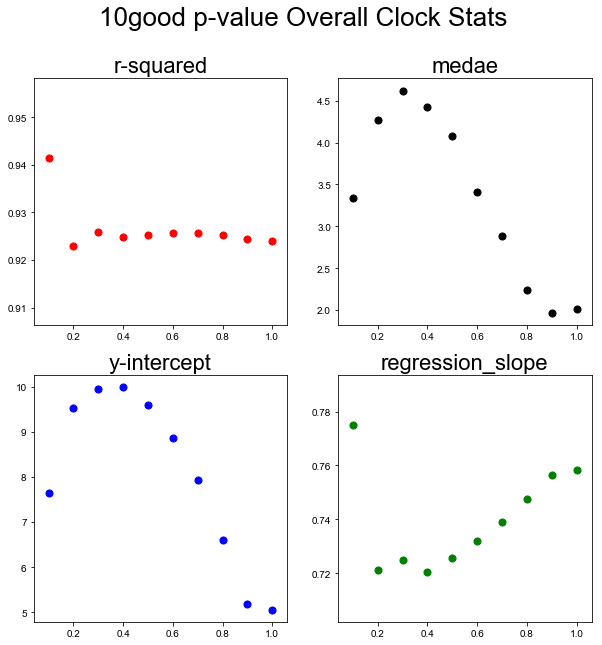

In [61]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(overall_stats_samp_67_10good_clocks['alpha'], overall_stats_samp_67_10good_clocks['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(overall_stats_samp_67_10good_clocks['alpha'], overall_stats_samp_67_10good_clocks['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(overall_stats_samp_67_10good_clocks['alpha'], overall_stats_samp_67_10good_clocks['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(overall_stats_samp_67_10good_clocks['alpha'], overall_stats_samp_67_10good_clocks['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('10good p-value Overall Clock Stats', fontsize = 26)

fig.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/compare_10good_clocks_overall_stats.pdf')

# 20good clocks

The y intercept for this clock model equation is 127.616306675064 .
There are 133 cpgs in the current model
The mean absolute error is 3.4779962990757443
The median absolute error is 3.2841821382263348
The mean absolute error for m is 3.728481137083636
The median absolute error for m is 3.5898981398256
The mean absolute error for f is 3.187110680743999
The median absolute error for f is 2.844262091342099
r-squared: 0.9411987178982197
p-value: 1.0271626555689655e-41
slope: 0.7751670812853232
y-intercept for regression: 7.607635880507647
r-squared for m : 0.9363552591797241
p-value for m : 6.462996011052567e-22
slope for m : 0.7625528245985196
y-intercept for regression for m : 8.012657973724497
r-squared for f : 0.9491909725767868
p-value for f : 2.5924891084124954e-20
slope for f : 0.7924333404733926
y-intercept for regression for f : 7.100772812669135


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a01_clock    0.1         133  all  3.477996  3.284182   
1  samp_67_20good_a01_clock    0.1         133    m  3.728481  3.589898   
2  samp_67_20good_a01_clock    0.1         133    f  3.187111  2.844262   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941199  1.027163e-41          0.775167     7.607636  
1   0.936355  6.462996e-22          0.762553     8.012658  
2   0.949191  2.592489e-20          0.792433     7.100773

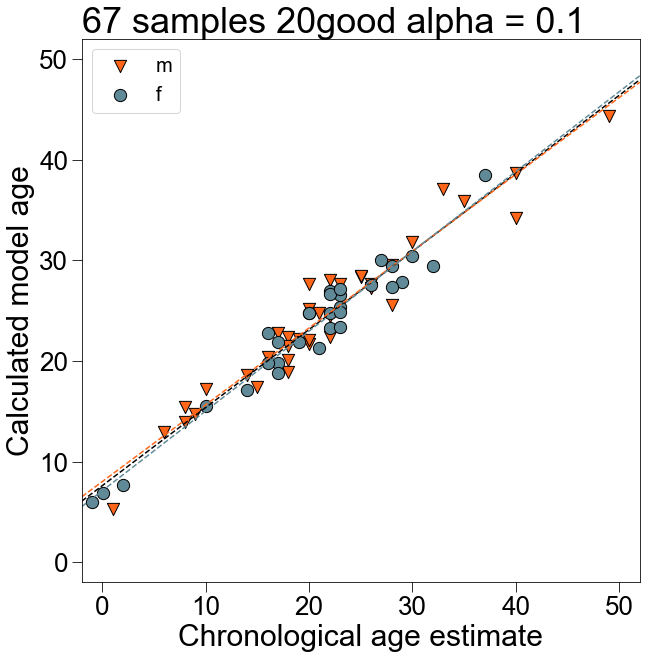

In [62]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_pValue_20good_model_cpgs.csv'
samp_67_20good_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a01_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a01_clock = make_epigenetic_clock(samp_67_20good_a01_clock_cpgs_path, samp_67_20good_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a01_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a01_clock", 0.1, len(samp_67_20good_a01_clock['cpgs'])-1,
                                                                    samp_67_20good_a01_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a01_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.1')
samp_67_20good_a01_clock_stats_df

The y intercept for this clock model equation is 101.026241235014 .
There are 72 cpgs in the current model
The mean absolute error is 4.270284964457549
The median absolute error is 4.192244904814199
The mean absolute error for m is 4.548769595517536
The median absolute error for m is 4.483707324355015
The mean absolute error for f is 3.946883457420148
The median absolute error for f is 3.4756157639641394
r-squared: 0.9224394835131094
p-value: 8.396982910489881e-38
slope: 0.7210903742315933
y-intercept for regression: 9.495604936502291
r-squared for m : 0.9165329594191988
p-value for m : 6.555363120304078e-20
slope for m : 0.7056895552330366
y-intercept for regression for m : 9.977492731589445
r-squared for f : 0.9324112655788687
p-value for f : 1.638179991941853e-18
slope for f : 0.7423989014664765
y-intercept for regression for f : 8.8867915187449


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a02_clock    0.2          72  all  4.270285  4.192245   
1  samp_67_20good_a02_clock    0.2          72    m  4.548770  4.483707   
2  samp_67_20good_a02_clock    0.2          72    f  3.946883  3.475616   

   r-squared       p-value  regression_slope  y-intercept  
0   0.922439  8.396983e-38          0.721090     9.495605  
1   0.916533  6.555363e-20          0.705690     9.977493  
2   0.932411  1.638180e-18          0.742399     8.886792

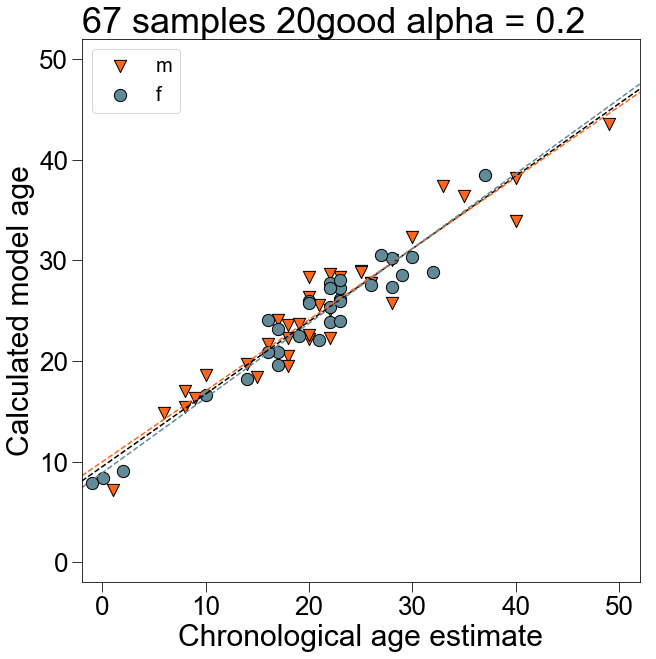

In [63]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_pValue_20good_model_cpgs.csv'
samp_67_20good_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a02_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a02_clock = make_epigenetic_clock(samp_67_20good_a02_clock_cpgs_path, samp_67_20good_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a02_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a02_clock", 0.2, len(samp_67_20good_a02_clock['cpgs'])-1,
                                                                    samp_67_20good_a02_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a02_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.2')
samp_67_20good_a02_clock_stats_df

The y intercept for this clock model equation is 95.9295278260248 .
There are 52 cpgs in the current model
The mean absolute error is 4.6617032606184665
The median absolute error is 4.595389698201867
The mean absolute error for m is 4.949542453296374
The median absolute error for m is 4.727607410013494
The mean absolute error for f is 4.327438391702185
The median absolute error for f is 4.131895063363579
r-squared: 0.9257769215100198
p-value: 2.0070492135700206e-38
slope: 0.7248425024373644
y-intercept for regression: 9.929359617113741
r-squared for m : 0.9195852222045696
p-value for m : 3.474341139749881e-20
slope for m : 0.7080088274035865
y-intercept for regression for m : 10.460397550183766
r-squared for f : 0.9366461519587252
p-value for f : 6.39699111584188e-19
slope for f : 0.7480554378941747
y-intercept for regression for f : 9.260473146954558


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a03_clock    0.3          52  all  4.661703  4.595390   
1  samp_67_20good_a03_clock    0.3          52    m  4.949542  4.727607   
2  samp_67_20good_a03_clock    0.3          52    f  4.327438  4.131895   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925777  2.007049e-38          0.724843     9.929360  
1   0.919585  3.474341e-20          0.708009    10.460398  
2   0.936646  6.396991e-19          0.748055     9.260473

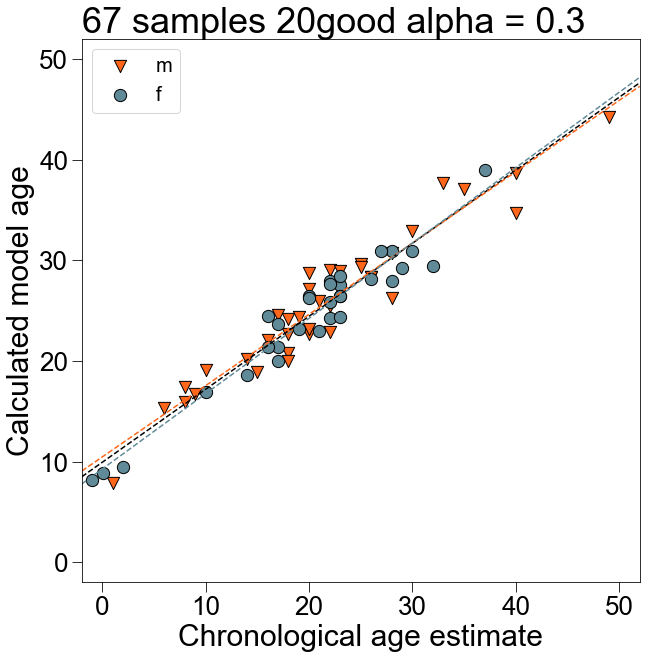

In [64]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_pValue_20good_model_cpgs.csv'
samp_67_20good_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a03_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a03_clock = make_epigenetic_clock(samp_67_20good_a03_clock_cpgs_path, samp_67_20good_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a03_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a03_clock", 0.3, len(samp_67_20good_a03_clock['cpgs'])-1,
                                                                    samp_67_20good_a03_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a03_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.3')
samp_67_20good_a03_clock_stats_df

The y intercept for this clock model equation is 91.3688685248618 .
There are 41 cpgs in the current model
The mean absolute error is 4.552811107183047
The median absolute error is 4.338212493668838
The mean absolute error for m is 4.849722793070224
The median absolute error for m is 4.699318475434751
The mean absolute error for f is 4.208010439701169
The median absolute error for f is 4.138073830479069
r-squared: 0.9270038030415597
p-value: 1.1668659377340799e-38
slope: 0.7300063429251404
y-intercept for regression: 9.704713422405572
r-squared for m : 0.9206433065661944
p-value for m : 2.7723529347034333e-20
slope for m : 0.7115964210098243
y-intercept for regression for m : 10.282696575863534
r-squared for f : 0.9385355649196618
p-value for f : 4.120082963371733e-19
slope for f : 0.7554431369758291
y-intercept for regression for f : 8.97540361618199


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a04_clock    0.4          41  all  4.552811  4.338212   
1  samp_67_20good_a04_clock    0.4          41    m  4.849723  4.699318   
2  samp_67_20good_a04_clock    0.4          41    f  4.208010  4.138074   

   r-squared       p-value  regression_slope  y-intercept  
0   0.927004  1.166866e-38          0.730006     9.704713  
1   0.920643  2.772353e-20          0.711596    10.282697  
2   0.938536  4.120083e-19          0.755443     8.975404

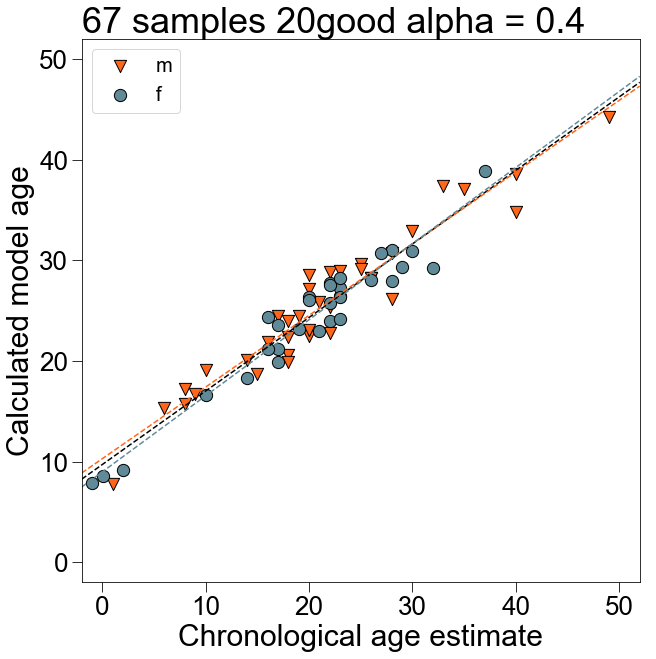

In [65]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_pValue_20good_model_cpgs.csv'
samp_67_20good_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a04_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a04_clock = make_epigenetic_clock(samp_67_20good_a04_clock_cpgs_path, samp_67_20good_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a04_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a04_clock", 0.4, len(samp_67_20good_a04_clock['cpgs'])-1,
                                                                    samp_67_20good_a04_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a04_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.4')
samp_67_20good_a04_clock_stats_df

The y intercept for this clock model equation is 86.05856868736731 .
There are 34 cpgs in the current model
The mean absolute error is 4.409459226758038
The median absolute error is 4.080555527989539
The mean absolute error for m is 4.724315273061774
The median absolute error for m is 4.488259453373551
The mean absolute error for f is 4.043819947179507
The median absolute error for f is 3.793892254810622
r-squared: 0.9252512134476256
p-value: 2.525200557519558e-38
slope: 0.7255686475864834
y-intercept for regression: 9.60584879061814
r-squared for m : 0.9187401807458753
p-value for m : 4.151833444225463e-20
slope for m : 0.7060284228056992
y-intercept for regression for m : 10.217574741489274
r-squared for f : 0.9373333550876252
p-value for f : 5.459429985780207e-19
slope for f : 0.7525987063404771
y-intercept for regression for f : 8.83314746631039


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a05_clock    0.5          34  all  4.409459  4.080556   
1  samp_67_20good_a05_clock    0.5          34    m  4.724315  4.488259   
2  samp_67_20good_a05_clock    0.5          34    f  4.043820  3.793892   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925251  2.525201e-38          0.725569     9.605849  
1   0.918740  4.151833e-20          0.706028    10.217575  
2   0.937333  5.459430e-19          0.752599     8.833147

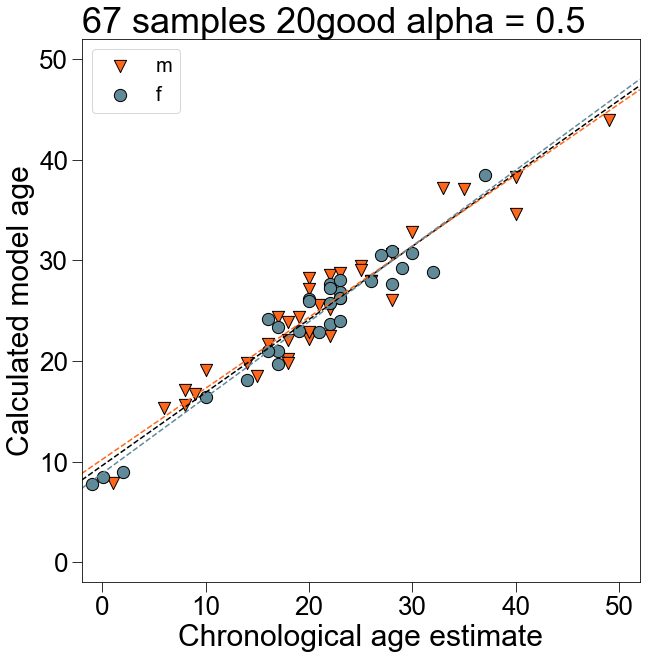

In [66]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_pValue_20good_model_cpgs.csv'
samp_67_20good_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a05_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a05_clock = make_epigenetic_clock(samp_67_20good_a05_clock_cpgs_path, samp_67_20good_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a05_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a05_clock", 0.5, len(samp_67_20good_a05_clock['cpgs'])-1,
                                                                    samp_67_20good_a05_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a05_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.5')
samp_67_20good_a05_clock_stats_df

The y intercept for this clock model equation is 84.16873619625301 .
There are 29 cpgs in the current model
The mean absolute error is 3.910047279862502
The median absolute error is 3.4127947417565316
The mean absolute error for m is 4.251692526031438
The median absolute error for m is 3.812428698189157
The mean absolute error for f is 3.513297961730834
The median absolute error for f is 3.300569954399837
r-squared: 0.9257238324266832
p-value: 2.0542916848166852e-38
slope: 0.7319121878537453
y-intercept for regression: 8.865209459491886
r-squared for m : 0.919232845891013
p-value for m : 3.743107095890115e-20
slope for m : 0.7108882597498327
y-intercept for regression for m : 9.51941183917025
r-squared for f : 0.9381665971331842
p-value for f : 4.49443085761493e-19
slope for f : 0.7610665211329849
y-intercept for regression for f : 8.036993402682256


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a06_clock    0.6          29  all  3.910047  3.412795   
1  samp_67_20good_a06_clock    0.6          29    m  4.251693  3.812429   
2  samp_67_20good_a06_clock    0.6          29    f  3.513298  3.300570   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925724  2.054292e-38          0.731912     8.865209  
1   0.919233  3.743107e-20          0.710888     9.519412  
2   0.938167  4.494431e-19          0.761067     8.036993

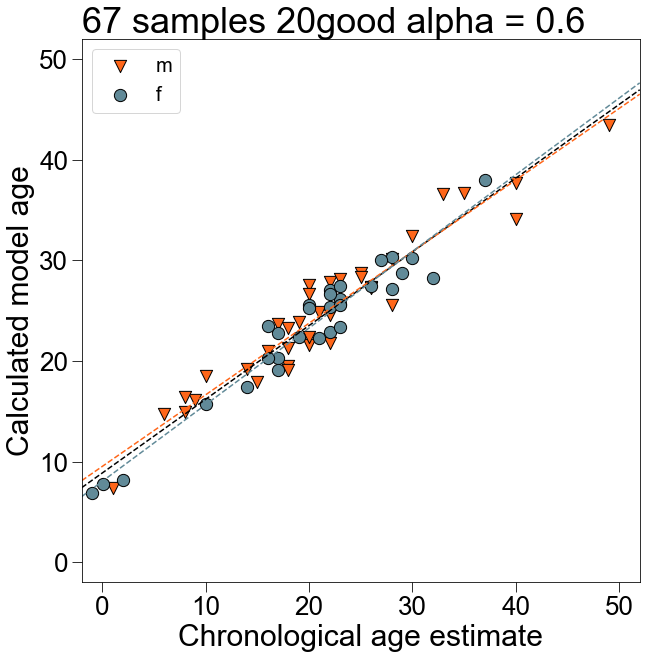

In [67]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_pValue_20good_model_cpgs.csv'
samp_67_20good_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a06_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a06_clock = make_epigenetic_clock(samp_67_20good_a06_clock_cpgs_path, samp_67_20good_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a06_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a06_clock", 0.6, len(samp_67_20good_a06_clock['cpgs'])-1,
                                                                    samp_67_20good_a06_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a06_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.6')
samp_67_20good_a06_clock_stats_df

The y intercept for this clock model equation is 83.6527564442642 .
There are 28 cpgs in the current model
The mean absolute error is 3.084474811175388
The median absolute error is 2.655904395887113
The mean absolute error for m is 3.4174781095133615
The median absolute error for m is 3.278345822649083
The mean absolute error for f is 2.6977613034280616
The median absolute error for f is 2.111751072535508
r-squared: 0.927809014247097
p-value: 8.133499367631064e-39
slope: 0.7492531213303237
y-intercept for regression: 7.418121959000157
r-squared for m : 0.9215898576947299
p-value for m : 2.2596762269577004e-20
slope for m : 0.7276317876154418
y-intercept for regression for m : 8.09114719946118
r-squared for f : 0.9399523197386302
p-value for f : 2.9359566126426846e-19
slope for f : 0.7792316680453858
y-intercept for regression for f : 6.566186252939895


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a07_clock    0.7          28  all  3.084475  2.655904   
1  samp_67_20good_a07_clock    0.7          28    m  3.417478  3.278346   
2  samp_67_20good_a07_clock    0.7          28    f  2.697761  2.111751   

   r-squared       p-value  regression_slope  y-intercept  
0   0.927809  8.133499e-39          0.749253     7.418122  
1   0.921590  2.259676e-20          0.727632     8.091147  
2   0.939952  2.935957e-19          0.779232     6.566186

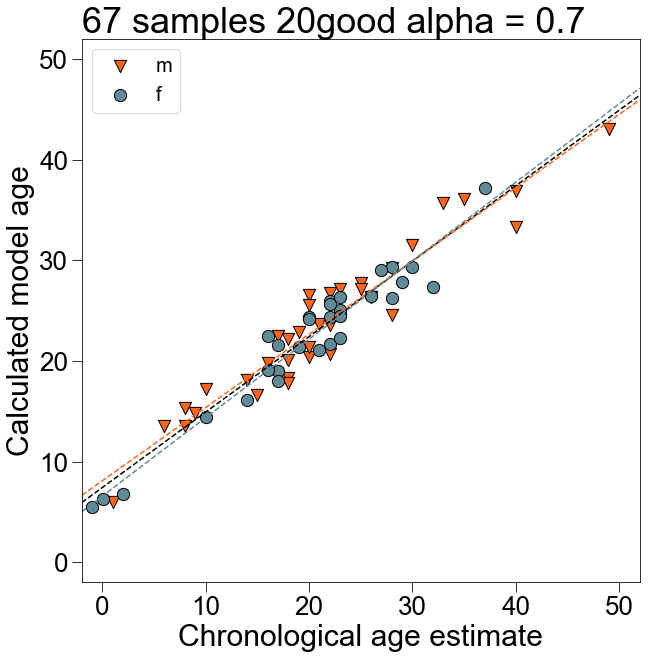

In [68]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_pValue_20good_model_cpgs.csv'
samp_67_20good_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a07_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a07_clock = make_epigenetic_clock(samp_67_20good_a07_clock_cpgs_path, samp_67_20good_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a07_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a07_clock", 0.7, len(samp_67_20good_a07_clock['cpgs'])-1,
                                                                    samp_67_20good_a07_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a07_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.7')
samp_67_20good_a07_clock_stats_df

The y intercept for this clock model equation is 81.0198283353643 .
There are 26 cpgs in the current model
The mean absolute error is 2.6839106310731977
The median absolute error is 2.240672836300387
The mean absolute error for m is 3.000302918702145
The median absolute error for m is 2.998995142390468
The mean absolute error for f is 2.316487329310549
The median absolute error for f is 1.6959935560187596
r-squared: 0.9252988529965793
p-value: 2.473355630741331e-38
slope: 0.7475067759261786
y-intercept for regression: 6.607181899745152
r-squared for m : 0.919281587271444
p-value for m : 3.7047984323443745e-20
slope for m : 0.7248714023384739
y-intercept for regression for m : 7.310267079186966
r-squared for f : 0.9374492398372879
p-value for f : 5.314549219101401e-19
slope for f : 0.7789185406263809
y-intercept for regression for f : 5.71648647375903


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a08_clock    0.8          26  all  2.683911  2.240673   
1  samp_67_20good_a08_clock    0.8          26    m  3.000303  2.998995   
2  samp_67_20good_a08_clock    0.8          26    f  2.316487  1.695994   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925299  2.473356e-38          0.747507     6.607182  
1   0.919282  3.704798e-20          0.724871     7.310267  
2   0.937449  5.314549e-19          0.778919     5.716486

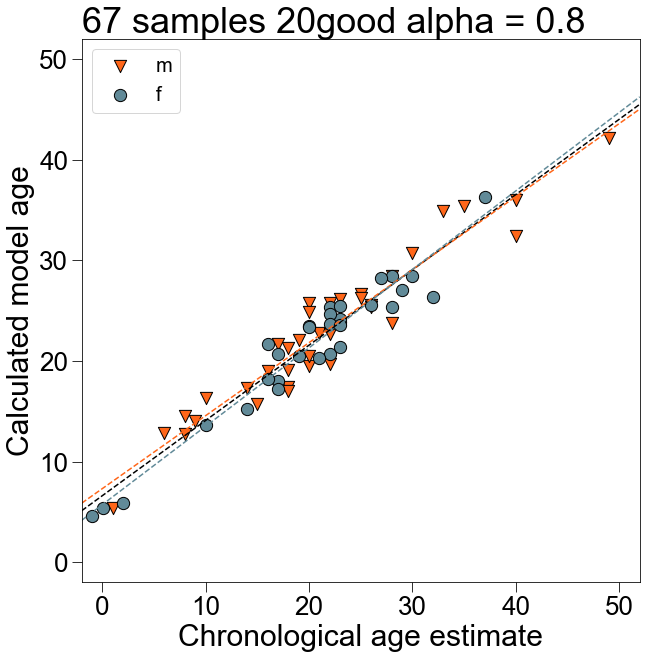

In [69]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_pValue_20good_model_cpgs.csv'
samp_67_20good_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a08_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a08_clock = make_epigenetic_clock(samp_67_20good_a08_clock_cpgs_path, samp_67_20good_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a08_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a08_clock", 0.8, len(samp_67_20good_a08_clock['cpgs'])-1,
                                                                    samp_67_20good_a08_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a08_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.8')
samp_67_20good_a08_clock_stats_df

The y intercept for this clock model equation is 77.9708623015579 .
There are 23 cpgs in the current model
The mean absolute error is 2.339072681393898
The median absolute error is 1.9653049682994777
The mean absolute error for m is 2.6414267935737534
The median absolute error for m is 1.9594405631128682
The mean absolute error for f is 1.9879517769269694
The median absolute error for f is 2.0638959000065498
r-squared: 0.9244947856342317
p-value: 3.5041582651354496e-38
slope: 0.7564678015752714
y-intercept for regression: 5.169541067582797
r-squared for m : 0.9185655270442669
p-value for m : 4.306556844213503e-20
slope for m : 0.7334346215869231
y-intercept for regression for m : 5.893141435764358
r-squared for f : 0.9366930334402019
p-value for f : 6.328546154619511e-19
slope for f : 0.788284015810035
y-intercept for regression for f : 4.2567078797001106


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a09_clock    0.9          23  all  2.339073  1.965305   
1  samp_67_20good_a09_clock    0.9          23    m  2.641427  1.959441   
2  samp_67_20good_a09_clock    0.9          23    f  1.987952  2.063896   

   r-squared       p-value  regression_slope  y-intercept  
0   0.924495  3.504158e-38          0.756468     5.169541  
1   0.918566  4.306557e-20          0.733435     5.893141  
2   0.936693  6.328546e-19          0.788284     4.256708

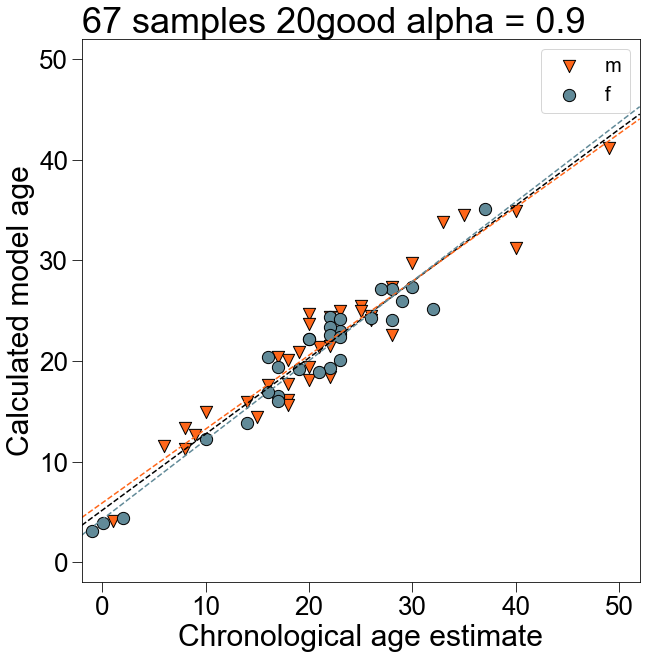

In [70]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_pValue_20good_model_cpgs.csv'
samp_67_20good_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a09_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a09_clock = make_epigenetic_clock(samp_67_20good_a09_clock_cpgs_path, samp_67_20good_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a09_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a09_clock", 0.9, len(samp_67_20good_a09_clock['cpgs'])-1,
                                                                    samp_67_20good_a09_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a09_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 0.9')
samp_67_20good_a09_clock_stats_df

The y intercept for this clock model equation is 76.3952716542763 .
There are 20 cpgs in the current model
The mean absolute error is 2.333770357346814
The median absolute error is 2.0109303384386834
The mean absolute error for m is 2.6293818294899816
The median absolute error for m is 1.955913459811864
The mean absolute error for f is 1.990479615503135
The median absolute error for f is 2.0186312117961585
r-squared: 0.9240756006505425
p-value: 4.195876335863145e-38
slope: 0.7583392087008989
y-intercept for regression: 5.048735837782408
r-squared for m : 0.918099475505812
p-value for m : 4.7464234022691706e-20
slope for m : 0.7349930836158538
y-intercept for regression for m : 5.787977363333896
r-squared for f : 0.9365337500696481
p-value for f : 6.563911200216061e-19
slope for f : 0.7904825971681617
y-intercept for regression for f : 4.118882905503167


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a1_clock    1.0          20  all  2.333770  2.010930   
1  samp_67_20good_a1_clock    1.0          20    m  2.629382  1.955913   
2  samp_67_20good_a1_clock    1.0          20    f  1.990480  2.018631   

   r-squared       p-value  regression_slope  y-intercept  
0   0.924076  4.195876e-38          0.758339     5.048736  
1   0.918099  4.746423e-20          0.734993     5.787977  
2   0.936534  6.563911e-19          0.790483     4.118883

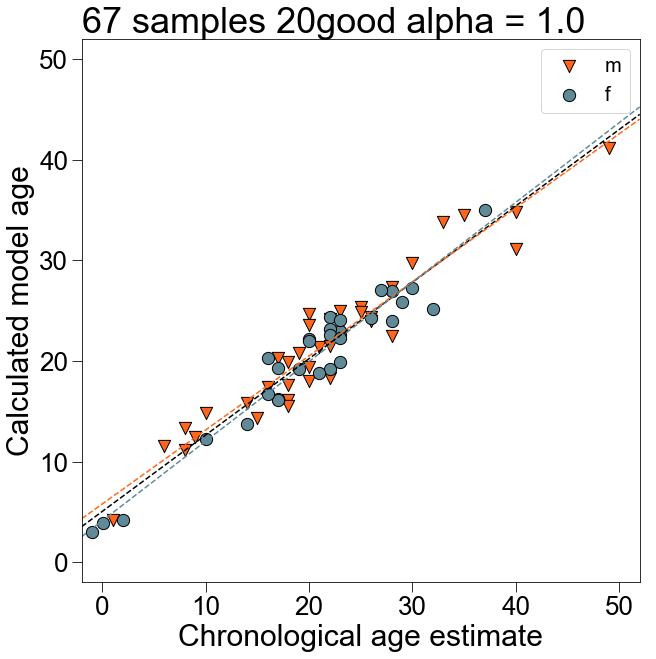

In [71]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_67_20good_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_pValue_20good_model_cpgs.csv'
samp_67_20good_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_67_a1_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_67_20good_a1_clock = make_epigenetic_clock(samp_67_20good_a1_clock_cpgs_path, samp_67_20good_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_67_20good_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_67.columns, sesame_KBO_samp_67, 
                                               samp_67_20good_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_67_20good_a1_clock_stats_df = sex_specific_clock_plots_and_stats("samp_67_20good_a1_clock", 1.0, len(samp_67_20good_a1_clock['cpgs'])-1,
                                                                    samp_67_20good_a1_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_67_20good_a1_sex_specific.eps', 
                                                                    '67 samples 20good alpha = 1.0')
samp_67_20good_a1_clock_stats_df

In [72]:

dfs_for_samp_67_20good = [samp_67_20good_a01_clock_stats_df, samp_67_20good_a02_clock_stats_df,
                                      samp_67_20good_a03_clock_stats_df, samp_67_20good_a04_clock_stats_df,
                                      samp_67_20good_a05_clock_stats_df, samp_67_20good_a06_clock_stats_df,
                                      samp_67_20good_a07_clock_stats_df, samp_67_20good_a08_clock_stats_df,
                                      samp_67_20good_a09_clock_stats_df, samp_67_20good_a1_clock_stats_df]

stats_samp_67_20good_clocks = pd.concat(dfs_for_samp_67_20good)

stats_samp_67_20good_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_67_20good_clocks.csv')


stats_samp_67_20good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a01_clock    0.1         133  all  3.477996  3.284182   
1  samp_67_20good_a01_clock    0.1         133    m  3.728481  3.589898   
2  samp_67_20good_a01_clock    0.1         133    f  3.187111  2.844262   
0  samp_67_20good_a02_clock    0.2          72  all  4.270285  4.192245   
1  samp_67_20good_a02_clock    0.2          72    m  4.548770  4.483707   
2  samp_67_20good_a02_clock    0.2          72    f  3.946883  3.475616   
0  samp_67_20good_a03_clock    0.3          52  all  4.661703  4.595390   
1  samp_67_20good_a03_clock    0.3          52    m  4.949542  4.727607   
2  samp_67_20good_a03_clock    0.3          52    f  4.327438  4.131895   
0  samp_67_20good_a04_clock    0.4          41  all  4.552811  4.338212   
1  samp_67_20good_a04_clock    0.4          41    m  4.849723  4.699318   
2  samp_67_20good_a04_clock    0.4          41    f  4.208010  4.138074   
0  samp_67_20good_a05_clock    0.5          34  all  4.409459  4.080556   
1  samp_67_20good_a05_clock    0.5          34    m  4.724315  4.488259   
2  samp_67_20good_a05_clock    0.5          34    f  4.043820  3.793892   
0  samp_67_20good_a06_clock    0.6          29  all  3.910047  3.412795   
1  samp_67_20good_a06_clock    0.6          29    m  4.251693  3.812429   
2  samp_67_20good_a06_clock    0.6          29    f  3.513298  3.300570   
0  samp_67_20good_a07_clock    0.7          28  all  3.084475  2.655904   
1  samp_67_20good_a07_clock    0.7          28    m  3.417478  3.278346   
2  samp_67_20good_a07_clock    0.7          28    f  2.697761  2.111751   
0  samp_67_20good_a08_clock    0.8          26  all  2.683911  2.240673   
1  samp_67_20good_a08_clock    0.8          26    m  3.000303  2.998995   
2  samp_67_20good_a08_clock    0.8          26    f  2.316487  1.695994   
0  samp_67_20good_a09_clock    0.9          23  all  2.339073  1.965305   
1  samp_67_20good_a09_clock    0.9          23    m  2.641427  1.959441   
2  samp_67_20good_a09_clock    0.9          23    f  1.987952  2.063896   
0   samp_67_20good_a1_clock    1.0          20  all  2.333770  2.010930   
1   samp_67_20good_a1_clock    1.0          20    m  2.629382  1.955913   
2   samp_67_20good_a1_clock    1.0          20    f  1.990480  2.018631   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941199  1.027163e-41          0.775167     7.607636  
1   0.936355  6.462996e-22          0.762553     8.012658  
2   0.949191  2.592489e-20          0.792433     7.100773  
0   0.922439  8.396983e-38          0.721090     9.495605  
1   0.916533  6.555363e-20          0.705690     9.977493  
2   0.932411  1.638180e-18          0.742399     8.886792  
0   0.925777  2.007049e-38          0.724843     9.929360  
1   0.919585  3.474341e-20          0.708009    10.460398  
2   0.936646  6.396991e-19          0.748055     9.260473  
0   0.927004  1.166866e-38          0.730006     9.704713  
1   0.920643  2.772353e-20          0.711596    10.282697  
2   0.938536  4.120083e-19          0.755443     8.975404  
0   0.925251  2.525201e-38          0.725569     9.605849  
1   0.918740  4.151833e-20          0.706028    10.217575  
2   0.937333  5.459430e-19          0.752599     8.833147  
0   0.925724  2.054292e-38          0.731912     8.865209  
1   0.919233  3.743107e-20          0.710888     9.519412  
2   0.938167  4.494431e-19          0.761067     8.036993  
0   0.927809  8.133499e-39          0.749253     7.418122  
1   0.921590  2.259676e-20          0.727632     8.091147  
2   0.939952  2.935957e-19          0.779232     6.566186  
0   0.925299  2.473356e-38          0.747507     6.607182  
1   0.919282  3.704798e-20          0.724871     7.310267  
2   0.937449  5.314549e-19          0.778919     5.716486  
0   0.924495  3.504158e-38          0.756468     5.169541  
1   0.918566  4.306557e-20          0.733435     5.893141  
2   0.936693  6.328546e-19          0.788284     4.256708  
0   0.92407

In [73]:
overall_stats_samp_67_20good_clocks = stats_samp_67_20good_clocks[stats_samp_67_20good_clocks['sex']=='all']
overall_stats_samp_67_20good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_67_20good_a01_clock    0.1         133  all  3.477996  3.284182   
0  samp_67_20good_a02_clock    0.2          72  all  4.270285  4.192245   
0  samp_67_20good_a03_clock    0.3          52  all  4.661703  4.595390   
0  samp_67_20good_a04_clock    0.4          41  all  4.552811  4.338212   
0  samp_67_20good_a05_clock    0.5          34  all  4.409459  4.080556   
0  samp_67_20good_a06_clock    0.6          29  all  3.910047  3.412795   
0  samp_67_20good_a07_clock    0.7          28  all  3.084475  2.655904   
0  samp_67_20good_a08_clock    0.8          26  all  2.683911  2.240673   
0  samp_67_20good_a09_clock    0.9          23  all  2.339073  1.965305   
0   samp_67_20good_a1_clock    1.0          20  all  2.333770  2.010930   

   r-squared       p-value  regression_slope  y-intercept  
0   0.941199  1.027163e-41          0.775167     7.607636  
0   0.922439  8.396983e-38          0.721090     9.495605  
0   0.925777  2.007049e-38          0.724843     9.929360  
0   0.927004  1.166866e-38          0.730006     9.704713  
0   0.925251  2.525201e-38          0.725569     9.605849  
0   0.925724  2.054292e-38          0.731912     8.865209  
0   0.927809  8.133499e-39          0.749253     7.418122  
0   0.925299  2.473356e-38          0.747507     6.607182  
0   0.924495  3.504158e-38          0.756468     5.169541  
0   0.924076  4.195876e-38          0.758339     5.048736

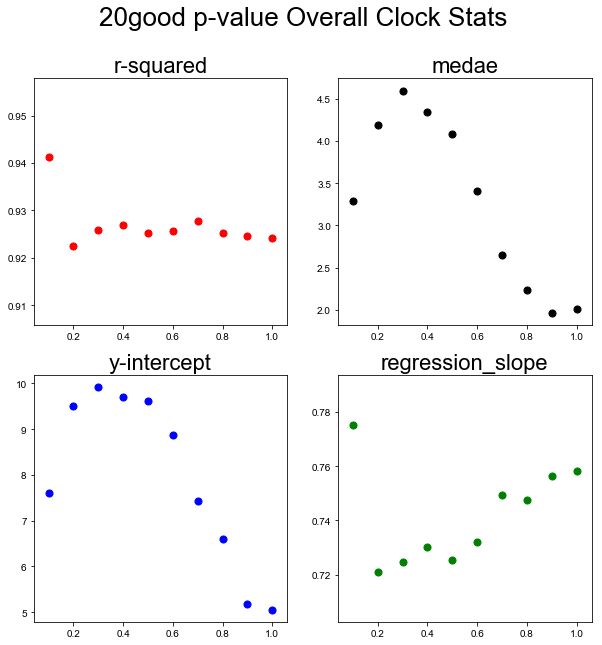

In [74]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(overall_stats_samp_67_20good_clocks['alpha'], overall_stats_samp_67_20good_clocks['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(overall_stats_samp_67_20good_clocks['alpha'], overall_stats_samp_67_20good_clocks['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(overall_stats_samp_67_20good_clocks['alpha'], overall_stats_samp_67_20good_clocks['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(overall_stats_samp_67_20good_clocks['alpha'], overall_stats_samp_67_20good_clocks['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('20good p-value Overall Clock Stats', fontsize = 26)

fig.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/compare_20good_clocks_overall_stats.pdf')

### NOTE: The above series of runs (cycling through alpha values) was also investigated for the"30good" detection p-value filtering runs. These are described in the paper but not included here in the Jupyter Notebook. The summary results are included in the SI. 

# Clock overlap tests

In [36]:
# If you are interested in seeing the overlap in certain clock CpGs, you can modify the following code to do so. 

test_clock_1 = samp_69_10good_a01_clock['cpgs']
test_clock_2 = samp_69_10good_a07_clock['cpgs']
overlap = test_clock_1.isin(test_clock_2)
#overlap

# Calibration Sample Age Histogram



/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


There are 36 males.
There are 31 females.


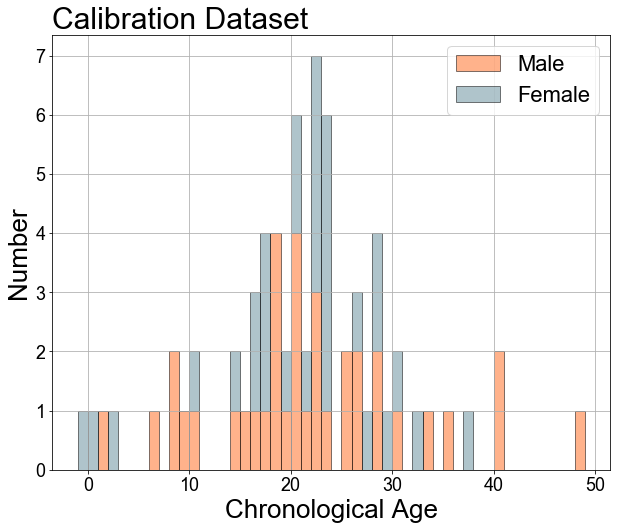

21.0
20.0
22.0


In [178]:


x = samp_67_10good_a09_model_age_df['known_age'][samp_67_10good_a09_model_age_df['sex']=='m']
y =  samp_67_10good_a09_model_age_df['known_age'][samp_67_10good_a09_model_age_df['sex']=='f']

color_dic = {'f': '#618A98', 'm':'#FF6619'}

bins = 50
plt.figure(figsize=(10,8))

plt.hist([x,y], bins, alpha=0.5, label=['Male', 'Female'], color =['#FF6619','#618A98'], histtype='bar', stacked= True, edgecolor = 'black')
#plt.hist(y, bins, alpha=0.5, label='Female', color = '#618A98', histtype='bar', stacked= True)

print("There are", len(x), "males.")
print("There are", len(y), "females.")


plt.legend(loc='upper right', fontsize = 22)

plt.xlabel('Chronological Age', fontsize = 26)
plt.ylabel('Number', fontsize = 26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(np.arange(0, 8, step=1))
plt.title('Calibration Dataset', fontsize = 30, loc='left')
plt.grid(True)

plt.savefig('/Users/elliebors/Desktop/Beluga/manuscripts/beluga_array_ms/by_sex_histogram_calibration_ages_with_grid_stacked_n67.eps')
plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/by_sex_histogram_calibration_ages_with_grid_stacked_n67.pdf')

plt.show()
print(np.median(samp_67_10good_a07_model_age_df['known_age']))
print (np.median(x))
print (np.median(y))


# Leave one out plotting

LOOCV was run in R by looping cv.glmnet() through n-1 samples. Here, I plot the LOOCV run with the same parameters as the chosen clock.


The mean absolute error is 3.653767032630894
The median absolute error is 3.048204723851498
The mean absolute error for m is 4.008691554071364
The median absolute error for m is 2.6774961648129
The mean absolute error for f is 3.2415966206355127
The median absolute error for f is 3.048204723851498
r-squared: 0.7542977439313631
p-value: 1.7428165423922396e-21
slope: 0.6480750748547275
y-intercept for regression: 7.514614751462624
r-squared for m : 0.7173406162757667
p-value for m : 7.447075187463946e-11
slope for m : 0.6320694013592848
y-intercept for regression for m : 7.877975271164809
r-squared for f : 0.8118655119795954
p-value for f : 4.884903093695132e-12
slope for f : 0.6727070948859402
y-intercept for regression for f : 6.991131464385447


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a01_clock    0.1         208  all  3.653767  3.048205   
1  LOOCV_samp_67_all_a01_clock    0.1         208    m  4.008692  2.677496   
2  LOOCV_samp_67_all_a01_clock    0.1         208    f  3.241597  3.048205   

   r-squared       p-value  regression_slope  y-intercept  
0   0.754298  1.742817e-21          0.648075     7.514615  
1   0.717341  7.447075e-11          0.632069     7.877975  
2   0.811866  4.884903e-12          0.672707     6.991131

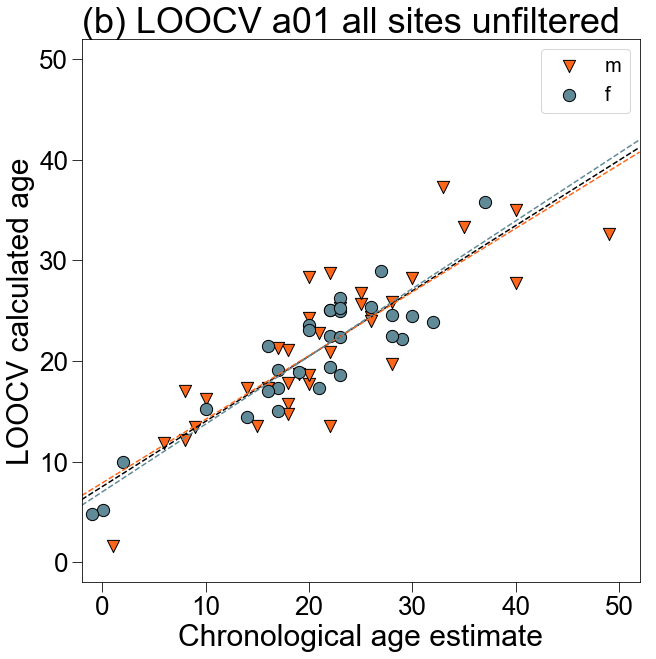

In [77]:
LOOCV_noFilter_KBO_samp_67_a01_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a01_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a01_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a01_clock", 0.1, len(all_KBO_samp_67_a01_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a01_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a01_sex_specific_fig.eps',
                                      "(b) LOOCV a01 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a01_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a01_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a01_stats_df

The mean absolute error is 3.678650571428065
The median absolute error is 3.0859905441876023
The mean absolute error for m is 4.052450702749105
The median absolute error for m is 3.1120932701605044
The mean absolute error for f is 3.244560096345567
The median absolute error for f is 2.829239508438601
r-squared: 0.7550264535661262
p-value: 1.5817089368543436e-21
slope: 0.6392042759128863
y-intercept for regression: 7.798029267862523
r-squared for m : 0.7213705543428672
p-value for m : 5.818887911758831e-11
slope for m : 0.6240861311536625
y-intercept for regression for m : 8.208028231190667
r-squared for f : 0.8066845322744873
p-value for f : 7.264617762533499e-12
slope for f : 0.6612622048677275
y-intercept for regression for f : 7.2504945455481025


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a02_clock    0.2         125  all  3.678651  3.085991   
1  LOOCV_samp_67_all_a02_clock    0.2         125    m  4.052451  3.112093   
2  LOOCV_samp_67_all_a02_clock    0.2         125    f  3.244560  2.829240   

   r-squared       p-value  regression_slope  y-intercept  
0   0.755026  1.581709e-21          0.639204     7.798029  
1   0.721371  5.818888e-11          0.624086     8.208028  
2   0.806685  7.264618e-12          0.661262     7.250495

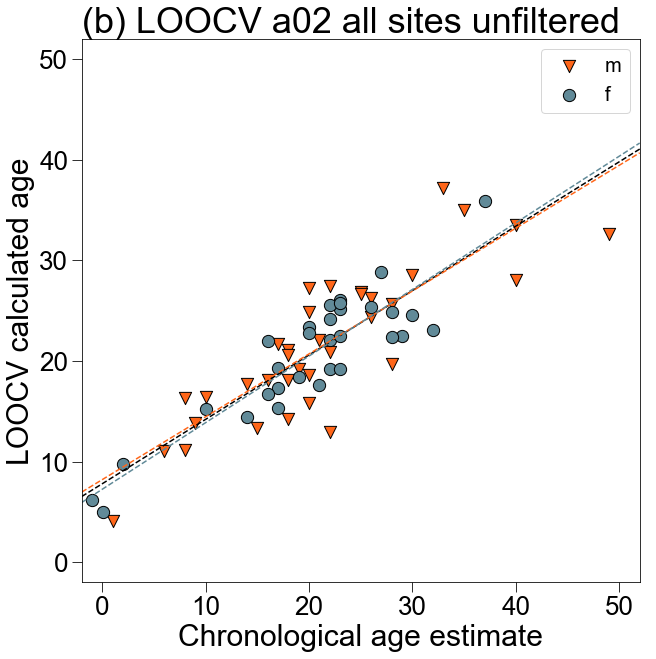

In [78]:
LOOCV_noFilter_KBO_samp_67_a02_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a02_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a02_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a02_clock", 0.2, len(all_KBO_samp_67_a02_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a02_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a02_sex_specific_fig.eps',
                                      "(b) LOOCV a02 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a02_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a02_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a02_stats_df

The mean absolute error is 3.7128586497300367
The median absolute error is 2.9117542921635007
The mean absolute error for m is 4.156006459297736
The median absolute error for m is 3.192192395347849
The mean absolute error for f is 3.198235387006256
The median absolute error for f is 2.9117542921635007
r-squared: 0.7472806322890357
p-value: 4.371769983735254e-21
slope: 0.658778891866331
y-intercept for regression: 7.276797876365617
r-squared for m : 0.7065782177680415
p-value for m : 1.415522481375092e-10
slope for m : 0.6523858131906486
y-intercept for regression for m : 7.388201648187875
r-squared for f : 0.8158075813899756
p-value for f : 3.585363084111833e-12
slope for f : 0.6692277865792399
y-intercept for regression for f : 7.094513490091293


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a03_clock    0.3          96  all  3.712859  2.911754   
1  LOOCV_samp_67_all_a03_clock    0.3          96    m  4.156006  3.192192   
2  LOOCV_samp_67_all_a03_clock    0.3          96    f  3.198235  2.911754   

   r-squared       p-value  regression_slope  y-intercept  
0   0.747281  4.371770e-21          0.658779     7.276798  
1   0.706578  1.415522e-10          0.652386     7.388202  
2   0.815808  3.585363e-12          0.669228     7.094513

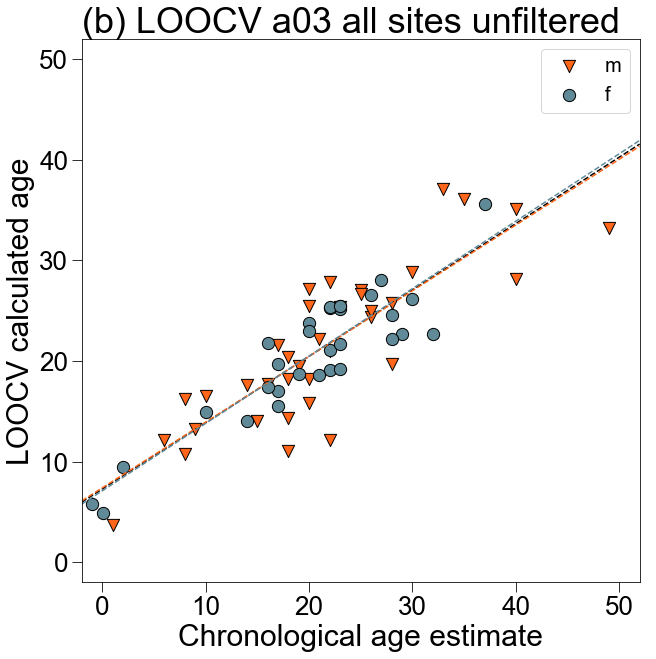

In [79]:
LOOCV_noFilter_KBO_samp_67_a03_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a03_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a03_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a03_clock", 0.3, len(all_KBO_samp_67_a03_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a03_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a03_sex_specific_fig.eps',
                                      "(b) LOOCV a03 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a03_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a03_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a03_stats_df

The mean absolute error is 3.4899065669769187
The median absolute error is 2.4580284211946015
The mean absolute error for m is 4.036901311726106
The median absolute error for m is 3.2394860810556994
The mean absolute error for f is 2.8546868633972196
The median absolute error for f is 2.376510288512897
r-squared: 0.7637508050345871
p-value: 4.8404976985531085e-22
slope: 0.672450990771592
y-intercept for regression: 6.882834190911556
r-squared for m : 0.7131074510197251
p-value for m : 9.614475580293709e-11
slope for m : 0.6560840692737847
y-intercept for regression for m : 7.370212793868305
r-squared for f : 0.8467578640300137
p-value for f : 2.446809878000089e-13
slope for f : 0.6955437470643024
y-intercept for regression for f : 6.255490307666955


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a04_clock    0.4          82  all  3.489907  2.458028   
1  LOOCV_samp_67_all_a04_clock    0.4          82    m  4.036901  3.239486   
2  LOOCV_samp_67_all_a04_clock    0.4          82    f  2.854687  2.376510   

   r-squared       p-value  regression_slope  y-intercept  
0   0.763751  4.840498e-22          0.672451     6.882834  
1   0.713107  9.614476e-11          0.656084     7.370213  
2   0.846758  2.446810e-13          0.695544     6.255490

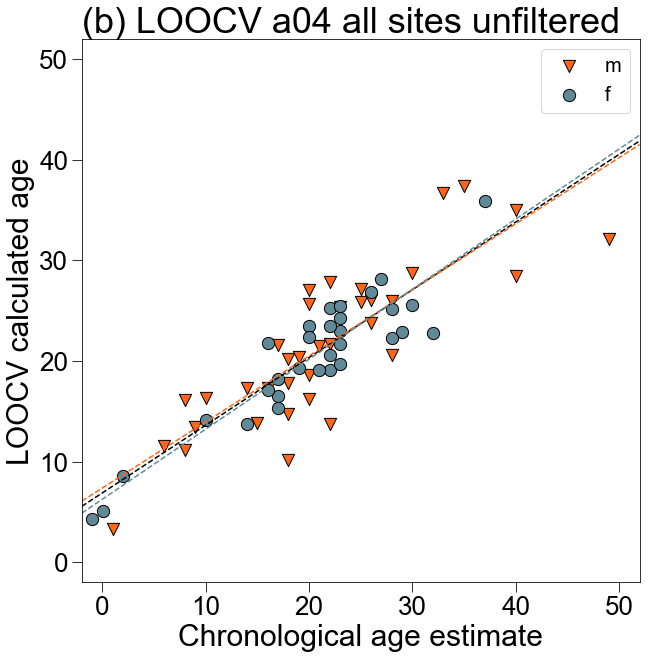

In [80]:
LOOCV_noFilter_KBO_samp_67_a04_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a04_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a04_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a04_clock", 0.4, len(all_KBO_samp_67_a04_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a04_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a04_sex_specific_fig.eps',
                                      "(b) LOOCV a04 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a04_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a04_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a04_stats_df

The mean absolute error is 3.618920700192968
The median absolute error is 2.8995201232065995
The mean absolute error for m is 4.117626275194086
The median absolute error for m is 3.2458819343175005
The mean absolute error for f is 3.039778742127154
The median absolute error for f is 2.8219955838378965
r-squared: 0.7656617828111283
p-value: 3.713073865781932e-22
slope: 0.6786933197847915
y-intercept for regression: 6.708352424042136
r-squared for m : 0.7281916174135464
p-value for m : 3.801499744250492e-11
slope for m : 0.6670297479378987
y-intercept for regression for m : 7.03060807433145
r-squared for f : 0.8253252786440913
p-value for f : 1.6523488723839091e-12
slope for f : 0.6956033773313609
y-intercept for regression for f : 6.281208545548333


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a05_clock    0.5          85  all  3.618921  2.899520   
1  LOOCV_samp_67_all_a05_clock    0.5          85    m  4.117626  3.245882   
2  LOOCV_samp_67_all_a05_clock    0.5          85    f  3.039779  2.821996   

   r-squared       p-value  regression_slope  y-intercept  
0   0.765662  3.713074e-22          0.678693     6.708352  
1   0.728192  3.801500e-11          0.667030     7.030608  
2   0.825325  1.652349e-12          0.695603     6.281209

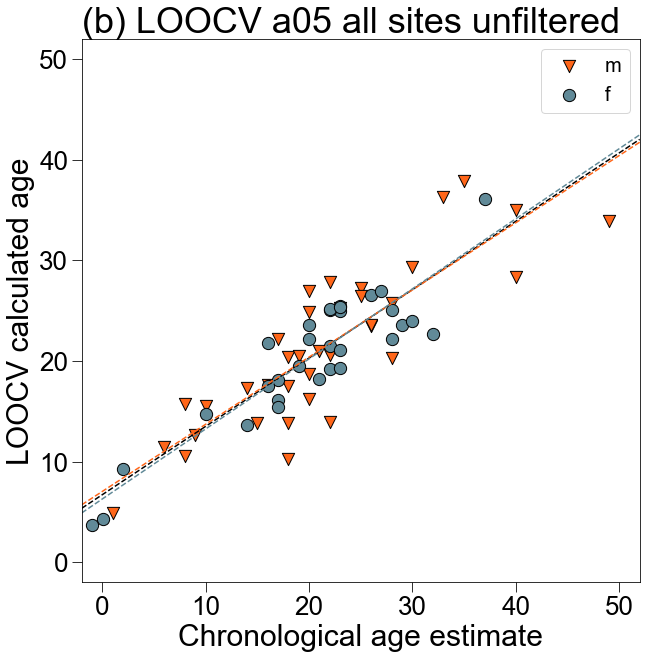

In [81]:
LOOCV_noFilter_KBO_samp_67_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a05_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a05_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a05_clock", 0.5, len(all_KBO_samp_67_a05_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a05_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a05_sex_specific_fig.eps',
                                      "(b) LOOCV a05 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a05_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a05_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a05_stats_df

The mean absolute error is 3.431592396988786
The median absolute error is 2.5211915879913
The mean absolute error for m is 4.014963127300338
The median absolute error for m is 3.1668035981756004
The mean absolute error for f is 2.754129613401179
The median absolute error for f is 2.2046500463066003
r-squared: 0.7701451887925425
p-value: 1.9763075012650594e-22
slope: 0.6850713341465011
y-intercept for regression: 6.609889651408608
r-squared for m : 0.7218756839848072
p-value for m : 5.6403010190520775e-11
slope for m : 0.6648501897398894
y-intercept for regression for m : 7.065222604964976
r-squared for f : 0.8472094304154913
p-value for f : 2.343738546816975e-13
slope for f : 0.716258202515062
y-intercept for regression for f : 5.9514968398850066


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a06_clock    0.6          82  all  3.431592  2.521192   
1  LOOCV_samp_67_all_a06_clock    0.6          82    m  4.014963  3.166804   
2  LOOCV_samp_67_all_a06_clock    0.6          82    f  2.754130  2.204650   

   r-squared       p-value  regression_slope  y-intercept  
0   0.770145  1.976308e-22          0.685071     6.609890  
1   0.721876  5.640301e-11          0.664850     7.065223  
2   0.847209  2.343739e-13          0.716258     5.951497

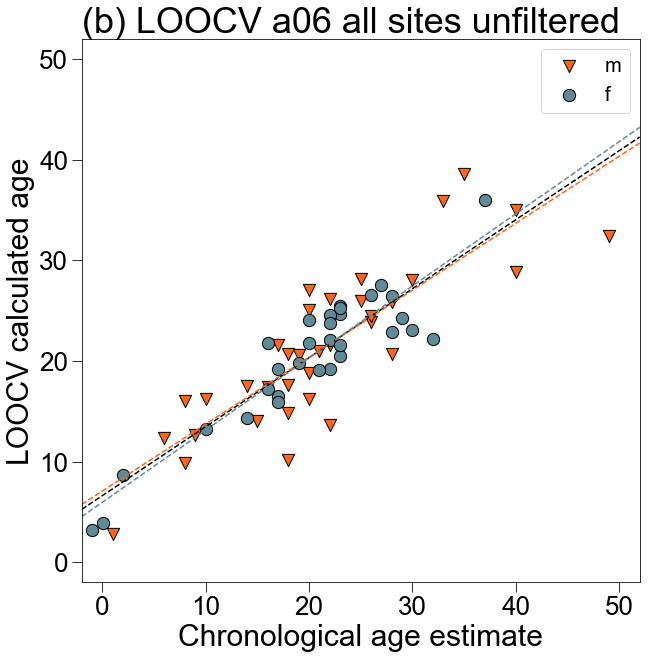

In [82]:
LOOCV_noFilter_KBO_samp_67_a06_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a06_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a06_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a06_clock", 0.6, len(all_KBO_samp_67_a06_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a06_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a06_sex_specific_fig.eps',
                                      "(b) LOOCV a06 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a06_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a06_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a06_stats_df

The mean absolute error is 3.5249209211452883
The median absolute error is 2.982233602421502
The mean absolute error for m is 4.151152733403927
The median absolute error for m is 3.764894606181601
The mean absolute error for f is 2.7976839778771914
The median absolute error for f is 2.7962720817869986
r-squared: 0.7698509099084473
p-value: 2.060598719929366e-22
slope: 0.683251393439221
y-intercept for regression: 6.654942017081437
r-squared for m : 0.7169598351014528
p-value for m : 7.621347545697997e-11
slope for m : 0.6512035516620691
y-intercept for regression for m : 7.478495643924415
r-squared for f : 0.8519414641410944
p-value for f : 1.4814064591407006e-13
slope for f : 0.730834818706022
y-intercept for regression for f : 5.530482603919573


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a07_clock    0.7          69  all  3.524921  2.982234   
1  LOOCV_samp_67_all_a07_clock    0.7          69    m  4.151153  3.764895   
2  LOOCV_samp_67_all_a07_clock    0.7          69    f  2.797684  2.796272   

   r-squared       p-value  regression_slope  y-intercept  
0   0.769851  2.060599e-22          0.683251     6.654942  
1   0.716960  7.621348e-11          0.651204     7.478496  
2   0.851941  1.481406e-13          0.730835     5.530483

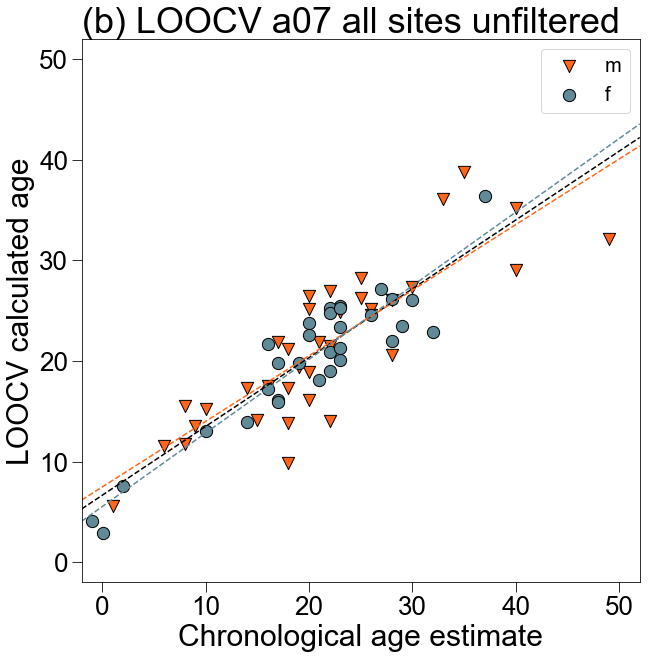

In [83]:
LOOCV_noFilter_KBO_samp_67_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a07_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a07_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a07_clock", 0.7, len(all_KBO_samp_67_a07_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a07_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a07_sex_specific_fig.eps',
                                      "(b) LOOCV a07 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a07_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a07_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a07_stats_df

The mean absolute error is 3.3098103248443436
The median absolute error is 2.55840247325491
The mean absolute error for m is 3.8696411534735935
The median absolute error for m is 2.7885369856121986
The mean absolute error for f is 2.6596842012748914
The median absolute error for f is 2.089937366936603
r-squared: 0.7823570899497277
p-value: 3.326764938283498e-23
slope: 0.7065478330946401
y-intercept for regression: 6.089153529675153
r-squared for m : 0.7390307435115486
p-value for m : 1.890293695597056e-11
slope for m : 0.6739567944677116
y-intercept for regression for m : 6.853315533146866
r-squared for f : 0.8483139067709007
p-value for f : 2.108438145629109e-13
slope for f : 0.7562647364952177
y-intercept for regression for f : 5.003930322960642


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a08_clock    0.8          65  all  3.309810  2.558402   
1  LOOCV_samp_67_all_a08_clock    0.8          65    m  3.869641  2.788537   
2  LOOCV_samp_67_all_a08_clock    0.8          65    f  2.659684  2.089937   

   r-squared       p-value  regression_slope  y-intercept  
0   0.782357  3.326765e-23          0.706548     6.089154  
1   0.739031  1.890294e-11          0.673957     6.853316  
2   0.848314  2.108438e-13          0.756265     5.003930

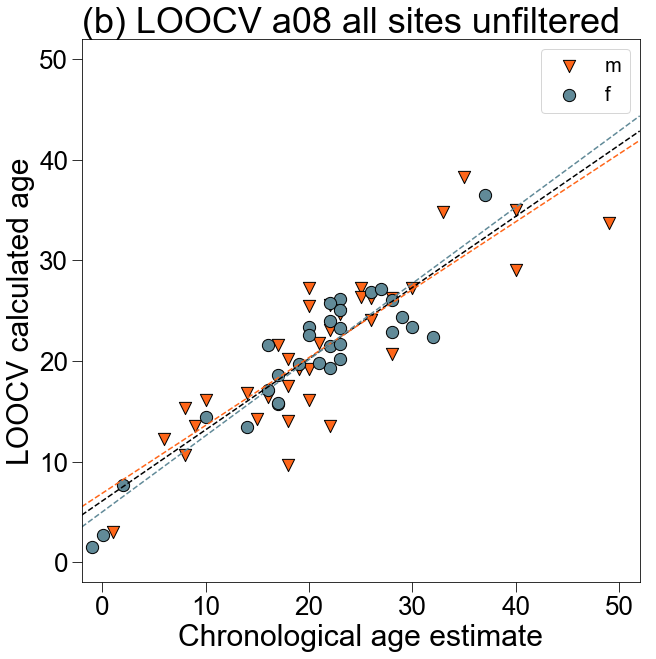

In [84]:
LOOCV_noFilter_KBO_samp_67_a08_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a08_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a08_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a08_clock", 0.8, len(all_KBO_samp_67_a08_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a08_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a08_sex_specific_fig.eps',
                                      "(b) LOOCV a08 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a08_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a08_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a08_stats_df

The mean absolute error is 3.3570270151030077
The median absolute error is 2.791625304821199
The mean absolute error for m is 3.992758773106524
The median absolute error for m is 3.242335605413901
The mean absolute error for f is 2.6187578767763444
The median absolute error for f is 1.9046609785428004
r-squared: 0.7883185551553908
p-value: 1.344091660020407e-23
slope: 0.6977853264247171
y-intercept for regression: 6.328874322056015
r-squared for m : 0.7408033840151084
p-value for m : 1.6816131010275443e-11
slope for m : 0.6753265082806247
y-intercept for regression for m : 7.105935230706756
r-squared for f : 0.8655606063871506
p-value for f : 3.629383203128573e-14
slope for f : 0.727514598994395
y-intercept for regression for f : 5.381975649749878


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a09_clock    0.9          59  all  3.357027  2.791625   
1  LOOCV_samp_67_all_a09_clock    0.9          59    m  3.992759  3.242336   
2  LOOCV_samp_67_all_a09_clock    0.9          59    f  2.618758  1.904661   

   r-squared       p-value  regression_slope  y-intercept  
0   0.788319  1.344092e-23          0.697785     6.328874  
1   0.740803  1.681613e-11          0.675327     7.105935  
2   0.865561  3.629383e-14          0.727515     5.381976

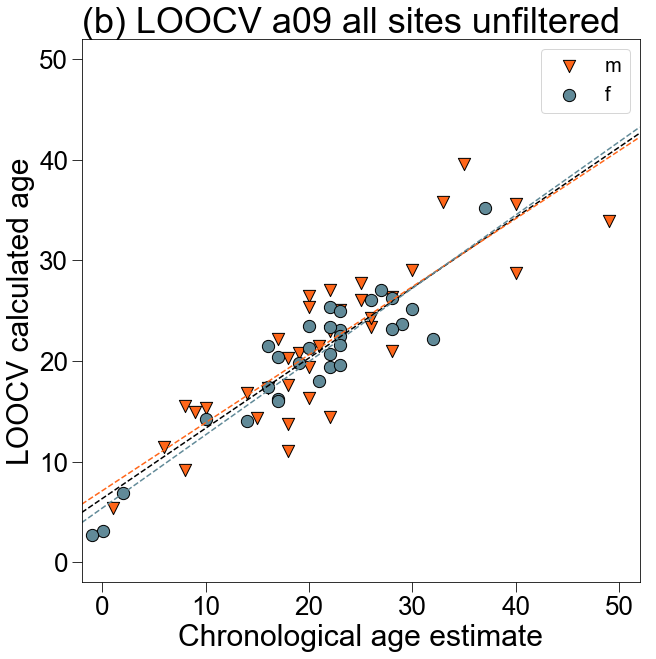

In [85]:
LOOCV_noFilter_KBO_samp_67_a09_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a09_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a09_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a09_clock", 0.9, len(all_KBO_samp_67_a09_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a09_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a09_sex_specific_fig.eps',
                                      "(b) LOOCV a09 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a09_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a09_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a09_stats_df

The mean absolute error is 3.0292248156818764
The median absolute error is 2.196308803120605
The mean absolute error for m is 3.6160119913644766
The median absolute error for m is 3.20532565151985
The mean absolute error for f is 2.3477945471472434
The median absolute error for f is 1.6161836918464019
r-squared: 0.8162323192100429
p-value: 1.3341521063064474e-25
slope: 0.7034989795962966
y-intercept for regression: 6.385583515347129
r-squared for m : 0.7728481554188089
p-value for m : 1.7492704323155313e-12
slope for m : 0.6560554557956332
y-intercept for regression for m : 7.6895517594182525
r-squared for f : 0.884710323059008
p-value for f : 3.8703506159586894e-15
slope for f : 0.7724075675774847
y-intercept for regression for f : 4.653556819507335


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a1_clock    1.0          58  all  3.029225  2.196309   
1  LOOCV_samp_67_all_a1_clock    1.0          58    m  3.616012  3.205326   
2  LOOCV_samp_67_all_a1_clock    1.0          58    f  2.347795  1.616184   

   r-squared       p-value  regression_slope  y-intercept  
0   0.816232  1.334152e-25          0.703499     6.385584  
1   0.772848  1.749270e-12          0.656055     7.689552  
2   0.884710  3.870351e-15          0.772408     4.653557

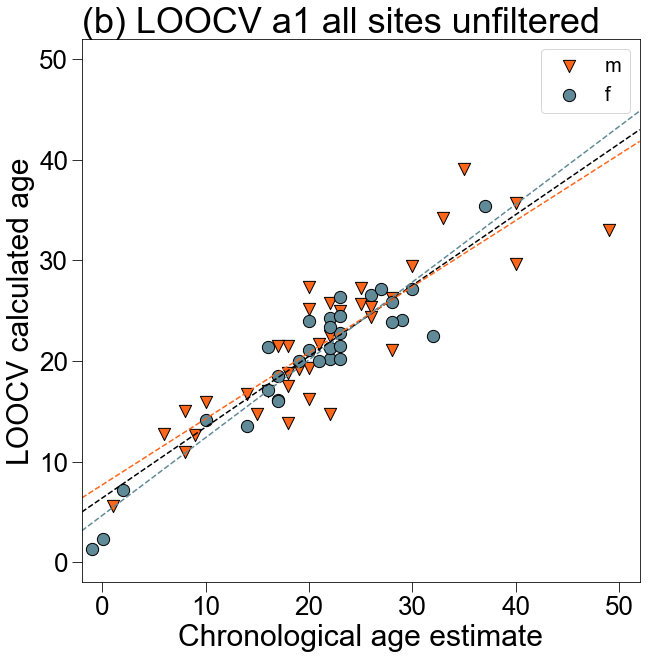

In [86]:
LOOCV_noFilter_KBO_samp_67_a1_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_KBO_samp_67_a1_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_noFilter_KBO_samp_67_a1_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_all_a1_clock", 1.0, len(all_KBO_samp_67_a1_clock['cpgs'])-1,
                                                                    LOOCV_noFilter_KBO_samp_67_a1_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a1_sex_specific_fig.eps',
                                      "(b) LOOCV a1 all sites unfiltered", "Chronological age estimate", "LOOCV calculated age")


LOOCV_noFilter_KBO_samp_67_a1_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_nofilter_samp_67_a1_sex_specific_stats.csv")
LOOCV_noFilter_KBO_samp_67_a1_stats_df

In [87]:

LOOCV_dfs_for_samp_67_unfiltered = [LOOCV_noFilter_KBO_samp_67_a01_stats_df, LOOCV_noFilter_KBO_samp_67_a02_stats_df,
                                   LOOCV_noFilter_KBO_samp_67_a03_stats_df, LOOCV_noFilter_KBO_samp_67_a04_stats_df,
                                   LOOCV_noFilter_KBO_samp_67_a05_stats_df, LOOCV_noFilter_KBO_samp_67_a06_stats_df,
                                   LOOCV_noFilter_KBO_samp_67_a07_stats_df, LOOCV_noFilter_KBO_samp_67_a08_stats_df,
                                   LOOCV_noFilter_KBO_samp_67_a09_stats_df, LOOCV_noFilter_KBO_samp_67_a1_stats_df]

stats_LOOCV_noFilter_KBO_samp_67_clocks = pd.concat(LOOCV_dfs_for_samp_67_unfiltered)

stats_LOOCV_noFilter_KBO_samp_67_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_LOOCV_noFilter_KBO_samp_67_clocks.csv')


stats_LOOCV_noFilter_KBO_samp_67_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a01_clock    0.1         208  all  3.653767  3.048205   
1  LOOCV_samp_67_all_a01_clock    0.1         208    m  4.008692  2.677496   
2  LOOCV_samp_67_all_a01_clock    0.1         208    f  3.241597  3.048205   
0  LOOCV_samp_67_all_a02_clock    0.2         125  all  3.678651  3.085991   
1  LOOCV_samp_67_all_a02_clock    0.2         125    m  4.052451  3.112093   
2  LOOCV_samp_67_all_a02_clock    0.2         125    f  3.244560  2.829240   
0  LOOCV_samp_67_all_a03_clock    0.3          96  all  3.712859  2.911754   
1  LOOCV_samp_67_all_a03_clock    0.3          96    m  4.156006  3.192192   
2  LOOCV_samp_67_all_a03_clock    0.3          96    f  3.198235  2.911754   
0  LOOCV_samp_67_all_a04_clock    0.4          82  all  3.489907  2.458028   
1  LOOCV_samp_67_all_a04_clock    0.4          82    m  4.036901  3.239486   
2  LOOCV_samp_67_all_a04_clock    0.4          82    f  2.854687  2.376510   
0  LOOCV_samp_67_all_a05_clock    0.5          85  all  3.618921  2.899520   
1  LOOCV_samp_67_all_a05_clock    0.5          85    m  4.117626  3.245882   
2  LOOCV_samp_67_all_a05_clock    0.5          85    f  3.039779  2.821996   
0  LOOCV_samp_67_all_a06_clock    0.6          82  all  3.431592  2.521192   
1  LOOCV_samp_67_all_a06_clock    0.6          82    m  4.014963  3.166804   
2  LOOCV_samp_67_all_a06_clock    0.6          82    f  2.754130  2.204650   
0  LOOCV_samp_67_all_a07_clock    0.7          69  all  3.524921  2.982234   
1  LOOCV_samp_67_all_a07_clock    0.7          69    m  4.151153  3.764895   
2  LOOCV_samp_67_all_a07_clock    0.7          69    f  2.797684  2.796272   
0  LOOCV_samp_67_all_a08_clock    0.8          65  all  3.309810  2.558402   
1  LOOCV_samp_67_all_a08_clock    0.8          65    m  3.869641  2.788537   
2  LOOCV_samp_67_all_a08_clock    0.8          65    f  2.659684  2.089937   
0  LOOCV_samp_67_all_a09_clock    0.9          59  all  3.357027  2.791625   
1  LOOCV_samp_67_all_a09_clock    0.9          59    m  3.992759  3.242336   
2  LOOCV_samp_67_all_a09_clock    0.9          59    f  2.618758  1.904661   
0   LOOCV_samp_67_all_a1_clock    1.0          58  all  3.029225  2.196309   
1   LOOCV_samp_67_all_a1_clock    1.0          58    m  3.616012  3.205326   
2   LOOCV_samp_67_all_a1_clock    1.0          58    f  2.347795  1.616184   

   r-squared       p-value  regression_slope  y-intercept  
0   0.754298  1.742817e-21          0.648075     7.514615  
1   0.717341  7.447075e-11          0.632069     7.877975  
2   0.811866  4.884903e-12          0.672707     6.991131  
0   0.755026  1.581709e-21          0.639204     7.798029  
1   0.721371  5.818888e-11          0.624086     8.208028  
2   0.806685  7.264618e-12          0.661262     7.250495  
0   0.747281  4.371770e-21          0.658779     7.276798  
1   0.706578  1.415522e-10          0.652386     7.388202  
2   0.815808  3.585363e-12          0.669228     7.094513  
0   0.763751  4.840498e-22          0.672451     6.882834  
1   0.713107  9.614476e-11          0.656084     7.370213  
2   0.846758  2.446810e-13          0.695544     6.255490  
0   0.765662  3.713074e-22          0.678693     6.708352  
1   0.728192  3.801500e-11          0.667030     7.030608  
2   0.825325  1.652349e-12          0.695603     6.281209  
0   0.770145  1.976308e-22          0.685071     6.609890  
1   0.721876  5.640301e-11          0.664850     7.065223  
2   0.847209  2.343739e-13          0.716258     5.951497  
0   0.769851  2.060599e-22          0.683251     6.654942  
1   0.716960  7.621348e-11          0.651204     7.478496  
2   0.851941  1.481406e-13          0.730835     5.530483  
0   0.782357  3.326765e-23          0.706548     6.089154  
1   0.739031  1.890294e-11          0.673957     6.853316  
2   0.848314  2.108438e-13          0.756265     5.003930  
0   0.788319  1.344092e-23          0.697785     6.328874  
1   0.740803  1.681613e-11          0.675

In [88]:
LOOCV_n67_noFilter_overall_stats = stats_LOOCV_noFilter_KBO_samp_67_clocks[stats_LOOCV_noFilter_KBO_samp_67_clocks['sex']=='all']
LOOCV_n67_noFilter_overall_stats

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_all_a01_clock    0.1         208  all  3.653767  3.048205   
0  LOOCV_samp_67_all_a02_clock    0.2         125  all  3.678651  3.085991   
0  LOOCV_samp_67_all_a03_clock    0.3          96  all  3.712859  2.911754   
0  LOOCV_samp_67_all_a04_clock    0.4          82  all  3.489907  2.458028   
0  LOOCV_samp_67_all_a05_clock    0.5          85  all  3.618921  2.899520   
0  LOOCV_samp_67_all_a06_clock    0.6          82  all  3.431592  2.521192   
0  LOOCV_samp_67_all_a07_clock    0.7          69  all  3.524921  2.982234   
0  LOOCV_samp_67_all_a08_clock    0.8          65  all  3.309810  2.558402   
0  LOOCV_samp_67_all_a09_clock    0.9          59  all  3.357027  2.791625   
0   LOOCV_samp_67_all_a1_clock    1.0          58  all  3.029225  2.196309   

   r-squared       p-value  regression_slope  y-intercept  
0   0.754298  1.742817e-21          0.648075     7.514615  
0   0.755026  1.581709e-21          0.639204     7.798029  
0   0.747281  4.371770e-21          0.658779     7.276798  
0   0.763751  4.840498e-22          0.672451     6.882834  
0   0.765662  3.713074e-22          0.678693     6.708352  
0   0.770145  1.976308e-22          0.685071     6.609890  
0   0.769851  2.060599e-22          0.683251     6.654942  
0   0.782357  3.326765e-23          0.706548     6.089154  
0   0.788319  1.344092e-23          0.697785     6.328874  
0   0.816232  1.334152e-25          0.703499     6.385584

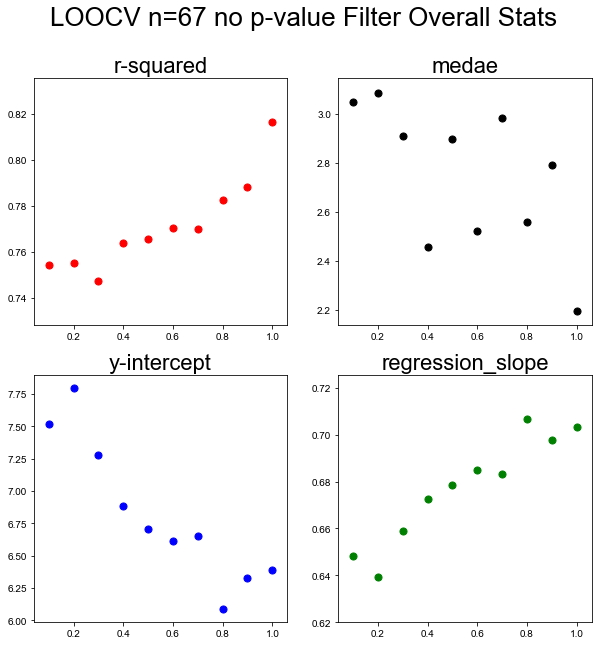

In [89]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(LOOCV_n67_noFilter_overall_stats['alpha'], LOOCV_n67_noFilter_overall_stats['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(LOOCV_n67_noFilter_overall_stats['alpha'], LOOCV_n67_noFilter_overall_stats['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(LOOCV_n67_noFilter_overall_stats['alpha'], LOOCV_n67_noFilter_overall_stats['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(LOOCV_n67_noFilter_overall_stats['alpha'], LOOCV_n67_noFilter_overall_stats['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('LOOCV n=67 no p-value Filter Overall Stats', fontsize = 26)

fig.savefig("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/compare_noFilter_LOOCV_overall_stats.pdf")

# LOOCV for 1+ good p-value aka remove bad p-value 

The mean absolute error is 3.6226945389241747
The median absolute error is 2.706709264709602
The mean absolute error for m is 4.047458743846148
The median absolute error for m is 2.6938151873945007
The mean absolute error for f is 3.1294199783696244
The median absolute error for f is 2.706709264709602
r-squared: 0.7480269422961157
p-value: 3.9692215787305796e-21
slope: 0.650997101484125
y-intercept for regression: 7.501908414608494
r-squared for m : 0.7143109045613223
p-value for m : 8.944401263604597e-11
slope for m : 0.6338932932330521
y-intercept for regression for m : 8.081950831336211
r-squared for f : 0.8000558308872472
p-value for f : 1.188985684749095e-11
slope for f : 0.6738501779194125
y-intercept for regression for f : 6.790114480483465


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a01_clock    0.1         136  all  3.622695   
1  LOOCV_samp_67_removeBad_a01_clock    0.1         136    m  4.047459   
2  LOOCV_samp_67_removeBad_a01_clock    0.1         136    f  3.129420   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.706709   0.748027  3.969222e-21          0.650997     7.501908  
1  2.693815   0.714311  8.944401e-11          0.633893     8.081951  
2  2.706709   0.800056  1.188986e-11          0.673850     6.790114

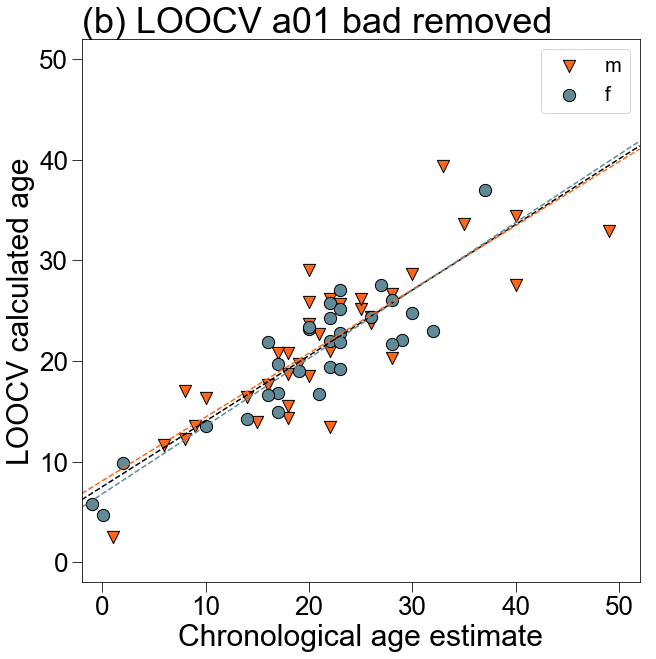

In [90]:
LOOCV_removeBad_KBO_samp_67_a01_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a01_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a01_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a01_clock", 0.1, len(samp_67_bad_pValue_removed_a01_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a01_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a01_sex_specific_fig.eps',
                                      "(b) LOOCV a01 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a01_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a01_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a01_stats_df

The mean absolute error is 3.7456434993073073
The median absolute error is 2.9445073775877013
The mean absolute error for m is 4.221963757705799
The median absolute error for m is 3.5333457946979507
The mean absolute error for f is 3.192497392780027
The median absolute error for f is 2.9204785112551974
r-squared: 0.733039708364116
p-value: 2.6208105259002056e-20
slope: 0.6451989303232292
y-intercept for regression: 7.470781108827033
r-squared for m : 0.6923740969933204
p-value for m : 3.191639056758457e-10
slope for m : 0.6257829158271031
y-intercept for regression for m : 8.052871318630432
r-squared for f : 0.7962357704281638
p-value for f : 1.5678820521321186e-11
slope for f : 0.6725229530822512
y-intercept for regression for f : 6.723454170573913


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a02_clock    0.2          74  all  3.745643   
1  LOOCV_samp_67_removeBad_a02_clock    0.2          74    m  4.221964   
2  LOOCV_samp_67_removeBad_a02_clock    0.2          74    f  3.192497   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.944507   0.733040  2.620811e-20          0.645199     7.470781  
1  3.533346   0.692374  3.191639e-10          0.625783     8.052871  
2  2.920479   0.796236  1.567882e-11          0.672523     6.723454

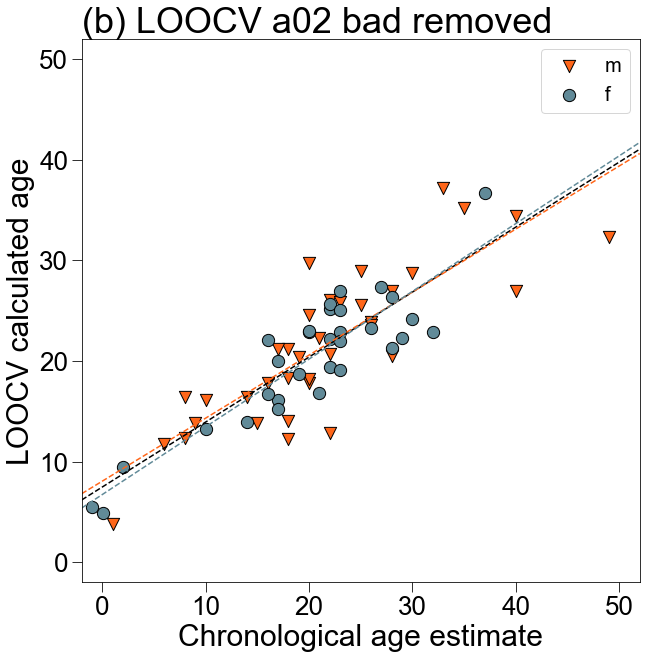

In [91]:
LOOCV_removeBad_KBO_samp_67_a02_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a02_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a02_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a02_clock", 0.2, len(samp_67_bad_pValue_removed_a02_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a02_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a02_sex_specific_fig.eps',
                                      "(b) LOOCV a02 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a02_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a02_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a02_stats_df

The mean absolute error is 3.766636457097245
The median absolute error is 3.1695477330424993
The mean absolute error for m is 4.310947555106883
The median absolute error for m is 3.2926910121305037
The mean absolute error for f is 3.134533246505406
The median absolute error for f is 2.9666788945681013
r-squared: 0.7324657144039524
p-value: 2.811345808604119e-20
slope: 0.650567528989621
y-intercept for regression: 7.3960016897938505
r-squared for m : 0.686724926701792
p-value for m : 4.3652303478889444e-10
slope for m : 0.6325315473505222
y-intercept for regression for m : 7.984409034739974
r-squared for f : 0.8057543440517468
p-value for f : 7.79241810354955e-12
slope for f : 0.6750866898237234
y-intercept for regression for f : 6.663890609927581


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a03_clock    0.3          56  all  3.766636   
1  LOOCV_samp_67_removeBad_a03_clock    0.3          56    m  4.310948   
2  LOOCV_samp_67_removeBad_a03_clock    0.3          56    f  3.134533   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.169548   0.732466  2.811346e-20          0.650568     7.396002  
1  3.292691   0.686725  4.365230e-10          0.632532     7.984409  
2  2.966679   0.805754  7.792418e-12          0.675087     6.663891

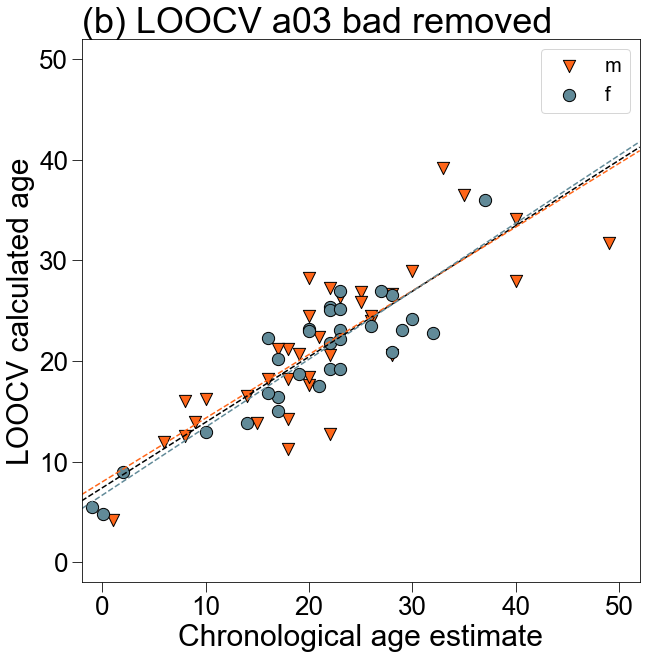

In [92]:
LOOCV_removeBad_KBO_samp_67_a03_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a03_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a03_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a03_clock", 0.3, len(samp_67_bad_pValue_removed_a03_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a03_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a03_sex_specific_fig.eps',
                                      "(b) LOOCV a03 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a03_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a03_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a03_stats_df

The mean absolute error is 3.6259494816369084
The median absolute error is 3.0671267776591016
The mean absolute error for m is 4.1834970563490925
The median absolute error for m is 3.218225968285845
The mean absolute error for f is 2.978474878745343
The median absolute error for f is 2.9184282745146994
r-squared: 0.7527016615281977
p-value: 2.1532060733121028e-21
slope: 0.654238957153004
y-intercept for regression: 7.163221484050675
r-squared for m : 0.7038799907594948
p-value for m : 1.6567893989649892e-10
slope for m : 0.6282805711939214
y-intercept for regression for m : 7.780884753765145
r-squared for f : 0.8287052078434946
p-value for f : 1.242326923693368e-12
slope for f : 0.6936747720136377
y-intercept for regression for f : 6.2916874248509504


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a04_clock    0.4          42  all  3.625949   
1  LOOCV_samp_67_removeBad_a04_clock    0.4          42    m  4.183497   
2  LOOCV_samp_67_removeBad_a04_clock    0.4          42    f  2.978475   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.067127   0.752702  2.153206e-21          0.654239     7.163221  
1  3.218226   0.703880  1.656789e-10          0.628281     7.780885  
2  2.918428   0.828705  1.242327e-12          0.693675     6.291687

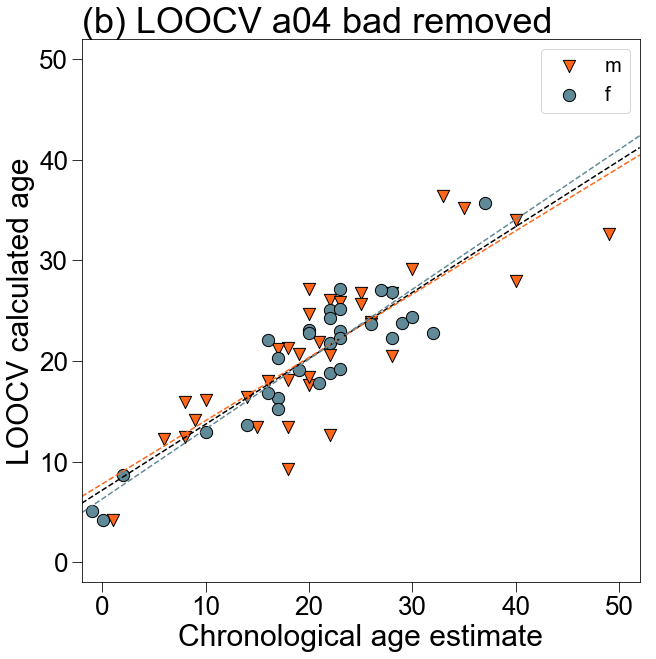

In [93]:
LOOCV_removeBad_KBO_samp_67_a04_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a04_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a04_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a04_clock", 0.4, len(samp_67_bad_pValue_removed_a04_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a04_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a04_sex_specific_fig.eps',
                                      "(b) LOOCV a04 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a04_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a04_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a04_stats_df

The mean absolute error is 3.6372647964055203
The median absolute error is 3.018071136841897
The mean absolute error for m is 4.186204131754613
The median absolute error for m is 3.3134528458152546
The mean absolute error for f is 2.9997868585807725
The median absolute error for f is 2.8402541390692004
r-squared: 0.7438355073857197
p-value: 6.803535505295018e-21
slope: 0.6502913806442204
y-intercept for regression: 7.2711653478921505
r-squared for m : 0.7001126594104327
p-value for m : 2.0591197108810396e-10
slope for m : 0.6235716328269638
y-intercept for regression for m : 7.985467076073915
r-squared for f : 0.8107646026664596
p-value for f : 5.319494735222574e-12
slope for f : 0.6894633295246159
y-intercept for regression for f : 6.311663493471745


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a05_clock    0.5          35  all  3.637265   
1  LOOCV_samp_67_removeBad_a05_clock    0.5          35    m  4.186204   
2  LOOCV_samp_67_removeBad_a05_clock    0.5          35    f  2.999787   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.018071   0.743836  6.803536e-21          0.650291     7.271165  
1  3.313453   0.700113  2.059120e-10          0.623572     7.985467  
2  2.840254   0.810765  5.319495e-12          0.689463     6.311663

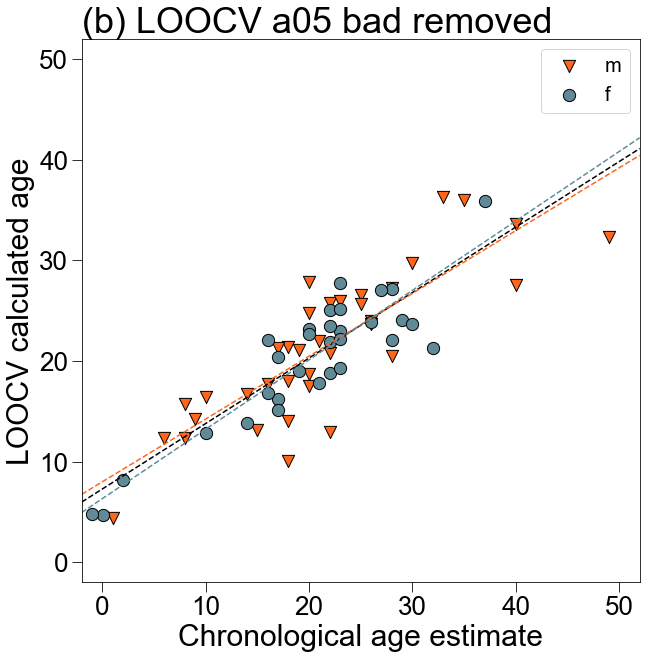

In [94]:
LOOCV_removeBad_KBO_samp_67_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a05_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a05_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a05_clock", 0.5, len(samp_67_bad_pValue_removed_a05_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a05_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a05_sex_specific_fig.eps',
                                      "(b) LOOCV a05 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a05_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a05_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a05_stats_df

The mean absolute error is 3.6372647964055203
The median absolute error is 3.018071136841897
The mean absolute error for m is 4.186204131754613
The median absolute error for m is 3.3134528458152546
The mean absolute error for f is 2.9997868585807725
The median absolute error for f is 2.8402541390692004
r-squared: 0.7438355073857197
p-value: 6.803535505295018e-21
slope: 0.6502913806442204
y-intercept for regression: 7.2711653478921505
r-squared for m : 0.7001126594104327
p-value for m : 2.0591197108810396e-10
slope for m : 0.6235716328269638
y-intercept for regression for m : 7.985467076073915
r-squared for f : 0.8107646026664596
p-value for f : 5.319494735222574e-12
slope for f : 0.6894633295246159
y-intercept for regression for f : 6.311663493471745


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a05_clock    0.5          35  all  3.637265   
1  LOOCV_samp_67_removeBad_a05_clock    0.5          35    m  4.186204   
2  LOOCV_samp_67_removeBad_a05_clock    0.5          35    f  2.999787   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.018071   0.743836  6.803536e-21          0.650291     7.271165  
1  3.313453   0.700113  2.059120e-10          0.623572     7.985467  
2  2.840254   0.810765  5.319495e-12          0.689463     6.311663

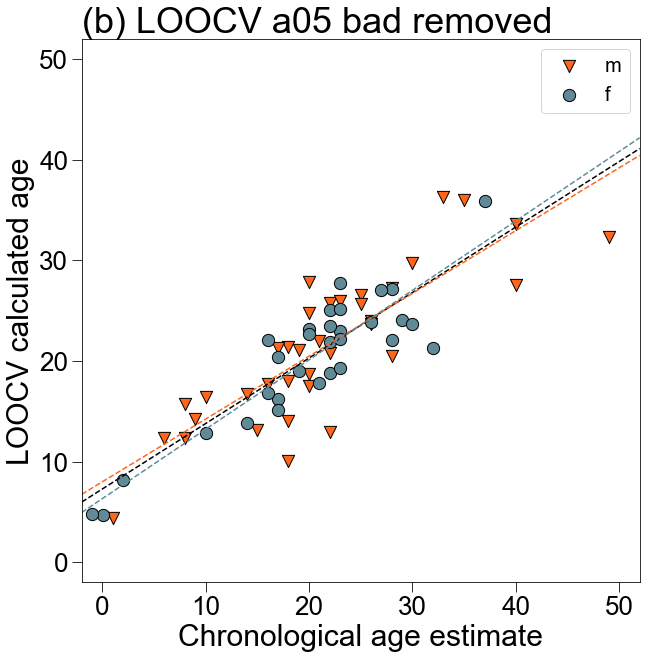

In [95]:
LOOCV_removeBad_KBO_samp_67_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a05_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a05_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a05_clock", 0.5, len(samp_67_bad_pValue_removed_a05_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a05_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a05_sex_specific_fig.eps',
                                      "(b) LOOCV a05 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a05_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a05_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a05_stats_df

The mean absolute error is 3.6268601498310296
The median absolute error is 3.0871917338853994
The mean absolute error for m is 4.197499853498418
The median absolute error for m is 3.271252978349847
The mean absolute error for f is 2.9641817842818
The median absolute error for f is 2.855973303723399
r-squared: 0.7493554469132025
p-value: 3.339799487368922e-21
slope: 0.658380802757022
y-intercept for regression: 7.134500927297381
r-squared for m : 0.7015586223037367
p-value for m : 1.894883945428266e-10
slope for m : 0.6345613932656317
y-intercept for regression for m : 7.819389092290356
r-squared for f : 0.8243973648145102
p-value for f : 1.7852192492951996e-12
slope for f : 0.692430219007659
y-intercept for regression for f : 6.2409052183166835


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a06_clock    0.6          30  all  3.626860   
1  LOOCV_samp_67_removeBad_a06_clock    0.6          30    m  4.197500   
2  LOOCV_samp_67_removeBad_a06_clock    0.6          30    f  2.964182   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.087192   0.749355  3.339799e-21          0.658381     7.134501  
1  3.271253   0.701559  1.894884e-10          0.634561     7.819389  
2  2.855973   0.824397  1.785219e-12          0.692430     6.240905

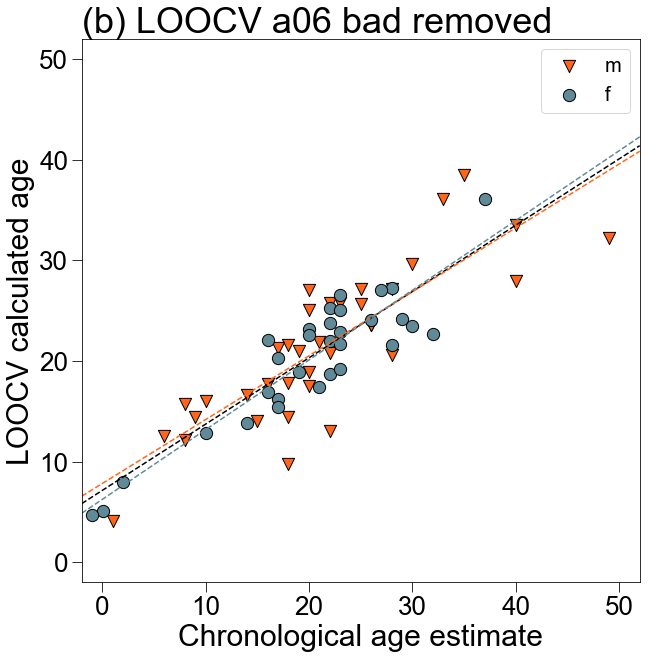

In [96]:
LOOCV_removeBad_KBO_samp_67_a06_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a06_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a06_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a06_clock", 0.6, len(samp_67_bad_pValue_removed_a06_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a06_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a06_sex_specific_fig.eps',
                                      "(b) LOOCV a06 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a06_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a06_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a06_stats_df

The mean absolute error is 3.6601569508836693
The median absolute error is 2.9766300836242934
The mean absolute error for m is 4.251478114751925
The median absolute error for m is 3.384516855708248
The mean absolute error for f is 2.9734614057463404
The median absolute error for f is 2.5769459362026996
r-squared: 0.7364820960340882
p-value: 1.7150271596158638e-20
slope: 0.653283667627869
y-intercept for regression: 7.21678864516478
r-squared for m : 0.6873952852535187
p-value for m : 4.207228605828271e-10
slope for m : 0.6275644268814287
y-intercept for regression for m : 7.992586113932115
r-squared for f : 0.8137368427811303
p-value for f : 4.221271434351199e-12
slope for f : 0.6893924787251502
y-intercept for regression for f : 6.223084201581953


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a07_clock    0.7          27  all  3.660157   
1  LOOCV_samp_67_removeBad_a07_clock    0.7          27    m  4.251478   
2  LOOCV_samp_67_removeBad_a07_clock    0.7          27    f  2.973461   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.976630   0.736482  1.715027e-20          0.653284     7.216789  
1  3.384517   0.687395  4.207229e-10          0.627564     7.992586  
2  2.576946   0.813737  4.221271e-12          0.689392     6.223084

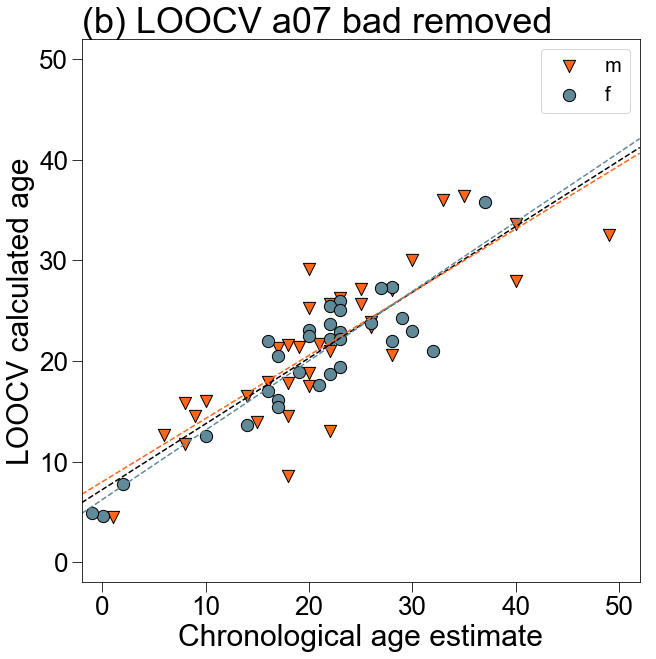

In [97]:
LOOCV_removeBad_KBO_samp_67_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a07_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a07_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a07_clock", 0.7, len(samp_67_bad_pValue_removed_a07_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a07_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a07_sex_specific_fig.eps',
                                      "(b) LOOCV a07 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a07_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a07_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a07_stats_df

The mean absolute error is 3.815084737574625
The median absolute error is 2.9979229665328013
The mean absolute error for m is 4.32200884412287
The median absolute error for m is 3.3193600808858608
The mean absolute error for f is 3.226398678357308
The median absolute error for f is 2.7592368476052993
r-squared: 0.7231608252622382
p-value: 8.592960038848944e-20
slope: 0.6506730363208333
y-intercept for regression: 7.226206310416323
r-squared for m : 0.6850052661779621
p-value for m : 4.796524238736813e-10
slope for m : 0.6341808459601758
y-intercept for regression for m : 7.825380710822959
r-squared for f : 0.7833526899389431
p-value for f : 3.8427732410293493e-11
slope for f : 0.6719875616066658
y-intercept for regression for f : 6.508175821094897


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a08_clock    0.8          26  all  3.815085   
1  LOOCV_samp_67_removeBad_a08_clock    0.8          26    m  4.322009   
2  LOOCV_samp_67_removeBad_a08_clock    0.8          26    f  3.226399   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.997923   0.723161  8.592960e-20          0.650673     7.226206  
1  3.319360   0.685005  4.796524e-10          0.634181     7.825381  
2  2.759237   0.783353  3.842773e-11          0.671988     6.508176

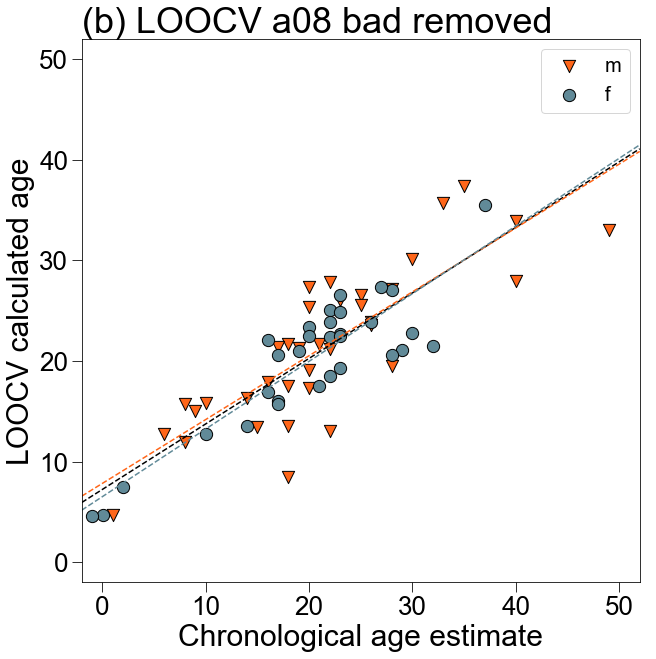

In [98]:
LOOCV_removeBad_KBO_samp_67_a08_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a08_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a08_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a08_clock", 0.8, len(samp_67_bad_pValue_removed_a08_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a08_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a08_sex_specific_fig.eps',
                                      "(b) LOOCV a08 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a08_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a08_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a08_stats_df

The mean absolute error is 3.6629854025531046
The median absolute error is 2.874587283001105
The mean absolute error for m is 4.144003354634317
The median absolute error for m is 3.686839992008199
The mean absolute error for f is 3.1043839098136345
The median absolute error for f is 2.4803172248621017
r-squared: 0.7450517529084452
p-value: 5.823974855649907e-21
slope: 0.6580362116123731
y-intercept for regression: 7.034718816261517
r-squared for m : 0.7113129253377983
p-value for m : 1.0702108519140889e-10
slope for m : 0.637422090025575
y-intercept for regression for m : 7.801434960873468
r-squared for f : 0.7982203198978417
p-value for f : 1.3588843561982108e-11
slope for f : 0.6843561157982175
y-intercept for regression for f : 6.123091738734921


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a09_clock    0.9          23  all  3.662985   
1  LOOCV_samp_67_removeBad_a09_clock    0.9          23    m  4.144003   
2  LOOCV_samp_67_removeBad_a09_clock    0.9          23    f  3.104384   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.874587   0.745052  5.823975e-21          0.658036     7.034719  
1  3.686840   0.711313  1.070211e-10          0.637422     7.801435  
2  2.480317   0.798220  1.358884e-11          0.684356     6.123092

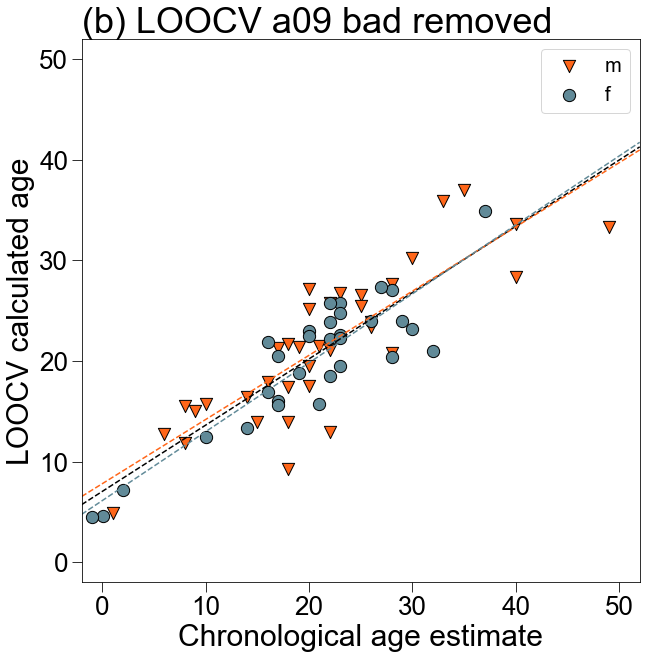

In [99]:
LOOCV_removeBad_KBO_samp_67_a09_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a09_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a09_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a09_clock", 0.9, len(samp_67_bad_pValue_removed_a09_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a09_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a09_sex_specific_fig.eps',
                                      "(b) LOOCV a09 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a09_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a09_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a09_stats_df

The mean absolute error is 3.7450532262926908
The median absolute error is 2.915320739582402
The mean absolute error for m is 4.247472015666023
The median absolute error for m is 3.106994551999451
The mean absolute error for f is 3.161599148310759
The median absolute error for f is 2.4904714300309987
r-squared: 0.7247448618031744
p-value: 7.123495000237378e-20
slope: 0.6573160952711458
y-intercept for regression: 7.144042496064241
r-squared for m : 0.6864436563746795
p-value for m : 4.433177207554543e-10
slope for m : 0.6320622635668851
y-intercept for regression for m : 7.91544172431051
r-squared for f : 0.7831661209134348
p-value for f : 3.8914642137359334e-11
slope for f : 0.6925970888936226
y-intercept for regression for f : 6.160658176746107


clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a1_clock    1.0          20  all  3.745053   
1  LOOCV_samp_67_removeBad_a1_clock    1.0          20    m  4.247472   
2  LOOCV_samp_67_removeBad_a1_clock    1.0          20    f  3.161599   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.915321   0.724745  7.123495e-20          0.657316     7.144042  
1  3.106995   0.686444  4.433177e-10          0.632062     7.915442  
2  2.490471   0.783166  3.891464e-11          0.692597     6.160658

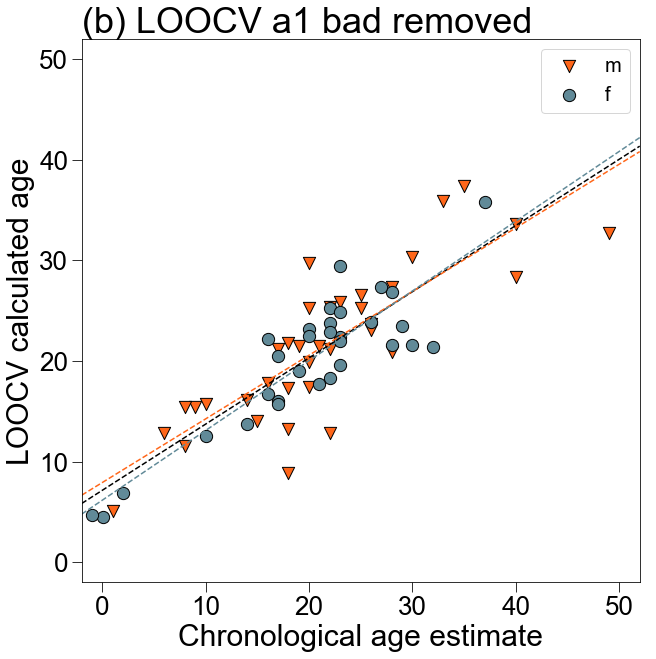

In [100]:
LOOCV_removeBad_KBO_samp_67_a1_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_67_a1_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_removeBad_KBO_samp_67_a1_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_removeBad_a1_clock", 1.0, len(samp_67_bad_pValue_removed_a1_clock['cpgs'])-1,
                                                                    LOOCV_removeBad_KBO_samp_67_a1_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_bad_removed_samp_67_a1_sex_specific_fig.eps',
                                      "(b) LOOCV a1 bad removed", "Chronological age estimate", "LOOCV calculated age")


LOOCV_removeBad_KBO_samp_67_a1_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_removed_samp_67_a1_sex_specific_stats.csv")
LOOCV_removeBad_KBO_samp_67_a1_stats_df

In [101]:

LOOCV_dfs_for_badRemoved_samp_67 = [LOOCV_removeBad_KBO_samp_67_a01_stats_df, LOOCV_removeBad_KBO_samp_67_a02_stats_df,
                                   LOOCV_removeBad_KBO_samp_67_a03_stats_df, LOOCV_removeBad_KBO_samp_67_a04_stats_df,
                                   LOOCV_removeBad_KBO_samp_67_a05_stats_df, LOOCV_removeBad_KBO_samp_67_a06_stats_df, 
                                   LOOCV_removeBad_KBO_samp_67_a07_stats_df, LOOCV_removeBad_KBO_samp_67_a08_stats_df,
                                   LOOCV_removeBad_KBO_samp_67_a09_stats_df, LOOCV_removeBad_KBO_samp_67_a1_stats_df]

stats_LOOCV_badRemoved_KBO_samp_67_clocks = pd.concat(LOOCV_dfs_for_badRemoved_samp_67)

stats_LOOCV_badRemoved_KBO_samp_67_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_LOOCV_badRemoved_KBO_samp_67_clocks.csv')


stats_LOOCV_badRemoved_KBO_samp_67_clocks

clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a01_clock    0.1         136  all  3.622695   
1  LOOCV_samp_67_removeBad_a01_clock    0.1         136    m  4.047459   
2  LOOCV_samp_67_removeBad_a01_clock    0.1         136    f  3.129420   
0  LOOCV_samp_67_removeBad_a02_clock    0.2          74  all  3.745643   
1  LOOCV_samp_67_removeBad_a02_clock    0.2          74    m  4.221964   
2  LOOCV_samp_67_removeBad_a02_clock    0.2          74    f  3.192497   
0  LOOCV_samp_67_removeBad_a03_clock    0.3          56  all  3.766636   
1  LOOCV_samp_67_removeBad_a03_clock    0.3          56    m  4.310948   
2  LOOCV_samp_67_removeBad_a03_clock    0.3          56    f  3.134533   
0  LOOCV_samp_67_removeBad_a04_clock    0.4          42  all  3.625949   
1  LOOCV_samp_67_removeBad_a04_clock    0.4          42    m  4.183497   
2  LOOCV_samp_67_removeBad_a04_clock    0.4          42    f  2.978475   
0  LOOCV_samp_67_removeBad_a05_clock    0.5          35  all  3.637265   
1  LOOCV_samp_67_removeBad_a05_clock    0.5          35    m  4.186204   
2  LOOCV_samp_67_removeBad_a05_clock    0.5          35    f  2.999787   
0  LOOCV_samp_67_removeBad_a06_clock    0.6          30  all  3.626860   
1  LOOCV_samp_67_removeBad_a06_clock    0.6          30    m  4.197500   
2  LOOCV_samp_67_removeBad_a06_clock    0.6          30    f  2.964182   
0  LOOCV_samp_67_removeBad_a07_clock    0.7          27  all  3.660157   
1  LOOCV_samp_67_removeBad_a07_clock    0.7          27    m  4.251478   
2  LOOCV_samp_67_removeBad_a07_clock    0.7          27    f  2.973461   
0  LOOCV_samp_67_removeBad_a08_clock    0.8          26  all  3.815085   
1  LOOCV_samp_67_removeBad_a08_clock    0.8          26    m  4.322009   
2  LOOCV_samp_67_removeBad_a08_clock    0.8          26    f  3.226399   
0  LOOCV_samp_67_removeBad_a09_clock    0.9          23  all  3.662985   
1  LOOCV_samp_67_removeBad_a09_clock    0.9          23    m  4.144003   
2  LOOCV_samp_67_removeBad_a09_clock    0.9          23    f  3.104384   
0   LOOCV_samp_67_removeBad_a1_clock    1.0          20  all  3.745053   
1   LOOCV_samp_67_removeBad_a1_clock    1.0          20    m  4.247472   
2   LOOCV_samp_67_removeBad_a1_clock    1.0          20    f  3.161599   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.706709   0.748027  3.969222e-21          0.650997     7.501908  
1  2.693815   0.714311  8.944401e-11          0.633893     8.081951  
2  2.706709   0.800056  1.188986e-11          0.673850     6.790114  
0  2.944507   0.733040  2.620811e-20          0.645199     7.470781  
1  3.533346   0.692374  3.191639e-10          0.625783     8.052871  
2  2.920479   0.796236  1.567882e-11          0.672523     6.723454  
0  3.169548   0.732466  2.811346e-20          0.650568     7.396002  
1  3.292691   0.686725  4.365230e-10          0.632532     7.984409  
2  2.966679   0.805754  7.792418e-12          0.675087     6.663891  
0  3.067127   0.752702  2.153206e-21          0.654239     7.163221  
1  3.218226   0.703880  1.656789e-10          0.628281     7.780885  
2  2.918428   0.828705  1.242327e-12          0.693675     6.291687  
0  3.018071   0.743836  6.803536e-21          0.650291     7.271165  
1  3.313453   0.700113  2.059120e-10          0.623572     7.985467  
2  2.840254   0.810765  5.319495e-12          0.689463     6.311663  
0  3.087192   0.749355  3.339799e-21          0.658381     7.134501  
1  3.271253   0.701559  1.894884e-10          0.634561     7.819389  
2  2.855973   0.824397  1.785219e-12          0.692430     6.240905  
0  2.976630   0.736482  1.715027e-20          0.653284     7.216789  
1  3.384517   0.687395  4.207229e-10          0.627564     7.992586  
2  2.576946   0.813737  4.221271e-12          0.689392     6.223084  
0  2.997923   0.723161  8.592960e-20          0.650673     7.226206  
1  3.319360   0.685005  4.796524e-10          0.634181     7.825381  
2  2.759237   0.783353  3.842773e-11          0.671

In [102]:
overall_stats_LOOCV_badRemoved_n67 = stats_LOOCV_badRemoved_KBO_samp_67_clocks[stats_LOOCV_badRemoved_KBO_samp_67_clocks['sex']=='all']
overall_stats_LOOCV_badRemoved_n67

clock_info  alpha  clock_size  sex       mae  \
0  LOOCV_samp_67_removeBad_a01_clock    0.1         136  all  3.622695   
0  LOOCV_samp_67_removeBad_a02_clock    0.2          74  all  3.745643   
0  LOOCV_samp_67_removeBad_a03_clock    0.3          56  all  3.766636   
0  LOOCV_samp_67_removeBad_a04_clock    0.4          42  all  3.625949   
0  LOOCV_samp_67_removeBad_a05_clock    0.5          35  all  3.637265   
0  LOOCV_samp_67_removeBad_a06_clock    0.6          30  all  3.626860   
0  LOOCV_samp_67_removeBad_a07_clock    0.7          27  all  3.660157   
0  LOOCV_samp_67_removeBad_a08_clock    0.8          26  all  3.815085   
0  LOOCV_samp_67_removeBad_a09_clock    0.9          23  all  3.662985   
0   LOOCV_samp_67_removeBad_a1_clock    1.0          20  all  3.745053   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.706709   0.748027  3.969222e-21          0.650997     7.501908  
0  2.944507   0.733040  2.620811e-20          0.645199     7.470781  
0  3.169548   0.732466  2.811346e-20          0.650568     7.396002  
0  3.067127   0.752702  2.153206e-21          0.654239     7.163221  
0  3.018071   0.743836  6.803536e-21          0.650291     7.271165  
0  3.087192   0.749355  3.339799e-21          0.658381     7.134501  
0  2.976630   0.736482  1.715027e-20          0.653284     7.216789  
0  2.997923   0.723161  8.592960e-20          0.650673     7.226206  
0  2.874587   0.745052  5.823975e-21          0.658036     7.034719  
0  2.915321   0.724745  7.123495e-20          0.657316     7.144042

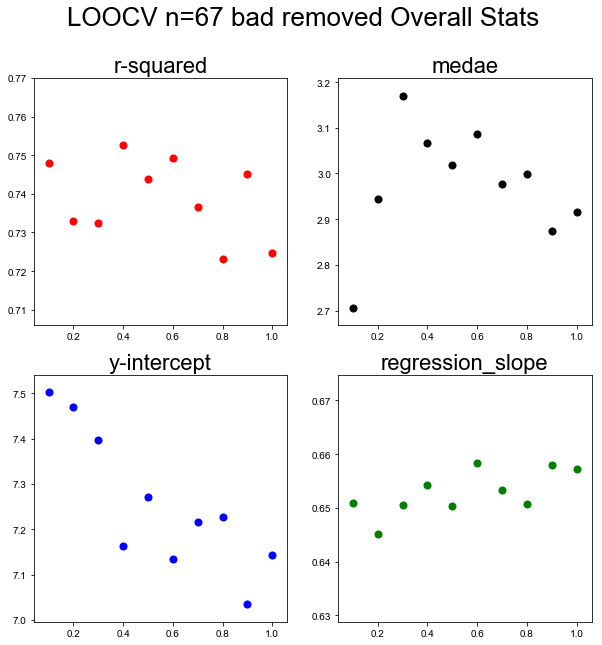

In [103]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(overall_stats_LOOCV_badRemoved_n67['alpha'], overall_stats_LOOCV_badRemoved_n67['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(overall_stats_LOOCV_badRemoved_n67['alpha'], overall_stats_LOOCV_badRemoved_n67['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(overall_stats_LOOCV_badRemoved_n67['alpha'], overall_stats_LOOCV_badRemoved_n67['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(overall_stats_LOOCV_badRemoved_n67['alpha'], overall_stats_LOOCV_badRemoved_n67['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('LOOCV n=67 bad removed Overall Stats', fontsize = 26)
fig.savefig("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/compare_badRemoved_LOOCV_overall_stats.pdf")

# LOOCV for 10+ "good" p-value sites 

The mean absolute error is 3.652590232644188
The median absolute error is 2.9006321948854
The mean absolute error for m is 4.091018048735412
The median absolute error for m is 3.0893566910959995
The mean absolute error for f is 3.1434482526672833
The median absolute error for f is 2.9006321948854
r-squared: 0.7447519059526579
p-value: 6.0519314711180635e-21
slope: 0.6557206441160477
y-intercept for regression: 7.360922931774036
r-squared for m : 0.7061125329816068
p-value for m : 1.454646268347918e-10
slope for m : 0.6362272167250791
y-intercept for regression for m : 7.974999081376092
r-squared for f : 0.8046859612706081
p-value for f : 8.442657685677327e-12
slope for f : 0.6826169476707347
y-intercept for regression for f : 6.5870400105699325


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a01_clock    0.1         134  all  3.652590  2.900632   
1  LOOCV_samp_67_10good_a01_clock    0.1         134    m  4.091018  3.089357   
2  LOOCV_samp_67_10good_a01_clock    0.1         134    f  3.143448  2.900632   

   r-squared       p-value  regression_slope  y-intercept  
0   0.744752  6.051931e-21          0.655721     7.360923  
1   0.706113  1.454646e-10          0.636227     7.974999  
2   0.804686  8.442658e-12          0.682617     6.587040

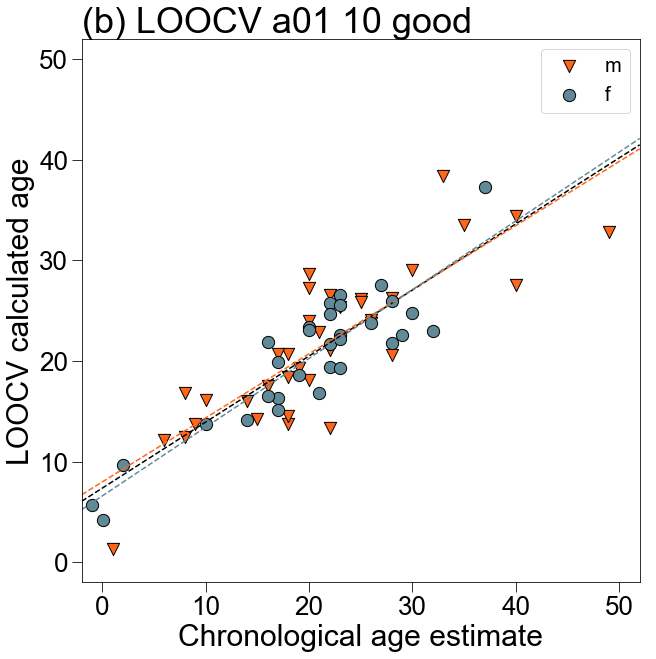

In [104]:
LOOCV_pValue_10good_samp_67_a01_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a01_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a01_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a01_clock", 0.1, len(samp_67_10good_a01_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a01_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a01_sex_specific_fig.eps',
                                      "(b) LOOCV a01 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a01_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a01_sex_specific_stats.csv")
LOOCV_samp_67_10good_a01_stats_df

The mean absolute error is 3.683125011942225
The median absolute error is 2.782129537665895
The mean absolute error for m is 4.148347019811889
The median absolute error for m is 2.9324265506476768
The mean absolute error for f is 3.142867196351646
The median absolute error for f is 2.782129537665895
r-squared: 0.7464882702249335
p-value: 4.842431450676486e-21
slope: 0.6416769874907604
y-intercept for regression: 7.516598860413239
r-squared for m : 0.707169064597638
p-value for m : 1.367310300972538e-10
slope for m : 0.6214252380447169
y-intercept for regression for m : 8.054056733683936
r-squared for f : 0.806918488546356
p-value for f : 7.1372169770998126e-12
slope for f : 0.6714378297536924
y-intercept for regression for f : 6.792488493005511


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a02_clock    0.2          71  all  3.683125  2.782130   
1  LOOCV_samp_67_10good_a02_clock    0.2          71    m  4.148347  2.932427   
2  LOOCV_samp_67_10good_a02_clock    0.2          71    f  3.142867  2.782130   

   r-squared       p-value  regression_slope  y-intercept  
0   0.746488  4.842431e-21          0.641677     7.516599  
1   0.707169  1.367310e-10          0.621425     8.054057  
2   0.806918  7.137217e-12          0.671438     6.792488

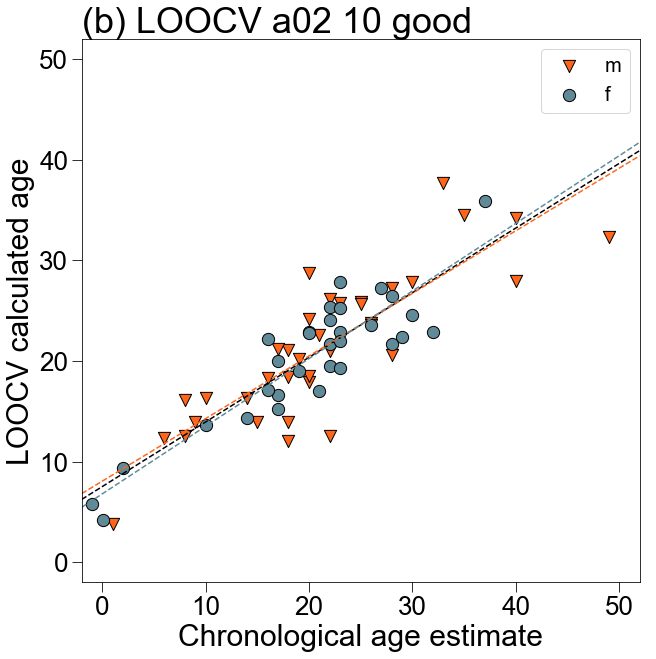

In [105]:
LOOCV_pValue_10good_samp_67_a02_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a02_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a02_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a02_clock", 0.2, len(samp_67_10good_a02_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a02_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a02_sex_specific_fig.eps',
                                      "(b) LOOCV a02 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a02_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a02_sex_specific_stats.csv")
LOOCV_samp_67_10good_a02_stats_df

The mean absolute error is 3.700261410424236
The median absolute error is 3.101063418671199
The mean absolute error for m is 4.2717973350050755
The median absolute error for m is 3.544794983760701
The mean absolute error for f is 3.0365422722013276
The median absolute error for f is 2.886250929698104
r-squared: 0.7429757986365207
p-value: 7.590427963529156e-21
slope: 0.662783731475001
y-intercept for regression: 7.152947526700265
r-squared for m : 0.6958023500631774
p-value for m : 2.6319808144432555e-10
slope for m : 0.6415696648708451
y-intercept for regression for m : 7.819407488019106
r-squared for f : 0.8180550181378137
p-value for f : 2.9968998286696133e-12
slope for f : 0.692087020307135
y-intercept for regression for f : 6.312201622256998


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a03_clock    0.3          53  all  3.700261  3.101063   
1  LOOCV_samp_67_10good_a03_clock    0.3          53    m  4.271797  3.544795   
2  LOOCV_samp_67_10good_a03_clock    0.3          53    f  3.036542  2.886251   

   r-squared       p-value  regression_slope  y-intercept  
0   0.742976  7.590428e-21          0.662784     7.152948  
1   0.695802  2.631981e-10          0.641570     7.819407  
2   0.818055  2.996900e-12          0.692087     6.312202

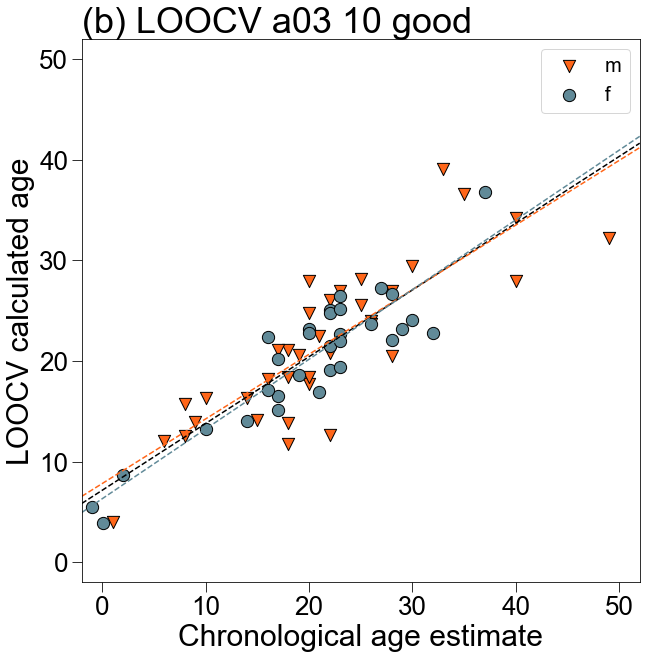

In [106]:
LOOCV_pValue_10good_samp_67_a03_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a03_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a03_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a03_clock", 0.3, len(samp_67_10good_a03_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a03_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a03_sex_specific_fig.eps',
                                      "(b) LOOCV a03 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a03_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a03_sex_specific_stats.csv")
LOOCV_samp_67_10good_a03_stats_df

The mean absolute error is 3.6197041535210026
The median absolute error is 2.9561421711883007
The mean absolute error for m is 4.150143211359765
The median absolute error for m is 3.0627904353058018
The mean absolute error for f is 3.003710408934056
The median absolute error for f is 2.743579352137198
r-squared: 0.7477039599920157
p-value: 4.138816014337634e-21
slope: 0.6515904420903814
y-intercept for regression: 7.2792665913809
r-squared for m : 0.7044441146900164
p-value for m : 1.6033485700520556e-10
slope for m : 0.630455568802426
y-intercept for regression for m : 7.865259378372647
r-squared for f : 0.8150152155909582
p-value for f : 3.817330182958381e-12
slope for f : 0.6821950371748012
y-intercept for regression for f : 6.5036332342034395


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a04_clock    0.4          40  all  3.619704  2.956142   
1  LOOCV_samp_67_10good_a04_clock    0.4          40    m  4.150143  3.062790   
2  LOOCV_samp_67_10good_a04_clock    0.4          40    f  3.003710  2.743579   

   r-squared       p-value  regression_slope  y-intercept  
0   0.747704  4.138816e-21          0.651590     7.279267  
1   0.704444  1.603349e-10          0.630456     7.865259  
2   0.815015  3.817330e-12          0.682195     6.503633

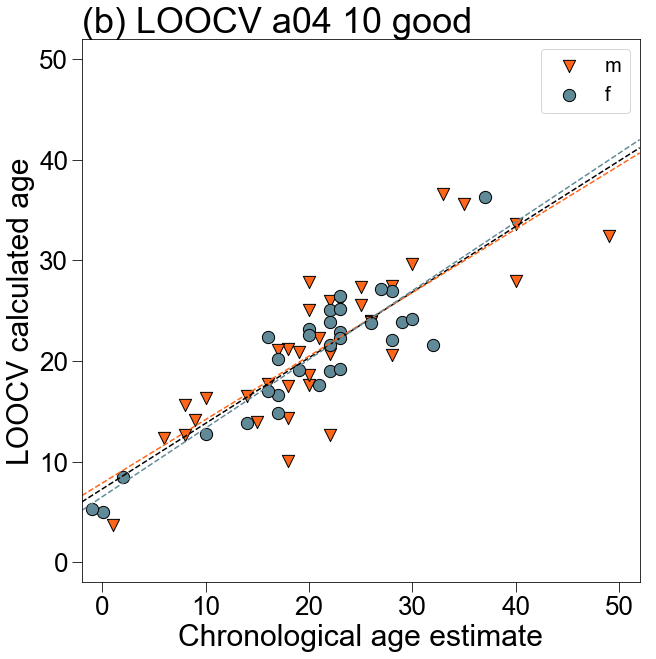

In [107]:
LOOCV_pValue_10good_samp_67_a04_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a04_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a04_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a04_clock", 0.4, len(samp_67_10good_a04_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a04_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a04_sex_specific_fig.eps',
                                      "(b) LOOCV a04 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a04_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a04_sex_specific_stats.csv")
LOOCV_samp_67_10good_a04_stats_df

The mean absolute error is 3.58492957112451
The median absolute error is 2.9900650917628013
The mean absolute error for m is 4.151333922760325
The median absolute error for m is 3.202450058335552
The mean absolute error for f is 2.927169678902273
The median absolute error for f is 2.7430261668295
r-squared: 0.7458268795049362
p-value: 5.2725925867303836e-21
slope: 0.6526637178545184
y-intercept for regression: 7.135523782944018
r-squared for m : 0.6980320778889844
p-value for m : 2.3191279018739079e-10
slope for m : 0.6235026340057267
y-intercept for regression for m : 7.895357319769248
r-squared for f : 0.8193211210803453
p-value for f : 2.706374910801403e-12
slope for f : 0.6957717157290136
y-intercept for regression for f : 6.104036485295335


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a05_clock    0.5          34  all  3.584930  2.990065   
1  LOOCV_samp_67_10good_a05_clock    0.5          34    m  4.151334  3.202450   
2  LOOCV_samp_67_10good_a05_clock    0.5          34    f  2.927170  2.743026   

   r-squared       p-value  regression_slope  y-intercept  
0   0.745827  5.272593e-21          0.652664     7.135524  
1   0.698032  2.319128e-10          0.623503     7.895357  
2   0.819321  2.706375e-12          0.695772     6.104036

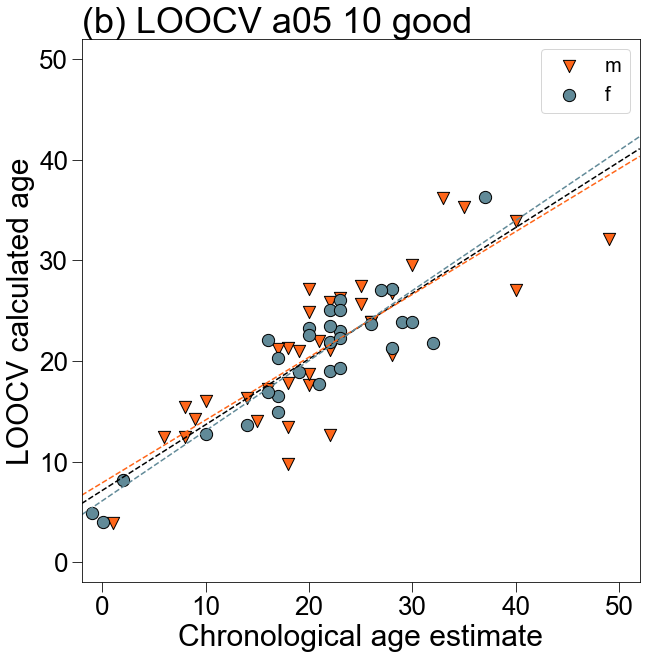

In [108]:
LOOCV_pValue_10good_samp_67_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a05_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_10good_a05_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a05_clock", 0.5, len(samp_67_10good_a05_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a05_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a05_sex_specific_fig.eps',
                                      "(b) LOOCV a05 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a05_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a05_sex_specific_stats.csv")
LOOCV_samp_67_10good_a05_stats_df

The mean absolute error is 3.605758889209252
The median absolute error is 3.0424528733638
The mean absolute error for m is 4.172925146447775
The median absolute error for m is 3.253587427209027
The mean absolute error for f is 2.9471142033838724
The median absolute error for f is 2.694423354007599
r-squared: 0.7436526788580174
p-value: 6.963957891045011e-21
slope: 0.6525750216253103
y-intercept for regression: 7.220472493990254
r-squared for m : 0.699822383327302
p-value for m : 2.0936679130787446e-10
slope for m : 0.6251989215504519
y-intercept for regression for m : 7.9873798604022745
r-squared for f : 0.8108764598633843
p-value for f : 5.273747214830927e-12
slope for f : 0.6920749560158399
y-intercept for regression for f : 6.209537754510144


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a06_clock    0.6          29  all  3.605759  3.042453   
1  LOOCV_samp_67_10good_a06_clock    0.6          29    m  4.172925  3.253587   
2  LOOCV_samp_67_10good_a06_clock    0.6          29    f  2.947114  2.694423   

   r-squared       p-value  regression_slope  y-intercept  
0   0.743653  6.963958e-21          0.652575     7.220472  
1   0.699822  2.093668e-10          0.625199     7.987380  
2   0.810876  5.273747e-12          0.692075     6.209538

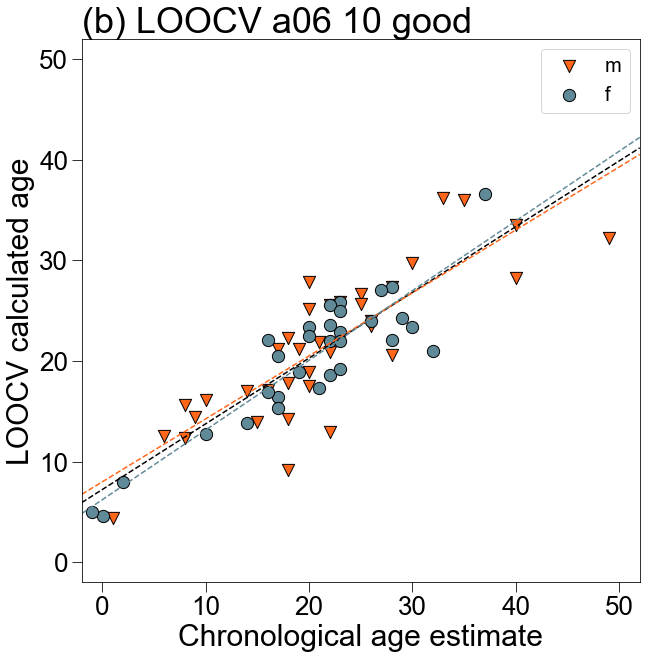

In [109]:
LOOCV_pValue_10good_samp_67_a06_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a06_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a06_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a06_clock", 0.6, len(samp_67_10good_a06_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a06_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a06_sex_specific_fig.eps',
                                      "(b) LOOCV a06 10 good", "Chronological age estimate", "LOOCV calculated age")


LOOCV_samp_67_10good_a06_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a06_sex_specific_stats.csv")
LOOCV_samp_67_10good_a06_stats_df

The mean absolute error is 3.746984222018037
The median absolute error is 3.041916362385603
The mean absolute error for m is 4.299786954650721
The median absolute error for m is 3.5799862161285017
The mean absolute error for f is 3.1050197583155676
The median absolute error for f is 2.5474191859781
r-squared: 0.7341357772752093
p-value: 2.2911526933784086e-20
slope: 0.6543287113680543
y-intercept for regression: 7.205737113028579
r-squared for m : 0.6913661367156492
p-value for m : 3.376428331851303e-10
slope for m : 0.6312607673715068
y-intercept for regression for m : 7.966087509236216
r-squared for f : 0.8012926392567281
p-value for f : 1.0859075046076052e-11
slope for f : 0.6855478704374717
y-intercept for regression for f : 6.263187074395214


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a07_clock    0.7          27  all  3.746984  3.041916   
1  LOOCV_samp_67_10good_a07_clock    0.7          27    m  4.299787  3.579986   
2  LOOCV_samp_67_10good_a07_clock    0.7          27    f  3.105020  2.547419   

   r-squared       p-value  regression_slope  y-intercept  
0   0.734136  2.291153e-20          0.654329     7.205737  
1   0.691366  3.376428e-10          0.631261     7.966088  
2   0.801293  1.085908e-11          0.685548     6.263187

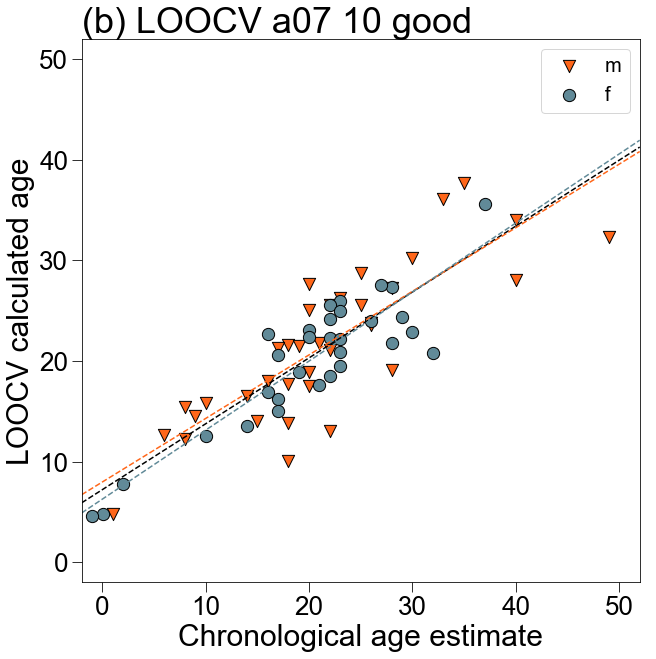

In [110]:
LOOCV_pValue_10good_samp_67_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a07_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)

LOOCV_samp_67_10good_a07_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a07_clock", 0.7, len(samp_67_10good_a07_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a07_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a07_sex_specific_fig.eps',
                                      "(b) LOOCV a07 10 good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a07_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a07_sex_specific_stats.csv")
LOOCV_samp_67_10good_a07_stats_df

The mean absolute error is 3.7374349552563637
The median absolute error is 3.1513282098079998
The mean absolute error for m is 4.32722920299003
The median absolute error for m is 3.644450779364837
The mean absolute error for f is 3.052512603049528
The median absolute error for f is 2.7592368476052993
r-squared: 0.7379299108953828
p-value: 1.4325162989462924e-20
slope: 0.6630003251014799
y-intercept for regression: 7.04246368189626
r-squared for m : 0.6930602547166866
p-value for m : 3.071346848032287e-10
slope for m : 0.6396565579829772
y-intercept for regression for m : 7.7573811354863675
r-squared for f : 0.808178107849163
p-value for f : 6.4863414026687856e-12
slope for f : 0.6955791552346787
y-intercept for regression for f : 6.131976880133076


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a08_clock    0.8          26  all  3.737435  3.151328   
1  LOOCV_samp_67_10good_a08_clock    0.8          26    m  4.327229  3.644451   
2  LOOCV_samp_67_10good_a08_clock    0.8          26    f  3.052513  2.759237   

   r-squared       p-value  regression_slope  y-intercept  
0   0.737930  1.432516e-20          0.663000     7.042464  
1   0.693060  3.071347e-10          0.639657     7.757381  
2   0.808178  6.486341e-12          0.695579     6.131977

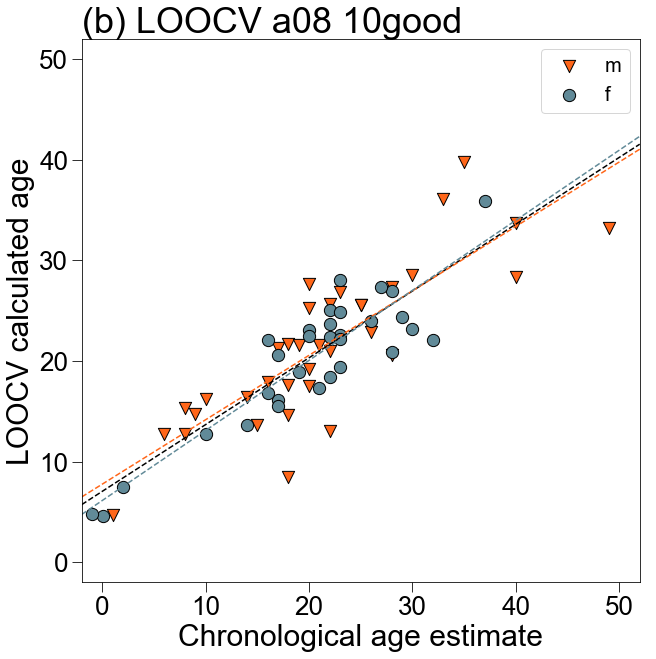

In [111]:
LOOCV_pValue_10good_samp_67_a08_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a08_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_10good_a08_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a08_clock", 0.8, len(samp_67_10good_a08_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a08_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a08_sex_specific_fig.eps',
                                      "(b) LOOCV a08 10good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a08_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a08_sex_specific_stats.csv")
LOOCV_samp_67_10good_a08_stats_df

The mean absolute error is 3.6510263233225078
The median absolute error is 2.874587283001105
The mean absolute error for m is 4.156956455305601
The median absolute error for m is 2.9822482089501996
The mean absolute error for f is 3.0634945571485916
The median absolute error for f is 2.564152361263499
r-squared: 0.7397531692010764
p-value: 1.1403669115265027e-20
slope: 0.6536817023278738
y-intercept for regression: 7.225496373642974
r-squared for m : 0.697781762761094
p-value for m : 2.3524168814330025e-10
slope for m : 0.6309335493921245
y-intercept for regression for m : 8.006750811295165
r-squared for f : 0.8061148302809488
p-value for f : 7.583769583707905e-12
slope for f : 0.6838992126268197
y-intercept for regression for f : 6.2710221732004


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a09_clock    0.9          23  all  3.651026  2.874587   
1  LOOCV_samp_67_10good_a09_clock    0.9          23    m  4.156956  2.982248   
2  LOOCV_samp_67_10good_a09_clock    0.9          23    f  3.063495  2.564152   

   r-squared       p-value  regression_slope  y-intercept  
0   0.739753  1.140367e-20          0.653682     7.225496  
1   0.697782  2.352417e-10          0.630934     8.006751  
2   0.806115  7.583770e-12          0.683899     6.271022

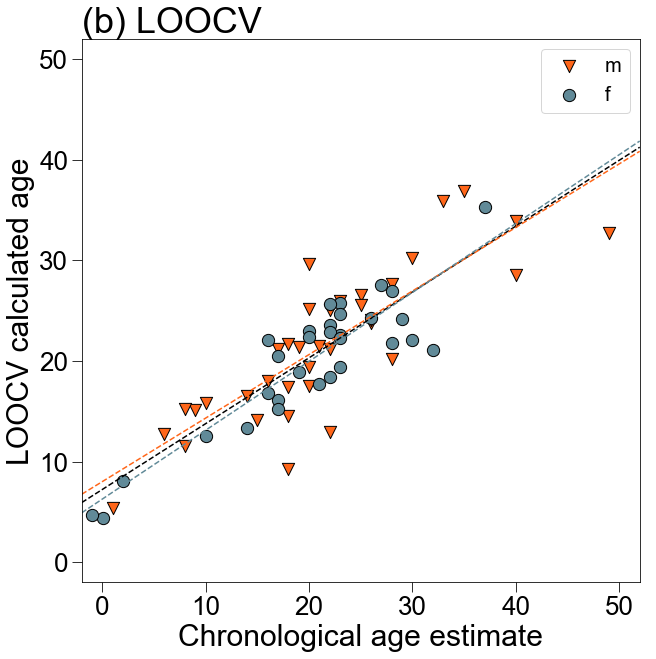

In [173]:
LOOCV_pValue_10good_samp_67_a09_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a09_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_10good_a09_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a09_clock", 0.9, len(samp_67_10good_a09_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a09_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a09_sex_specific_fig.eps',
                                      "(b) LOOCV", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a09_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a09_sex_specific_stats.csv")

LOOCV_samp_67_10good_a09_stats_df

The mean absolute error is 3.664628707730298
The median absolute error is 2.8258244673877044
The mean absolute error for m is 4.198578659046658
The median absolute error for m is 2.9845720333428023
The mean absolute error for f is 3.0445577965242006
The median absolute error for f is 2.630664673378199
r-squared: 0.73867014899637
p-value: 1.3060694960170604e-20
slope: 0.6639303135650617
y-intercept for regression: 7.037188451076881
r-squared for m : 0.6962216428607718
p-value for m : 2.5702677216276827e-10
slope for m : 0.6337706481478681
y-intercept for regression for m : 7.990452468968618
r-squared for f : 0.8046810448290806
p-value for f : 8.445763530311364e-12
slope for f : 0.7054859078028909
y-intercept for regression for f : 5.837329386120622


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a1_clock    1.0          20  all  3.664629  2.825824   
1  LOOCV_samp_67_10good_a1_clock    1.0          20    m  4.198579  2.984572   
2  LOOCV_samp_67_10good_a1_clock    1.0          20    f  3.044558  2.630665   

   r-squared       p-value  regression_slope  y-intercept  
0   0.738670  1.306069e-20          0.663930     7.037188  
1   0.696222  2.570268e-10          0.633771     7.990452  
2   0.804681  8.445764e-12          0.705486     5.837329

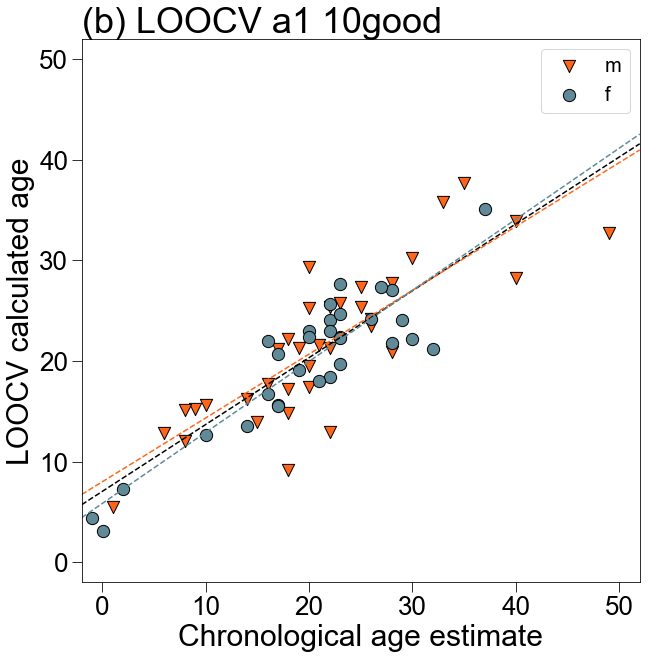

In [114]:
LOOCV_pValue_10good_samp_67_a1_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_67_a1_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_10good_a1_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_10good_a1_clock", 1.0, len(samp_67_10good_a1_clock['cpgs'])-1,
                                                                    LOOCV_pValue_10good_samp_67_a1_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a1_sex_specific_fig.eps',
                                      "(b) LOOCV a1 10good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_10good_a1_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_67_a1_sex_specific_stats.csv")
LOOCV_samp_67_10good_a1_stats_df

In [115]:

LOOCV_dfs_10good_samp_67 = [LOOCV_samp_67_10good_a01_stats_df, LOOCV_samp_67_10good_a02_stats_df,
                           LOOCV_samp_67_10good_a03_stats_df, LOOCV_samp_67_10good_a04_stats_df, 
                           LOOCV_samp_67_10good_a05_stats_df, LOOCV_samp_67_10good_a06_stats_df,
                           LOOCV_samp_67_10good_a07_stats_df, LOOCV_samp_67_10good_a08_stats_df,
                           LOOCV_samp_67_10good_a09_stats_df, LOOCV_samp_67_10good_a1_stats_df]

stats_LOOCV_dfs_10good_samp_67_clocks = pd.concat(LOOCV_dfs_10good_samp_67)

stats_LOOCV_dfs_10good_samp_67_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_LOOCV_dfs_10good_samp_67_clocks.csv')


stats_LOOCV_dfs_10good_samp_67_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a01_clock    0.1         134  all  3.652590  2.900632   
1  LOOCV_samp_67_10good_a01_clock    0.1         134    m  4.091018  3.089357   
2  LOOCV_samp_67_10good_a01_clock    0.1         134    f  3.143448  2.900632   
0  LOOCV_samp_67_10good_a02_clock    0.2          71  all  3.683125  2.782130   
1  LOOCV_samp_67_10good_a02_clock    0.2          71    m  4.148347  2.932427   
2  LOOCV_samp_67_10good_a02_clock    0.2          71    f  3.142867  2.782130   
0  LOOCV_samp_67_10good_a03_clock    0.3          53  all  3.700261  3.101063   
1  LOOCV_samp_67_10good_a03_clock    0.3          53    m  4.271797  3.544795   
2  LOOCV_samp_67_10good_a03_clock    0.3          53    f  3.036542  2.886251   
0  LOOCV_samp_67_10good_a04_clock    0.4          40  all  3.619704  2.956142   
1  LOOCV_samp_67_10good_a04_clock    0.4          40    m  4.150143  3.062790   
2  LOOCV_samp_67_10good_a04_clock    0.4          40    f  3.003710  2.743579   
0  LOOCV_samp_67_10good_a05_clock    0.5          34  all  3.584930  2.990065   
1  LOOCV_samp_67_10good_a05_clock    0.5          34    m  4.151334  3.202450   
2  LOOCV_samp_67_10good_a05_clock    0.5          34    f  2.927170  2.743026   
0  LOOCV_samp_67_10good_a06_clock    0.6          29  all  3.605759  3.042453   
1  LOOCV_samp_67_10good_a06_clock    0.6          29    m  4.172925  3.253587   
2  LOOCV_samp_67_10good_a06_clock    0.6          29    f  2.947114  2.694423   
0  LOOCV_samp_67_10good_a07_clock    0.7          27  all  3.746984  3.041916   
1  LOOCV_samp_67_10good_a07_clock    0.7          27    m  4.299787  3.579986   
2  LOOCV_samp_67_10good_a07_clock    0.7          27    f  3.105020  2.547419   
0  LOOCV_samp_67_10good_a08_clock    0.8          26  all  3.737435  3.151328   
1  LOOCV_samp_67_10good_a08_clock    0.8          26    m  4.327229  3.644451   
2  LOOCV_samp_67_10good_a08_clock    0.8          26    f  3.052513  2.759237   
0  LOOCV_samp_67_10good_a09_clock    0.9          23  all  3.651026  2.874587   
1  LOOCV_samp_67_10good_a09_clock    0.9          23    m  4.156956  2.982248   
2  LOOCV_samp_67_10good_a09_clock    0.9          23    f  3.063495  2.564152   
0   LOOCV_samp_67_10good_a1_clock    1.0          20  all  3.664629  2.825824   
1   LOOCV_samp_67_10good_a1_clock    1.0          20    m  4.198579  2.984572   
2   LOOCV_samp_67_10good_a1_clock    1.0          20    f  3.044558  2.630665   

   r-squared       p-value  regression_slope  y-intercept  
0   0.744752  6.051931e-21          0.655721     7.360923  
1   0.706113  1.454646e-10          0.636227     7.974999  
2   0.804686  8.442658e-12          0.682617     6.587040  
0   0.746488  4.842431e-21          0.641677     7.516599  
1   0.707169  1.367310e-10          0.621425     8.054057  
2   0.806918  7.137217e-12          0.671438     6.792488  
0   0.742976  7.590428e-21          0.662784     7.152948  
1   0.695802  2.631981e-10          0.641570     7.819407  
2   0.818055  2.996900e-12          0.692087     6.312202  
0   0.747704  4.138816e-21          0.651590     7.279267  
1   0.704444  1.603349e-10          0.630456     7.865259  
2   0.815015  3.817330e-12          0.682195     6.503633  
0   0.745827  5.272593e-21          0.652664     7.135524  
1   0.698032  2.319128e-10          0.623503     7.895357  
2   0.819321  2.706375e-12          0.695772     6.104036  
0   0.743653  6.963958e-21          0.652575     7.220472  
1   0.699822  2.093668e-10          0.625199     7.987380  
2   0.810876  5.273747e-12          0.692075     6.209538  
0   0.734136  2.291153e-20          0.654329     7.205737  
1   0.691366  3.376428e-10          0.631261     7.966088  
2   0.801293  1.085908e-11          0.685548     6.263187  
0   0.737930  1.432516e-20          0.663000     7.042464  
1   0.693060  3.071347e-10          0.639657     7.757381  
2   0.808178  6.486341e-12          0.695579     6.131977  
0   0.73975

In [116]:
LOOCV_n67_10good_overall_stats = stats_LOOCV_dfs_10good_samp_67_clocks[stats_LOOCV_dfs_10good_samp_67_clocks['sex']=='all']
LOOCV_n67_10good_overall_stats

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_10good_a01_clock    0.1         134  all  3.652590  2.900632   
0  LOOCV_samp_67_10good_a02_clock    0.2          71  all  3.683125  2.782130   
0  LOOCV_samp_67_10good_a03_clock    0.3          53  all  3.700261  3.101063   
0  LOOCV_samp_67_10good_a04_clock    0.4          40  all  3.619704  2.956142   
0  LOOCV_samp_67_10good_a05_clock    0.5          34  all  3.584930  2.990065   
0  LOOCV_samp_67_10good_a06_clock    0.6          29  all  3.605759  3.042453   
0  LOOCV_samp_67_10good_a07_clock    0.7          27  all  3.746984  3.041916   
0  LOOCV_samp_67_10good_a08_clock    0.8          26  all  3.737435  3.151328   
0  LOOCV_samp_67_10good_a09_clock    0.9          23  all  3.651026  2.874587   
0   LOOCV_samp_67_10good_a1_clock    1.0          20  all  3.664629  2.825824   

   r-squared       p-value  regression_slope  y-intercept  
0   0.744752  6.051931e-21          0.655721     7.360923  
0   0.746488  4.842431e-21          0.641677     7.516599  
0   0.742976  7.590428e-21          0.662784     7.152948  
0   0.747704  4.138816e-21          0.651590     7.279267  
0   0.745827  5.272593e-21          0.652664     7.135524  
0   0.743653  6.963958e-21          0.652575     7.220472  
0   0.734136  2.291153e-20          0.654329     7.205737  
0   0.737930  1.432516e-20          0.663000     7.042464  
0   0.739753  1.140367e-20          0.653682     7.225496  
0   0.738670  1.306069e-20          0.663930     7.037188

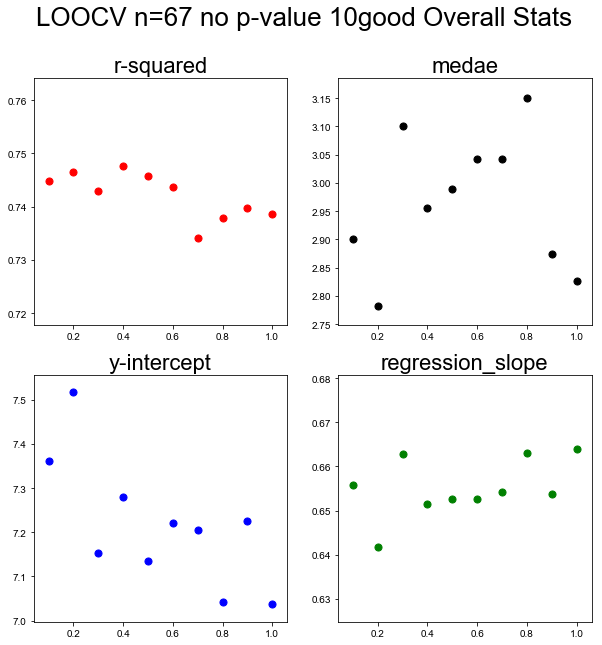

In [117]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(LOOCV_n67_10good_overall_stats['alpha'], LOOCV_n67_10good_overall_stats['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(LOOCV_n67_10good_overall_stats['alpha'], LOOCV_n67_10good_overall_stats['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(LOOCV_n67_10good_overall_stats['alpha'], LOOCV_n67_10good_overall_stats['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(LOOCV_n67_10good_overall_stats['alpha'], LOOCV_n67_10good_overall_stats['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('LOOCV n=67 no p-value 10good Overall Stats', fontsize = 26)

fig.savefig("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/compare_10good_LOOCV_overall_stats.pdf")

# 20 good

The mean absolute error is 3.5852033698450776
The median absolute error is 3.0080223385553992
The mean absolute error for m is 3.925964883476101
The median absolute error for m is 2.9367793158597006
The mean absolute error for f is 3.189480321757439
The median absolute error for f is 3.020730866333899
r-squared: 0.7561335890886608
p-value: 1.364226817602265e-21
slope: 0.6537880750961699
y-intercept for regression: 7.305407258534785
r-squared for m : 0.7250852825526668
p-value for m : 4.620755466603219e-11
slope for m : 0.6418489931304041
y-intercept for regression for m : 7.6681219876833815
r-squared for f : 0.8040053972632081
p-value for f : 8.88286641905183e-12
slope for f : 0.6705033488348552
y-intercept for regression for f : 6.842068530438713


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a01_clock    0.1         133  all  3.585203  3.008022   
1  LOOCV_samp_67_20good_a01_clock    0.1         133    m  3.925965  2.936779   
2  LOOCV_samp_67_20good_a01_clock    0.1         133    f  3.189480  3.020731   

   r-squared       p-value  regression_slope  y-intercept  
0   0.756134  1.364227e-21          0.653788     7.305407  
1   0.725085  4.620755e-11          0.641849     7.668122  
2   0.804005  8.882866e-12          0.670503     6.842069

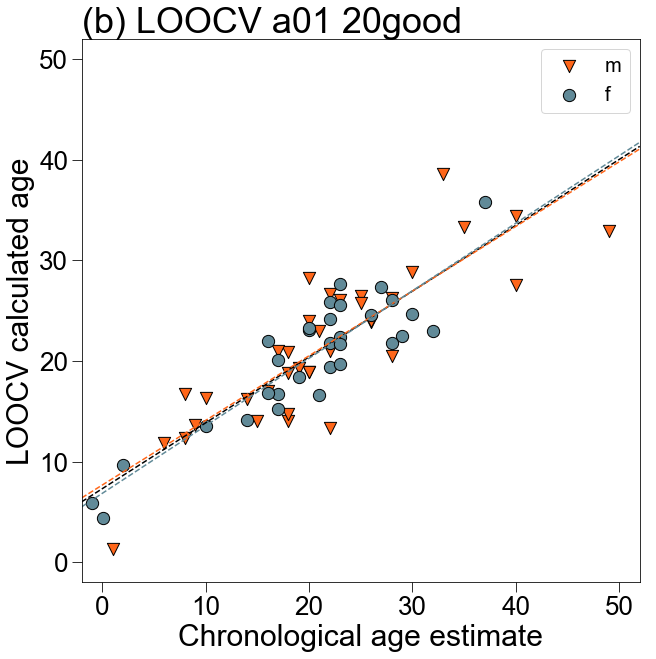

In [118]:
LOOCV_pValue_20good_samp_67_a01_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a01_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a01_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a01_clock", 0.1, len(samp_67_20good_a01_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a01_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a01_sex_specific_fig.eps',
                                      "(b) LOOCV a01 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a01_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a01_sex_specific_stats.csv")
LOOCV_samp_67_20good_a01_stats_df

The mean absolute error is 3.6398628090661846
The median absolute error is 2.7879834776623973
The mean absolute error for m is 4.034210112730011
The median absolute error for m is 2.838865563001649
The mean absolute error for f is 3.1819111015856127
The median absolute error for f is 2.7879834776623973
r-squared: 0.7535852619771917
p-value: 1.9156617627710675e-21
slope: 0.6455974713267276
y-intercept for regression: 7.363065969313579
r-squared for m : 0.7191279207870848
p-value for m : 6.678100087691283e-11
slope for m : 0.6305805413158592
y-intercept for regression for m : 7.790738139791072
r-squared for f : 0.8066995367979135
p-value for f : 7.256383857519577e-12
slope for f : 0.6671383467321654
y-intercept for regression for f : 6.802969650894978


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a02_clock    0.2          72  all  3.639863  2.787983   
1  LOOCV_samp_67_20good_a02_clock    0.2          72    m  4.034210  2.838866   
2  LOOCV_samp_67_20good_a02_clock    0.2          72    f  3.181911  2.787983   

   r-squared       p-value  regression_slope  y-intercept  
0   0.753585  1.915662e-21          0.645597     7.363066  
1   0.719128  6.678100e-11          0.630581     7.790738  
2   0.806700  7.256384e-12          0.667138     6.802970

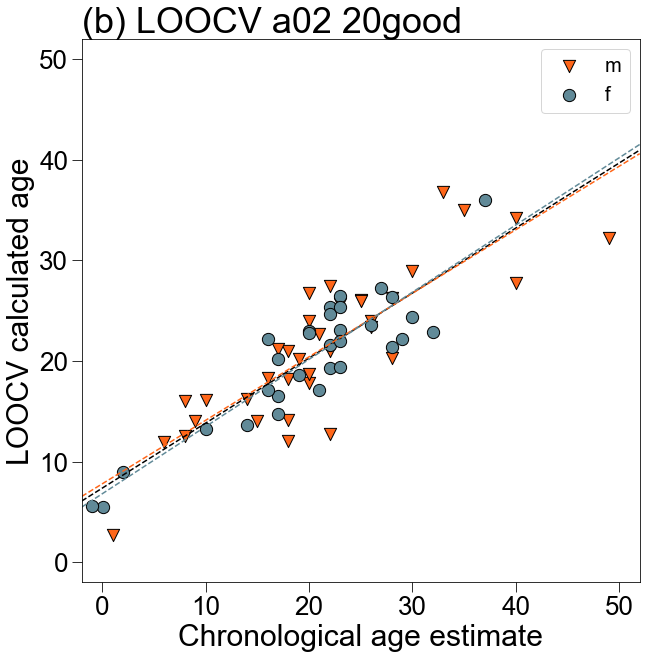

In [119]:
LOOCV_pValue_20good_samp_67_a02_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a02_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a02_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a02_clock", 0.2, len(samp_67_20good_a02_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a02_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a02_sex_specific_fig.eps',
                                      "(b) LOOCV a02 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a02_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a02_sex_specific_stats.csv")
LOOCV_samp_67_20good_a02_stats_df

The mean absolute error is 3.649137075699496
The median absolute error is 2.9070421530859
The mean absolute error for m is 4.094931487899319
The median absolute error for m is 2.976117814780899
The mean absolute error for f is 3.1314403389513155
The median absolute error for f is 2.7619774545871003
r-squared: 0.748847129637093
p-value: 3.568271906664134e-21
slope: 0.6447892303523993
y-intercept for regression: 7.398597623659121
r-squared for m : 0.7119840285984186
p-value for m : 1.028245255955009e-10
slope for m : 0.6279136198540993
y-intercept for regression for m : 7.859954699573766
r-squared for f : 0.8057439081427439
p-value for f : 7.798537329732956e-12
slope for f : 0.6693444990003276
y-intercept for regression for f : 6.784475078917197


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a03_clock    0.3          52  all  3.649137  2.907042   
1  LOOCV_samp_67_20good_a03_clock    0.3          52    m  4.094931  2.976118   
2  LOOCV_samp_67_20good_a03_clock    0.3          52    f  3.131440  2.761977   

   r-squared       p-value  regression_slope  y-intercept  
0   0.748847  3.568272e-21          0.644789     7.398598  
1   0.711984  1.028245e-10          0.627914     7.859955  
2   0.805744  7.798537e-12          0.669344     6.784475

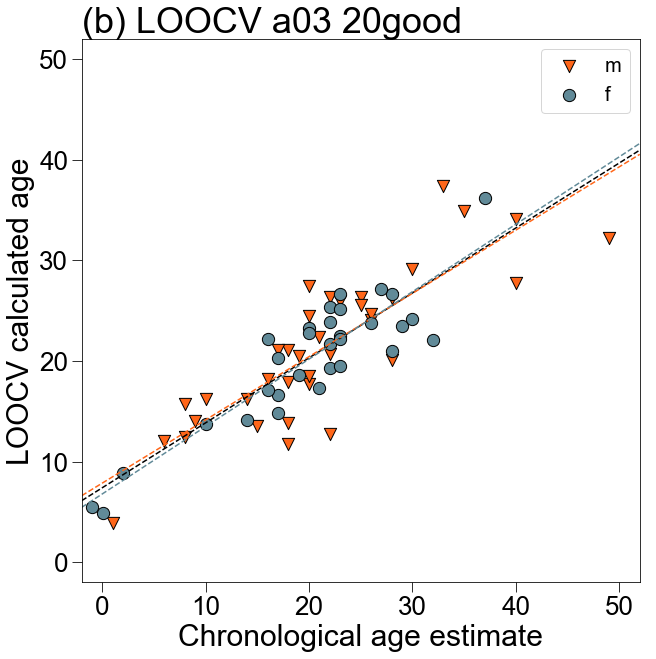

In [120]:
LOOCV_pValue_20good_samp_67_a03_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a03_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a03_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a03_clock", 0.3, len(samp_67_20good_a03_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a03_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a03_sex_specific_fig.eps',
                                      "(b) LOOCV a03 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a03_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a03_sex_specific_stats.csv")
LOOCV_samp_67_20good_a03_stats_df

The mean absolute error is 3.559529255533112
The median absolute error is 2.927086723395398
The mean absolute error for m is 4.058014121573568
The median absolute error for m is 3.186994486496371
The mean absolute error for f is 2.9806436046474225
The median absolute error for f is 2.8512764974888984
r-squared: 0.7627050997254362
p-value: 5.591307080962828e-22
slope: 0.6572953754637693
y-intercept for regression: 7.152872181655331
r-squared for m : 0.7220191965854852
p-value for m : 5.5905129327533476e-11
slope for m : 0.6310081790615524
y-intercept for regression for m : 7.848716440229303
r-squared for f : 0.8246580948405065
p-value for f : 1.7469124522708857e-12
slope for f : 0.6959579086740845
y-intercept for regression for f : 6.214382207837428


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a04_clock    0.4          41  all  3.559529  2.927087   
1  LOOCV_samp_67_20good_a04_clock    0.4          41    m  4.058014  3.186994   
2  LOOCV_samp_67_20good_a04_clock    0.4          41    f  2.980644  2.851276   

   r-squared       p-value  regression_slope  y-intercept  
0   0.762705  5.591307e-22          0.657295     7.152872  
1   0.722019  5.590513e-11          0.631008     7.848716  
2   0.824658  1.746912e-12          0.695958     6.214382

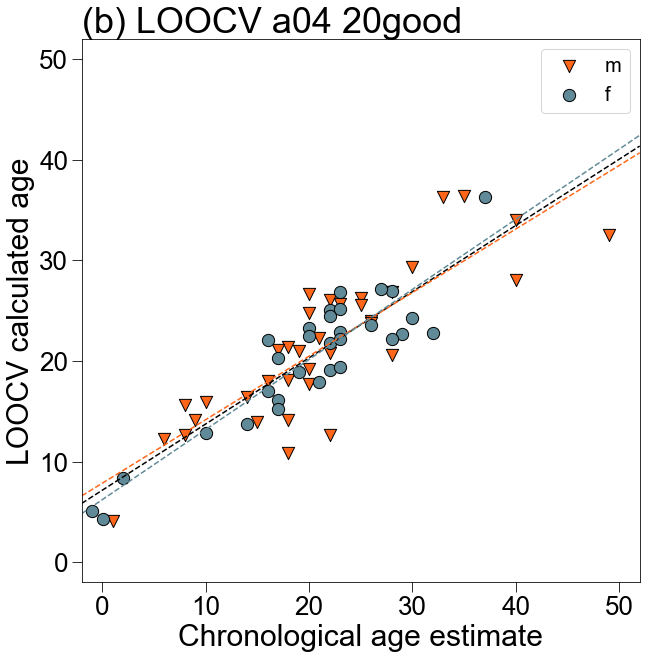

In [121]:
LOOCV_pValue_20good_samp_67_a04_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a04_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a04_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a04_clock", 0.4, len(samp_67_20good_a04_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a04_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a04_sex_specific_fig.eps',
                                      "(b) LOOCV a04 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a04_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a04_sex_specific_stats.csv")
LOOCV_samp_67_20good_a04_stats_df

The mean absolute error is 3.702049939868154
The median absolute error is 3.0490147130107985
The mean absolute error for m is 4.245959616191815
The median absolute error for m is 3.4133165822327527
The mean absolute error for f is 3.07041289639552
The median absolute error for f is 2.6496721190144985
r-squared: 0.737736641291996
p-value: 1.4674370684237174e-20
slope: 0.6608925312054548
y-intercept for regression: 7.048974916013487
r-squared for m : 0.6961718439859952
p-value for m : 2.577525255932313e-10
slope for m : 0.6402904649796058
y-intercept for regression for m : 7.67516235840756
r-squared for f : 0.8024805985186304
p-value for f : 9.94798904047147e-12
slope for f : 0.6897311907067918
y-intercept for regression for f : 6.249209788107915


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a05_clock    0.5          34  all  3.702050  3.049015   
1  LOOCV_samp_67_20good_a05_clock    0.5          34    m  4.245960  3.413317   
2  LOOCV_samp_67_20good_a05_clock    0.5          34    f  3.070413  2.649672   

   r-squared       p-value  regression_slope  y-intercept  
0   0.737737  1.467437e-20          0.660893     7.048975  
1   0.696172  2.577525e-10          0.640290     7.675162  
2   0.802481  9.947989e-12          0.689731     6.249210

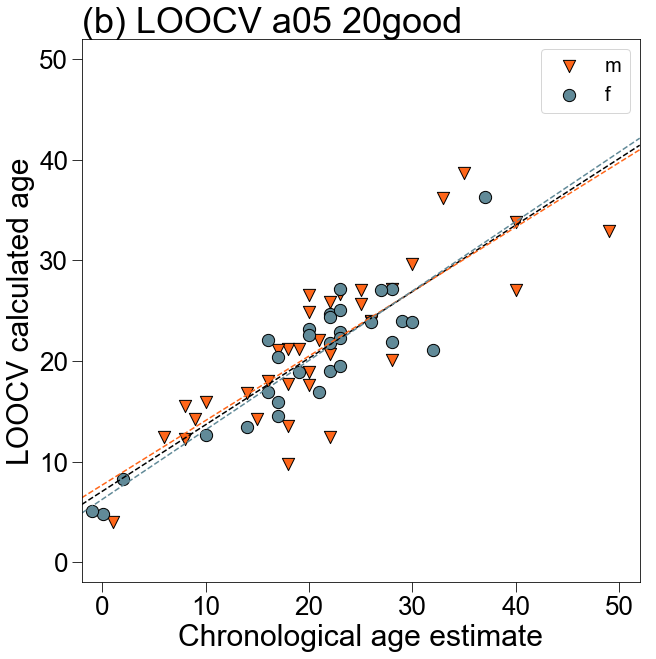

In [122]:
LOOCV_pValue_20good_samp_67_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a05_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a05_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a05_clock", 0.5, len(samp_67_20good_a05_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a05_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a05_sex_specific_fig.eps',
                                      "(b) LOOCV a05 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a05_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a05_sex_specific_stats.csv")
LOOCV_samp_67_20good_a05_stats_df

The mean absolute error is 3.624690714242002
The median absolute error is 2.8478898478408965
The mean absolute error for m is 4.216885189501424
The median absolute error for m is 3.2342079049057166
The mean absolute error for f is 2.9369810010375126
The median absolute error for f is 2.7462907261850997
r-squared: 0.7499362568179248
p-value: 3.096089725497792e-21
slope: 0.6562236692745054
y-intercept for regression: 7.161507568646394
r-squared for m : 0.7002681931879078
p-value for m : 2.0408301856802002e-10
slope for m : 0.6326762275478421
y-intercept for regression for m : 7.831873651003562
r-squared for f : 0.8283905293884749
p-value for f : 1.2760567066163823e-12
slope for f : 0.6900055579198181
y-intercept for regression for f : 6.283441339825499


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a06_clock    0.6          29  all  3.624691  2.847890   
1  LOOCV_samp_67_20good_a06_clock    0.6          29    m  4.216885  3.234208   
2  LOOCV_samp_67_20good_a06_clock    0.6          29    f  2.936981  2.746291   

   r-squared       p-value  regression_slope  y-intercept  
0   0.749936  3.096090e-21          0.656224     7.161508  
1   0.700268  2.040830e-10          0.632676     7.831874  
2   0.828391  1.276057e-12          0.690006     6.283441

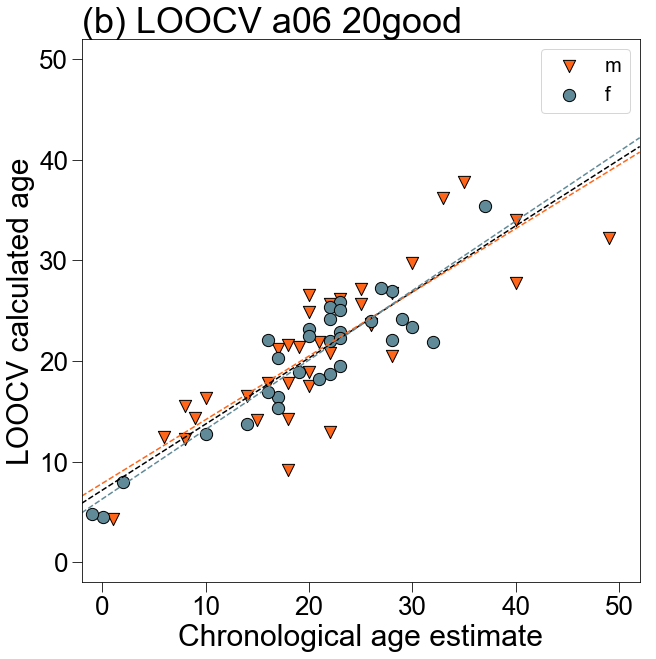

In [123]:
LOOCV_pValue_20good_samp_67_a06_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a06_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a06_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a06_clock", 0.6, len(samp_67_20good_a06_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a06_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a06_sex_specific_fig.eps',
                                      "(b) LOOCV a06 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a06_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a06_sex_specific_stats.csv")
LOOCV_samp_67_20good_a06_stats_df

The mean absolute error is 3.668243617285687
The median absolute error is 2.970999044120603
The mean absolute error for m is 4.2245694690905005
The median absolute error for m is 3.214734568660651
The mean absolute error for f is 3.022187789383323
The median absolute error for f is 2.9053308319834983
r-squared: 0.7482660507439071
p-value: 3.8480290684027836e-21
slope: 0.6540704023723425
y-intercept for regression: 7.209951935144426
r-squared for m : 0.7047059275150953
p-value for m : 1.5791024161638511e-10
slope for m : 0.6301407197408576
y-intercept for regression for m : 7.885673748317146
r-squared for f : 0.8156103450095327
p-value for f : 3.6418432204354615e-12
slope for f : 0.6885006381103786
y-intercept for regression for f : 6.322024170143296


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a07_clock    0.7          28  all  3.668244  2.970999   
1  LOOCV_samp_67_20good_a07_clock    0.7          28    m  4.224569  3.214735   
2  LOOCV_samp_67_20good_a07_clock    0.7          28    f  3.022188  2.905331   

   r-squared       p-value  regression_slope  y-intercept  
0   0.748266  3.848029e-21          0.654070     7.209952  
1   0.704706  1.579102e-10          0.630141     7.885674  
2   0.815610  3.641843e-12          0.688501     6.322024

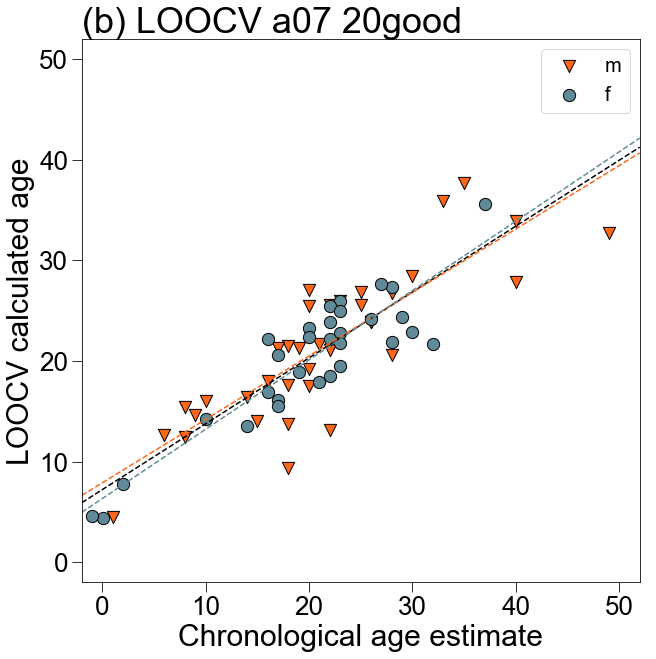

In [124]:
LOOCV_pValue_20good_samp_67_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a07_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a07_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a07_clock", 0.7, len(samp_67_20good_a07_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a07_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a07_sex_specific_fig.eps',
                                      "(b) LOOCV a07 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a07_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a07_sex_specific_stats.csv")
LOOCV_samp_67_20good_a07_stats_df

The mean absolute error is 3.759456257821792
The median absolute error is 3.0975171206248007
The mean absolute error for m is 4.2969945095879565
The median absolute error for m is 3.315359366429349
The mean absolute error for f is 3.135218288028827
The median absolute error for f is 2.6419283488333
r-squared: 0.7333672615709461
p-value: 2.5177559303801424e-20
slope: 0.6614931390322649
y-intercept for regression: 7.06354664860196
r-squared for m : 0.695589510821484
p-value for m : 2.663839288294765e-10
slope for m : 0.6410950177261173
y-intercept for regression for m : 7.732300530427759
r-squared for f : 0.7918683548771814
p-value for f : 2.1377737399950286e-11
slope for f : 0.6891641217643085
y-intercept for regression for f : 6.232942435892554


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a08_clock    0.8          26  all  3.759456  3.097517   
1  LOOCV_samp_67_20good_a08_clock    0.8          26    m  4.296995  3.315359   
2  LOOCV_samp_67_20good_a08_clock    0.8          26    f  3.135218  2.641928   

   r-squared       p-value  regression_slope  y-intercept  
0   0.733367  2.517756e-20          0.661493     7.063547  
1   0.695590  2.663839e-10          0.641095     7.732301  
2   0.791868  2.137774e-11          0.689164     6.232942

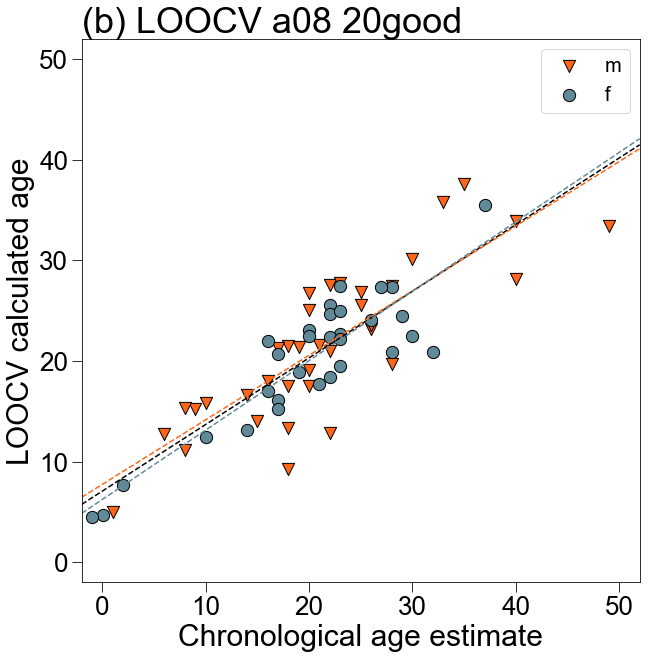

In [125]:
LOOCV_pValue_20good_samp_67_a08_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a08_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a08_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a08_clock", 0.8, len(samp_67_20good_a08_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a08_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a08_sex_specific_fig.eps',
                                      "(b) LOOCV a08 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a08_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a08_sex_specific_stats.csv")
LOOCV_samp_67_20good_a08_stats_df

The mean absolute error is 3.7251806618057945
The median absolute error is 3.229660207587102
The mean absolute error for m is 4.235401683755042
The median absolute error for m is 3.6196482516067476
The mean absolute error for f is 3.1326659266389263
The median absolute error for f is 2.564152361263499
r-squared: 0.7273692917586001
p-value: 5.20856509507511e-20
slope: 0.6662032291273006
y-intercept for regression: 6.945056728053004
r-squared for m : 0.6916155458348943
p-value for m : 3.3297873522536197e-10
slope for m : 0.6399465346301223
y-intercept for regression for m : 7.701003563337698
r-squared for f : 0.7811628166464325
p-value for f : 4.451822147527429e-11
slope for f : 0.7037189981389774
y-intercept for regression for f : 5.959247507935064


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a09_clock    0.9          23  all  3.725181  3.229660   
1  LOOCV_samp_67_20good_a09_clock    0.9          23    m  4.235402  3.619648   
2  LOOCV_samp_67_20good_a09_clock    0.9          23    f  3.132666  2.564152   

   r-squared       p-value  regression_slope  y-intercept  
0   0.727369  5.208565e-20          0.666203     6.945057  
1   0.691616  3.329787e-10          0.639947     7.701004  
2   0.781163  4.451822e-11          0.703719     5.959248

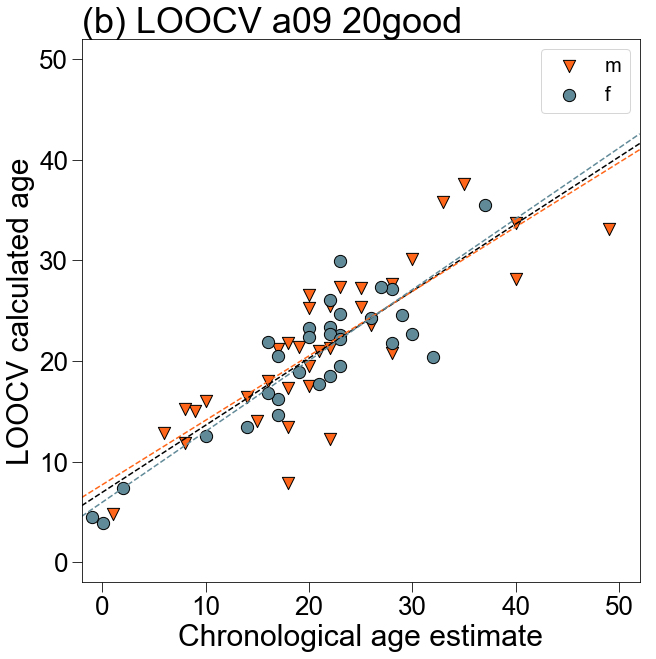

In [126]:
LOOCV_pValue_20good_samp_67_a09_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a09_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a09_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a09_clock", 0.9, len(samp_67_20good_a09_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a09_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a09_sex_specific_fig.eps',
                                      "(b) LOOCV a09 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a09_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a09_sex_specific_stats.csv")
LOOCV_samp_67_20good_a09_stats_df

The mean absolute error is 3.7794871158006305
The median absolute error is 3.186012495137504
The mean absolute error for m is 4.309101208965626
The median absolute error for m is 3.5406006312285507
The mean absolute error for f is 3.1644513947057975
The median absolute error for f is 2.788890394090499
r-squared: 0.7282267615078979
p-value: 4.699047202699697e-20
slope: 0.6621171709487246
y-intercept for regression: 7.08595003538343
r-squared for m : 0.6855990783034984
p-value for m : 4.6432459938989053e-10
slope for m : 0.6287668527470544
y-intercept for regression for m : 8.024975714030068
r-squared for f : 0.7929276129558552
p-value for f : 1.9840987026592933e-11
slope for f : 0.7101510016919944
y-intercept for regression for f : 5.85062008358212


clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a1_clock    1.0          20  all  3.779487  3.186012   
1  LOOCV_samp_67_20good_a1_clock    1.0          20    m  4.309101  3.540601   
2  LOOCV_samp_67_20good_a1_clock    1.0          20    f  3.164451  2.788890   

   r-squared       p-value  regression_slope  y-intercept  
0   0.728227  4.699047e-20          0.662117     7.085950  
1   0.685599  4.643246e-10          0.628767     8.024976  
2   0.792928  1.984099e-11          0.710151     5.850620

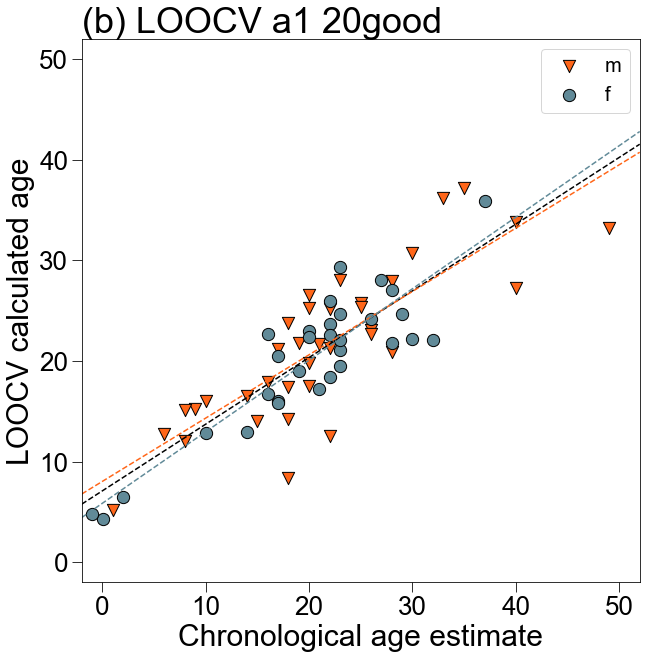

In [127]:
LOOCV_pValue_20good_samp_67_a1_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_67_a1_LOOCV.csv',
                                       sesame_KBO_samp_67_sample_names, beluga_metadata_df)


LOOCV_samp_67_20good_a1_stats_df = sex_specific_clock_plots_and_stats("LOOCV_samp_67_20good_a1_clock", 1.0, len(samp_67_20good_a1_clock['cpgs'])-1,
                                                                    LOOCV_pValue_20good_samp_67_a1_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a1_sex_specific_fig.eps',
                                      "(b) LOOCV a1 20good", "Chronological age estimate", "LOOCV calculated age")

LOOCV_samp_67_20good_a1_stats_df.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_67_a1_sex_specific_stats.csv")
LOOCV_samp_67_20good_a1_stats_df

In [128]:

LOOCV_dfs_20good_samp_67 = [LOOCV_samp_67_20good_a01_stats_df, LOOCV_samp_67_20good_a02_stats_df,
                           LOOCV_samp_67_20good_a03_stats_df, LOOCV_samp_67_20good_a04_stats_df, 
                           LOOCV_samp_67_20good_a05_stats_df, LOOCV_samp_67_20good_a06_stats_df,
                           LOOCV_samp_67_20good_a07_stats_df, LOOCV_samp_67_20good_a08_stats_df,
                           LOOCV_samp_67_20good_a09_stats_df, LOOCV_samp_67_20good_a1_stats_df]

stats_LOOCV_dfs_20good_samp_67_clocks = pd.concat(LOOCV_dfs_20good_samp_67)

stats_LOOCV_dfs_20good_samp_67_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_LOOCV_dfs_20good_samp_67_clocks.csv')


stats_LOOCV_dfs_20good_samp_67_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a01_clock    0.1         133  all  3.585203  3.008022   
1  LOOCV_samp_67_20good_a01_clock    0.1         133    m  3.925965  2.936779   
2  LOOCV_samp_67_20good_a01_clock    0.1         133    f  3.189480  3.020731   
0  LOOCV_samp_67_20good_a02_clock    0.2          72  all  3.639863  2.787983   
1  LOOCV_samp_67_20good_a02_clock    0.2          72    m  4.034210  2.838866   
2  LOOCV_samp_67_20good_a02_clock    0.2          72    f  3.181911  2.787983   
0  LOOCV_samp_67_20good_a03_clock    0.3          52  all  3.649137  2.907042   
1  LOOCV_samp_67_20good_a03_clock    0.3          52    m  4.094931  2.976118   
2  LOOCV_samp_67_20good_a03_clock    0.3          52    f  3.131440  2.761977   
0  LOOCV_samp_67_20good_a04_clock    0.4          41  all  3.559529  2.927087   
1  LOOCV_samp_67_20good_a04_clock    0.4          41    m  4.058014  3.186994   
2  LOOCV_samp_67_20good_a04_clock    0.4          41    f  2.980644  2.851276   
0  LOOCV_samp_67_20good_a05_clock    0.5          34  all  3.702050  3.049015   
1  LOOCV_samp_67_20good_a05_clock    0.5          34    m  4.245960  3.413317   
2  LOOCV_samp_67_20good_a05_clock    0.5          34    f  3.070413  2.649672   
0  LOOCV_samp_67_20good_a06_clock    0.6          29  all  3.624691  2.847890   
1  LOOCV_samp_67_20good_a06_clock    0.6          29    m  4.216885  3.234208   
2  LOOCV_samp_67_20good_a06_clock    0.6          29    f  2.936981  2.746291   
0  LOOCV_samp_67_20good_a07_clock    0.7          28  all  3.668244  2.970999   
1  LOOCV_samp_67_20good_a07_clock    0.7          28    m  4.224569  3.214735   
2  LOOCV_samp_67_20good_a07_clock    0.7          28    f  3.022188  2.905331   
0  LOOCV_samp_67_20good_a08_clock    0.8          26  all  3.759456  3.097517   
1  LOOCV_samp_67_20good_a08_clock    0.8          26    m  4.296995  3.315359   
2  LOOCV_samp_67_20good_a08_clock    0.8          26    f  3.135218  2.641928   
0  LOOCV_samp_67_20good_a09_clock    0.9          23  all  3.725181  3.229660   
1  LOOCV_samp_67_20good_a09_clock    0.9          23    m  4.235402  3.619648   
2  LOOCV_samp_67_20good_a09_clock    0.9          23    f  3.132666  2.564152   
0   LOOCV_samp_67_20good_a1_clock    1.0          20  all  3.779487  3.186012   
1   LOOCV_samp_67_20good_a1_clock    1.0          20    m  4.309101  3.540601   
2   LOOCV_samp_67_20good_a1_clock    1.0          20    f  3.164451  2.788890   

   r-squared       p-value  regression_slope  y-intercept  
0   0.756134  1.364227e-21          0.653788     7.305407  
1   0.725085  4.620755e-11          0.641849     7.668122  
2   0.804005  8.882866e-12          0.670503     6.842069  
0   0.753585  1.915662e-21          0.645597     7.363066  
1   0.719128  6.678100e-11          0.630581     7.790738  
2   0.806700  7.256384e-12          0.667138     6.802970  
0   0.748847  3.568272e-21          0.644789     7.398598  
1   0.711984  1.028245e-10          0.627914     7.859955  
2   0.805744  7.798537e-12          0.669344     6.784475  
0   0.762705  5.591307e-22          0.657295     7.152872  
1   0.722019  5.590513e-11          0.631008     7.848716  
2   0.824658  1.746912e-12          0.695958     6.214382  
0   0.737737  1.467437e-20          0.660893     7.048975  
1   0.696172  2.577525e-10          0.640290     7.675162  
2   0.802481  9.947989e-12          0.689731     6.249210  
0   0.749936  3.096090e-21          0.656224     7.161508  
1   0.700268  2.040830e-10          0.632676     7.831874  
2   0.828391  1.276057e-12          0.690006     6.283441  
0   0.748266  3.848029e-21          0.654070     7.209952  
1   0.704706  1.579102e-10          0.630141     7.885674  
2   0.815610  3.641843e-12          0.688501     6.322024  
0   0.733367  2.517756e-20          0.661493     7.063547  
1   0.695590  2.663839e-10          0.641095     7.732301  
2   0.791868  2.137774e-11          0.689164     6.232942  
0   0.72736

In [129]:
LOOCV_n67_20good_overall_stats = stats_LOOCV_dfs_20good_samp_67_clocks[stats_LOOCV_dfs_20good_samp_67_clocks['sex']=='all']
LOOCV_n67_20good_overall_stats

clock_info  alpha  clock_size  sex       mae     medae  \
0  LOOCV_samp_67_20good_a01_clock    0.1         133  all  3.585203  3.008022   
0  LOOCV_samp_67_20good_a02_clock    0.2          72  all  3.639863  2.787983   
0  LOOCV_samp_67_20good_a03_clock    0.3          52  all  3.649137  2.907042   
0  LOOCV_samp_67_20good_a04_clock    0.4          41  all  3.559529  2.927087   
0  LOOCV_samp_67_20good_a05_clock    0.5          34  all  3.702050  3.049015   
0  LOOCV_samp_67_20good_a06_clock    0.6          29  all  3.624691  2.847890   
0  LOOCV_samp_67_20good_a07_clock    0.7          28  all  3.668244  2.970999   
0  LOOCV_samp_67_20good_a08_clock    0.8          26  all  3.759456  3.097517   
0  LOOCV_samp_67_20good_a09_clock    0.9          23  all  3.725181  3.229660   
0   LOOCV_samp_67_20good_a1_clock    1.0          20  all  3.779487  3.186012   

   r-squared       p-value  regression_slope  y-intercept  
0   0.756134  1.364227e-21          0.653788     7.305407  
0   0.753585  1.915662e-21          0.645597     7.363066  
0   0.748847  3.568272e-21          0.644789     7.398598  
0   0.762705  5.591307e-22          0.657295     7.152872  
0   0.737737  1.467437e-20          0.660893     7.048975  
0   0.749936  3.096090e-21          0.656224     7.161508  
0   0.748266  3.848029e-21          0.654070     7.209952  
0   0.733367  2.517756e-20          0.661493     7.063547  
0   0.727369  5.208565e-20          0.666203     6.945057  
0   0.728227  4.699047e-20          0.662117     7.085950

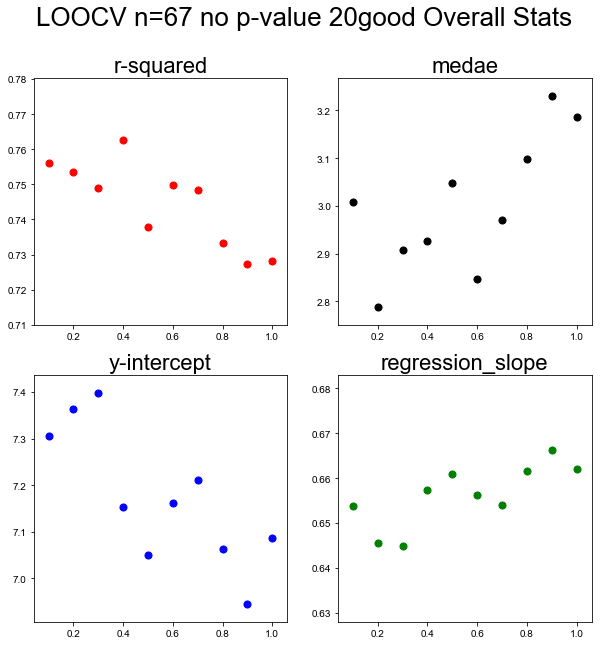

In [130]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)

plt.subplot(221)
plt.scatter(LOOCV_n67_20good_overall_stats['alpha'], LOOCV_n67_20good_overall_stats['r-squared'], s=50, color ='red', )
plt.title('r-squared', fontsize = 22)
plt.subplot(222)
plt.scatter(LOOCV_n67_20good_overall_stats['alpha'], LOOCV_n67_20good_overall_stats['medae'], s=50, color = 'black')
plt.title('medae', fontsize = 22)
plt.subplot(223)
plt.scatter(LOOCV_n67_20good_overall_stats['alpha'], LOOCV_n67_20good_overall_stats['y-intercept'], s=50, color ='blue')
plt.title('y-intercept', fontsize=22)
plt.subplot(224)
plt.scatter(LOOCV_n67_20good_overall_stats['alpha'], LOOCV_n67_20good_overall_stats['regression_slope'], s=50, color = 'green')
plt.title('regression_slope', fontsize = 22)

fig.suptitle('LOOCV n=67 no p-value 20good Overall Stats', fontsize = 26)

fig.savefig("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/compare_20good_LOOCV_overall_stats.pdf")

# Estimate Ages of Biopsy Samples Using the Beluga Clock!

In [131]:
### FUNCTION ### 
### calcualte_biopsy_ages ###

# This function takes the following arguments: 
# (1) a list of whale sample names (whale_id_list) that correpond with the columns in a beta data file. 
# (2) the dataframe containing raw data you'd like to use 
# (3) the dataframe containing the current clock values - must have the columns 'cpgs' and 'coefficients'
# 
# NOTE that 'cpgs' and 'coefficients' have to have been defined outside of the function from R glmnet() output. 
# One way of defining cpgs and coefficients is to use the function above: make_epigenetic_clock
# This returns a dataframe that has two columns: sampleID and model_ages_df

def calculate_biopsy_ages(whale_id_list, normalized_beta_dataframe, current_clock_df): 
    # Calculate how many CpG terms there are in the clock/model 
    cpgs = current_clock_df['cpgs']
    coefficients = current_clock_df['coefficients']
    print ("There are", len(cpgs)-1, "cpgs in the current model")
    # This loops through the *index* of the cpgs to capture each term in the equation. 
    # NOTE: It starts at 1 because the 0 index item is the y-intercept!
    numbers = [i for i in range(1,len(cpgs)-1)]
    model_ages = []
    yIntercept = coefficients[0]
    # The following loop takes each whale and takes the column of beta values for that whale out of your dataframe
    for whale_id in whale_id_list:     
        beta_values_dleu_whale = normalized_beta_dataframe[whale_id]
        # Note that 'calculated_age' is a number that evolves throughout this code as each term of the equation is filled.
        # It starts here as the yIntercept and with the loop below, each term of the equation is added to the value. 
        # This process goes until the final output is the actual calculated age. 
        calculated_age = yIntercept
        
        for i in numbers: 
            #print (beta_values_dleu_whale[cpgs[i]] * coefficients[i])
            calculated_age = calculated_age + (beta_values_dleu_whale[current_clock_df.cpgs[i]] * current_clock_df.coefficients[i])
        
        # You can un-comment the following line to see the numbers as they are calcuated. 
        # print(whale_id, calculated_age)
        model_ages.append(calculated_age)
    model_ages_df = pd.DataFrame(columns=['sampleID', 'model_age'])
    model_ages_df['sampleID'] = whale_id_list
    model_ages_df['model_age'] = model_ages

    #Output of this function is a dataframe with whale sampleID and calculated model age
    return model_ages_df

###

In [132]:
biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)
#len(biopsy_df)

biopsy_ages_n67_10good_a09_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, samp_67_10good_a09_clock)

biopsy_ages_n67_10good_a09_clock



There are 23 cpgs in the current model


sampleID  model_age
0  MML_RA170902-B02  10.637026
1  MML_RA170903-B02  16.177467

In [133]:
#Calculate biopsy ages using the final clock = KBO sample 69
biopsy_plate_sesame_beta_data_file = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_array_data/NormalizedData/sesame_normalized_biopsy_plate_LabIDs.csv'
new_biopsy_sesame_df = pd.read_csv(biopsy_plate_sesame_beta_data_file, sep = ',', index_col=0)
#new_biopsy_sesame_df

biopsy_plate_ages_n67_10good_a09_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, samp_67_10good_a09_clock)
biopsy_plate_ages_n67_10good_a09_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/biopsy_plate_ages_n67_10good_a09_clock.csv')

biopsy_plate_ages_n67_10good_a09_clock


There are 23 cpgs in the current model


sampleID  model_age
0        Dleu17CI02  17.461440
1        Dleu17CI04  17.389327
2        Dleu17CI05  17.222939
3        Dleu17CI06  16.369395
4        Dleu17CI07  21.478536
5        Dleu17CI08  26.859960
6        Dleu17CI09  10.617421
7        Dleu17CI10  22.991855
8        Dleu17CI11  18.858278
9        Dleu17CI12  21.600010
10       Dleu17CI13  12.883416
11       Dleu16CI01  13.255193
12       Dleu16CI02  19.375934
13       Dleu16CI03  16.146060
14       Dleu16CI04  21.968134
15       Dleu16CI05  20.414827
16       Dleu18CI01  14.448727
17       Dleu18CI02  15.828563
18       Dleu18CI03  15.234721
19       Dleu18CI04  24.582568
20       Dleu18CI05  20.582408
21       Dleu18CI06  21.366480
22       Dleu18CI07  18.653742
23       Dleu18CI08  17.600852
24       Dleu18CI09  19.284396
25       Dleu18CI10  26.176386
26       Dleu18CI11  18.748615
27       Dleu18CI12  16.318621
28       Dleu18CI13  11.832789
29       Dleu18CI14  16.926318
30       Dleu18CI15  15.923247
31       Dleu18CI16  12.637583
32       Dleu18CI17  22.563176
33       Dleu18CI18  25.130436
34       Dleu18CI19  22.598788
35       Dleu18CI20  18.284933
36       Dleu18CI21  15.214105
37    Dleu_4196_KBO  22.449906
38    Dleu_9799_KBO  26.175172
39   Dleu_17861_KBO  20.385044
40   Dleu_28926_KBO  16.141575
41   Dleu_34579_KBO  21.650714
42  Dleu_35278_KBO   33.575389
43   Dleu_35281_KBO  24.053823
44   Dleu_79633_KBO  33.045106
45  Dleu_143907_KBO  21.025547
46       Chem18NZ02  20.065912
47       Chem18NZ04   4.261167

In [134]:
biopsy_age_prediction = biopsy_plate_ages_n67_10good_a09_clock.iloc[0:37]

biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)

first_biopsy_ages_n67_10good_a09_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, samp_67_10good_a09_clock)

first_biopsy_ages_n67_10good_a09_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/first_biopsy_ages_n67_clock.csv')
#print (first_biopsy_ages_n67_10good_a09_clock)

biopsy_age_prediction = biopsy_age_prediction.append(first_biopsy_ages_n67_10good_a09_clock)

print(biopsy_age_prediction)

biopsy_age_prediction['integer_age'] = biopsy_age_prediction['model_age'].round(0)


biopsy_age_prediction.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/estimated_biopsy_ages_n67_10good_a09_clock.csv")


There are 23 cpgs in the current model
            sampleID  model_age
0         Dleu17CI02  17.461440
1         Dleu17CI04  17.389327
2         Dleu17CI05  17.222939
3         Dleu17CI06  16.369395
4         Dleu17CI07  21.478536
5         Dleu17CI08  26.859960
6         Dleu17CI09  10.617421
7         Dleu17CI10  22.991855
8         Dleu17CI11  18.858278
9         Dleu17CI12  21.600010
10        Dleu17CI13  12.883416
11        Dleu16CI01  13.255193
12        Dleu16CI02  19.375934
13        Dleu16CI03  16.146060
14        Dleu16CI04  21.968134
15        Dleu16CI05  20.414827
16        Dleu18CI01  14.448727
17        Dleu18CI02  15.828563
18        Dleu18CI03  15.234721
19        Dleu18CI04  24.582568
20        Dleu18CI05  20.582408
21        Dleu18CI06  21.366480
22        Dleu18CI07  18.653742
23        Dleu18CI08  17.600852
24        Dleu18CI09  19.284396
25        Dleu18CI10  26.176386
26        Dleu18CI11  18.748615
27        Dleu18CI12  16.318621
28        Dleu18CI13  11.832789
2

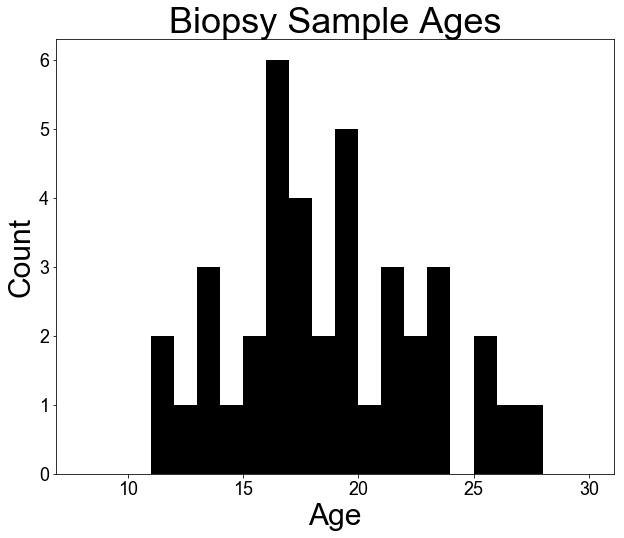

In [135]:

biopsy_age_prediction.hist(column='integer_age', bins = 22, range = (8,30),histtype = 'bar', figsize=(10,8), color = 'Black', xlabelsize=18, 
                                 ylabelsize = 18)
plt.title('Biopsy Sample Ages', fontsize = 36)
plt.ylabel('Count',  fontsize = 30)
plt.xlabel('Age',  fontsize = 30)
plt.grid(b=None)

plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/biopsy_age_histogram_n67_10good_a09_clock.eps')

### Add Sex data for biopsy samples + remove duplicate extraction 
Using the sex predictor model generated through cv.glmnet() in R, I generated sex predictions for the biopsy samples. These were then added to a CSV with the age predictions and used to plot the data below. 


 The new input file we want was made OUTSIDE OF PYTHON, combining outputs from the above work as well as from R. 


In [166]:
# Import the biopsy data file with sex and removed duplicate: n = 38
# Manually add the correct names for SampleID and FieldID


biopsy_data_final_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/estimated_biopsy_ages_with_field_ID_and_sex_n67_10good_a09_clock.csv'

final_biopsy_df = pd.read_csv(biopsy_data_final_path, sep = ',', index_col=0)

print(final_biopsy_df.min())

final_biopsy_df



sampleID       Dleu16CI01
model_age         10.6174
integer_age            11
sex                     F
dtype: object


sampleID  model_age  integer_age sex
fieldID                                                 
MML_RA170902-B04  Dleu17CI02  17.461440           17   M
MML_RA170902_B01  Dleu17CI04  17.389327           17   F
MML_RA170902_B03  Dleu17CI05  17.222939           17   M
MML_RA170903_B01  Dleu17CI07  21.478536           21   M
MML_RA170904_B01  Dleu17CI08  26.859960           27   M
MML_RA170907_B01  Dleu17CI09  10.617421           11   F
MML_RA170907_B02  Dleu17CI10  22.991855           23   M
MML_RA170909_B01  Dleu17CI11  18.858278           19   F
MML_RA170909_B02  Dleu17CI12  21.600010           22   F
MML_RA170909_B03  Dleu17CI13  12.883416           13   F
MML_RA160813_B01  Dleu16CI01  13.255193           13   F
MML_RA160815_B01  Dleu16CI02  19.375934           19   M
MML_RA160819_B01  Dleu16CI03  16.146060           16   F
MML_RA160819_B02  Dleu16CI04  21.968134           22   F
MML_RA160820_B01  Dleu16CI05  20.414827           20   F
MML_RA180906_B01  Dleu18CI01  14.448727           14   F
MML_RA180906_B02  Dleu18CI02  15.828563           16   M
MML_RA180906_B03  Dleu18CI03  15.234721           15   M
MML_RA180909_B01  Dleu18CI04  24.582568           25   M
MML_RA180909_B02  Dleu18CI05  20.582408           21   M
MML_RA180909_B03  Dleu18CI06  21.366480           21   M
MML_RA180910_B01  Dleu18CI07  18.653742           19   F
MML_RA180910_B02  Dleu18CI08  17.600852           18   F
MML_RA180910_B03  Dleu18CI09  19.284396           19   F
MML_RA180910_B04  Dleu18CI10  26.176386           26   M
MML_RA180910_B05  Dleu18CI11  18.748615           19   M
MML_RA180911_B01  Dleu18CI12  16.318621           16   F
MML_RA180911_B02  Dleu18CI13  11.832789           12   M
MML_RA180911_B03  Dleu18CI14  16.926318           17   F
MML_RA180911_B04  Dleu18CI15  15.923247           16   M
MML_RA180911_B05  Dleu18CI16  12.637583           13   M
MML_RA180912_B01  Dleu18CI17  22.563176           23   M
MML_RA180912_B02  Dleu18CI18  25.130436           25   M
MML_RA180912_B03  Dleu18CI19  22.598788           23   M
MML_RA180912_B04  Dleu18CI20  18.284933           18   M
MML_RA180912_B05  Dleu18CI21  15.214105           15   F
MML_RA170902-B02  Dleu17CI01  10.637026           11   F
MML_RA170903-B02  Dleu17CI03  16.177467           16   F

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


20
18


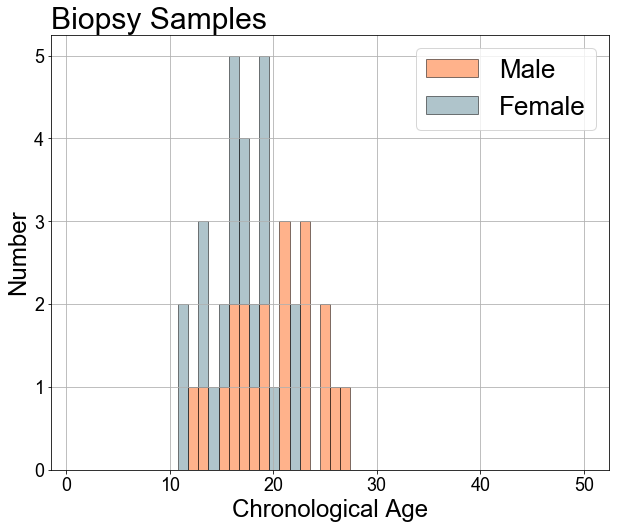

In [177]:
x = final_biopsy_df['integer_age'][final_biopsy_df['sex']=='M']
y = final_biopsy_df['integer_age'][final_biopsy_df['sex']=='F']


color_dic = {'F': '#618A98', 'M':'#FF6619'}

bins = 50
plt.figure(figsize=(10,8))

plt.hist([x,y], bins, alpha=0.5, label=['Male', 'Female'], color =['#FF6619','#618A98'], histtype='bar', stacked= True, edgecolor = 'black', range=(1,50))

#plt.hist([x, y], bins, label=['male', 'female'])
#plt.hist(x, bins, alpha=0.5, label='Male', color ='#FF6619', range = (1,30))
#plt.hist(y, bins, alpha=0.5, label='Female', color = '#618A98', range = (1,30))

print(len(x))
print(len(y))


plt.legend(loc='upper right', fontsize = 26)
plt.title('', fontsize = 36)
plt.xlabel('Chronological Age', fontsize = 24)
plt.ylabel('Number', fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Biopsy Samples', fontsize = 30, loc='left')
plt.grid(True)

plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/biopsy_age_histogram_n67_10good_a09_clock_by_sex.pdf')